In [3]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
import json
from ensemble_boxes import *
import copy

In [41]:
config_file = '../configs/detectors/dent_detector_latest_segm.py'
checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'

#config_file = '../models/crack_mosaic/crack_mosaic.py'
#checkpoint_file = '../models/crack_mosaic/epoch_7.pth'

In [42]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

2021-04-06 06:56:37,749 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.weight_diff, layer2.0.conv2.switch.weight, layer2.0.conv2.switch.bias, layer2.0.conv2.pre_context.weight, layer2.0.conv2.pre_context.bias, layer2.0.conv2.post_context.weight, layer2.0.conv2.post_context.bias, layer2.0.conv2.offset_s.weight, layer2.0.conv2.offset_s.bias, layer2.0.conv2.offset_l.weight, layer2.0.conv2.offset_l.bias, layer2.0.rfp_conv.weight, layer2.0.rfp_conv.bias, layer2.1.conv2.weight_diff, layer2.1.conv2.switch.weight, layer2.1.conv2.switch.bias, layer2.1.conv2.pre_context.weight, layer2.1.conv2.pre_context.bias, layer2.1.conv2.post_context.weight, layer2.1.conv2.post_context.bias, layer2.1.conv2.offset_s.weight, layer2.1.conv2.offset_s.bias, layer2.1.conv2.offset_l.weight, layer2.1.conv2.offset_l.bias, layer2.2.conv2.weight_diff, layer2.2.conv2.switch.weight, layer2

In [21]:
path = Path('../data/dent')

In [22]:
test = json.load(open(path/'annotations'/'dent_test.json'))
print(test['info'])
print(len(test['images']),len(test['annotations']))

{'description': 'Car Parts Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2017, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
2252 3501


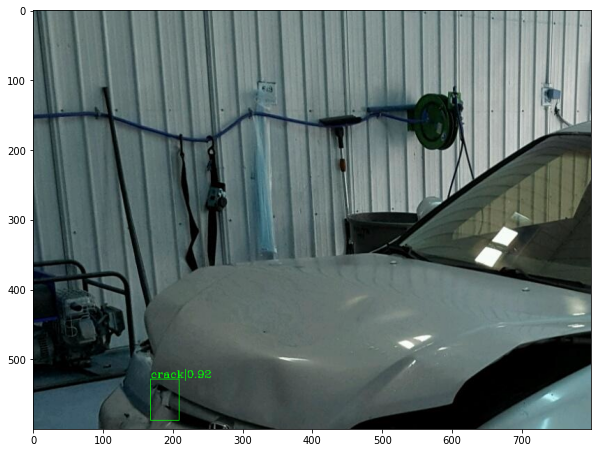

In [192]:
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
h,w,_ = img.shape
img = img[:int(h/2),:int(w/2)]
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [ ]:
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [ ]:
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [35]:
def normolize_box(boxes,height,width):
    new_boxes = []
    for b in boxes:
        new_b = []
        for p in b:
            new_b.extend(np.array(p)/(width,height))
        new_boxes.append(new_b)
    
    return new_boxes

def get_data_box(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    data_box['boxes'] = normolize_box(boxes,*img.shape[:-1])
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

def get_data_box_flip(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    
    boxes = normolize_box(boxes,*img.shape[:-1])
    for i in range(len(boxes)):
        boxes[i][0] = 1-boxes[i][0]
        boxes[i][2] = 1-boxes[i][2]
    data_box['boxes'] = boxes
    
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

In [43]:
data = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    data[i['id']] = get_data_box(image,i['file_name'],pred_boxes,pred_labels,pred_scores)

with open('detector_dent_pred_03.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|██████████| 2252/2252 [23:02<00:00,  1.63it/s]


In [103]:
data_flip = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    image = np.fliplr(image)
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.4)
    data_flip[i['id']] = get_data_box_flip(image,i['file_name'],pred_boxes,pred_labels,pred_scores)

with open('detector_pred_flip.json', 'w', encoding='utf-8') as f:
    json.dump(data_flip, f, ensure_ascii=False, indent=4)

100%|██████████| 738/738 [06:12<00:00,  1.98it/s]


In [44]:
#pred_data = json.load(open('detector_pred.json'))
pred_data = json.load(open('detector_dent_pred_03.json'))
pred_data_flip = json.load(open('yolo_pred_dent.json'))

In [45]:
def remove_ovelap(boxes):
    idx = [True for b in boxes]
    for i1 in range(len(boxes)-1) :
        for i2 in range(i1+1,len(boxes)):
            if idx[i1] == True and boxes[i1][0] < boxes[i2][0] and boxes[i1][1] < boxes[i2][1] and boxes[i1][2] > boxes[i2][2] and boxes[i1][3] > boxes[i2][3] :
                idx[i1] = False
                break
            
            if idx[i2] == True and boxes[i1][0] > boxes[i2][0] and boxes[i1][1] > boxes[i2][1] and boxes[i1][2] < boxes[i2][2] and boxes[i1][3] < boxes[i2][3] :
                idx[i2] = False
                continue
    return boxes[idx]
            
es = OrderedDict()
for i in test['images']:
    boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
    scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
    labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]
    
    if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = []
        i_data['labels'] = []
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[0]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[1]
        i_data['labels'] = labels_list[1]
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[1]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[0]
        i_data['labels'] = labels_list[0]
        es[str(i['id'])] = i_data
        continue
    
    weights = [2,1]
    iou_thr = 0.36
    skip_box_thr = 0.0001
    sigma = 0.1
    
    boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes.tolist()
    i_data['labels'] = labels.tolist()
    es[str(i['id'])] = i_data
    #print(len([a for a in test['annotations'] if a['image_id']==i['id']]))
    #img = cv2.imread(str(path/'images'/i['file_name']))
    #plot(img,boxes,scores)
    #break
with open('ensemble_dent.json', 'w', encoding='utf-8') as f:
    json.dump(es, f, ensure_ascii=False, indent=4)

In [19]:
def plot(idx, boxes):
    image = cv2.imread(str(path/'images'/es[str(idx)]['name']))
    img = image.copy()
    h,w, _ = img.shape
    for i in range(len(boxes)):
        img = cv2.rectangle(img,(int(boxes[i][0]*w),int(boxes[i][1]*h)),(int(boxes[i][2]*w),int(boxes[i][3]*h)),(255,255,0),2)
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['name']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,0,0),2)
    
    #plt.figure(figsize=(20,10))
    #plt.imshow(np.hstack((img,image)))
    return np.hstack((img,image))

def plot_fp(idx,i_boxes):
    img = cv2.imread(str(path/'images'/es[str(idx)]['name']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['name']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
    
    pred_labels = [0 for i in boxes]
    
    pred_tp = [0 for i in boxes]
    gt_tp = [0 for i in gt_boxes]
    
    for i in range(len(boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            #print(boxes[i],i_gt_boxes[j])
            iou = cal_iou(img,boxes[i],i_gt_boxes[j])
            if iou > 0.25:
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_labels[idx] = -1
                pred_tp[i] = 1
                gt_tp[idx] = 1
                break
    
    for i in range(len(pred_tp)):
        #print(i)
        #print(boxes[i][0])
        if pred_tp[i]:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2)
        else:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    
    #print(img_out.shape,img.shape)
    return np.hstack((img_out,img))

def cal_iou(img,box1,box2):
    #print(box1,box2)
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    tp = 0
    
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.25 :
                tp += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                #gt_labels[idx] = -1
                break
            
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    fp = 0
    tp = 0
    
    for i in range(len(pred_boxes)):
        #i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        #for j in range(len(gt_boxes)):
            #iou = cal_iou(img,pred_boxes[i],gt_boxes[j])
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
        else:
            fp += 1
            
            #if iou > 0.25 :
                #tp += 1
                #idx = gt_boxes.index(i_gt_boxes[j])
            #    gt_labels[j] = -1
            #    break
            #if j == len(gt_boxes)-1:
            #    fp += 1
            
    #tp = len([i for i in gt_labels if i == -1])
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

In [47]:
es = json.load(open('detector_dent_pred_03.json'))
total_tp = 0
total_fn = 0
total_fp = 0
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    h,w,_=image.shape
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
    
    pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
    for j in range(len(pred_boxes)):
        pred_boxes[j][0] = int(pred_boxes[j][0]*w)
        pred_boxes[j][1] = int(pred_boxes[j][1]*h)
        pred_boxes[j][2] = int(pred_boxes[j][2]*w)
        pred_boxes[j][3] = int(pred_boxes[j][3]*h)
        
        pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
    pred_labels = es[str(i['id'])]['labels']
    
    tp,fp,fn = cal_v2(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
    total_tp += tp
    total_fp += fp
    total_fn += fn
    print(i['id'],i['file_name'])
    print(tp,fp,fn)
    #print(pred_boxes)
    #break
print(total_tp,total_fp,total_fn)

  0%|          | 0/2252 [00:00<?, ?it/s]

6028 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459466_04.JPG
1 0 0


  0%|          | 7/2252 [00:00<06:37,  5.65it/s]

10853 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_47_DSCN0136.JPG
1 1 1
9291 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4235_detail_damage1_8584_medium_B866BE6D-406A-4AE7-9ECA-E2B6E33E9002.jpeg
1 0 0
10601 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1480_DSCN4801mark+(2).JPG
0 1 1
5856 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2871_detail_damage1_24797_medium_2019-06-17_17.46.38.jpg
4 0 0
9737 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1047_IMG-20180825-WA0035.jpg
1 0 0
7539 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_TD%2014A%20-%20204.98%20-%2027.05.2018_z1001057598950_c7b20679d7a8d2af31a8a1553ce9d6dd.jpg
2 0 0
6524 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000402_316008156_DSCN4978.jpg
0 0 1
7027 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20131.09%20-%2005.04.2018_14A%20-%20131.09_z950954810081_579a9ea3512e57045819add

  1%|          | 17/2252 [00:00<03:38, 10.23it/s]

14377 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5b58609f6b84ee33601478ac63d3862302398e89.jpg
1 0 2
13420 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_886_IMG_1925.JPG
1 0 0
8467 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6259_detail_damage2_15329_medium_BF7760D1-D31F-433F-BC15-B9C3B342B6E4.jpeg
2 0 1
11916 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_383_P_20151222_125540.jpg
1 0 0
855 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6418_vehicle_additional_docs_15599_medium_image.jpg
0 2 1
8133 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5657_rear_left_view_9635_medium_IMG_20180806_164533401_HDR.jpg
1 0 0
14166 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0f5eb5c9fa6af3f703710275359db0ccb1707fb3.jpg
1 0 1
3558 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_vehicle_additional_docs_39152_medium_image.jpg
2 0 3
6564 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655102_IMG_0145.JPG
0 0 1
13243 https:__s3.amazonaws.com_mc-a

  1%|          | 21/2252 [00:01<04:19,  8.59it/s]

10511 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7974.JPG
1 1 1


  1%|          | 24/2252 [00:01<04:18,  8.63it/s]

10883 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_57_DSCN7508.JPG
1 0 0
9293 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4237_detail_damage1_8658_medium_15323934206938903065793110052962.jpg
1 0 0
6089 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611801307_img1803455.jpg
1 0 0
5969 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4378_detail_damage2_19873_medium_image.jpg
1 0 0
2990 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_rear_right_view_23029_medium_image.jpg
0 2 1
4744 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_rear_left_view_12853_medium_CD2C9350-C51C-41EC-8F3D-8BBA48777DB1.jpeg
1 0 0
12656 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG_5914.JPG
1 0 0
14577 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f7f5e0d9076d40b1193678442037743399be2bc.jpg
1 0 0


  1%|▏         | 30/2252 [00:02<04:08,  8.94it/s]

10400 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1319_DSCN1190.JPG
1 1 1
6022 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5173_detail_damage2_20277_medium_image.jpg
0 2 1
4403 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_rear_right_view_18527_medium_image.jpg
1 0 0
5450 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2382_detail_damage2_30103_medium_15688241462082717151488734679487.jpg
1 0 0


  2%|▏         | 34/2252 [00:02<04:00,  9.20it/s]

10433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1328_DSCN1280.JPG
0 3 1
8936 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0086_detail_damage1_p6-56.jpg
1 0 0
12233 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_492_IMG_0068.JPG
1 0 0


  2%|▏         | 40/2252 [00:03<04:01,  9.18it/s]

10386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1314_DSCN6996.JPG
1 1 0
3626 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6346_front_left_view_21305_medium_4124F91E-86AD-4144-AB9F-EF16A2B1CFD7.jpeg
1 0 0
9915 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1117_IMG_20180417_141615mark+(2).jpg
1 0 0
11686 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_314_100_3885.JPG
1 0 0
9148 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8728_detail_damage2_8165_medium_20180607_181741.jpg
1 0 0
8198 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6895_detail_damage2_10272_medium_20180821_131409.jpg
1 0 0


  2%|▏         | 45/2252 [00:03<03:05, 11.89it/s]

8012 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20235.85%2001.08.2018_z1069630440992_761520653e3e752e4c9df64c020e7e27.jpg
1 0 1
2806 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3211_vehicle_additional_docs_51003_medium_20200824_164828.jpg
1 0 0
14684 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2aa4ec6cc9052b52fe5686f91d969c6572d8f427.jpg
2 0 1
14667 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0bf7424b4aa3fb14d84df89944786fd421f9a854.jpg
1 1 2
67 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1250_front_right_view_29610_medium_image.jpg
0 2 1
8516 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3188_detail_damage1_13540_medium_32AA3F54-33D2-46EA-B451-7D1863B9FD53.jpeg
1 0 0
5560 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4527_detail_damage1_31299_medium_15709929710662225372803339463414.jpg
2 0 0


  2%|▏         | 50/2252 [00:04<03:11, 11.49it/s]

11841 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_363_DSCN7477.JPG
1 0 0
14100 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b87b281f940d3085a7f02a7206cc2c4a0fe3f42.jpg
2 0 0


  2%|▏         | 56/2252 [00:04<02:41, 13.64it/s]

14400 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c7284b22af1a86cb26c50927884e4e1938c9a31.jpg
3 1 2
14254 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c26e6bfb514f9f688d07191404c9b6800e1b8db.jpg
1 0 0
6224 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000739_316795393_CIMG8843.JPG
0 1 1
4782 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9175_vehicle_additional_docs_17030_medium_15476687318801174163277986034008.jpg
3 0 2
10826 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_39_IMG-20170601-WA0020.jpg
1 0 0
9812 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1077_IMG-20180831-WA0113.jpg
0 2 1
7525 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20179.95%20-%2015.07.2018_z1052255415820_73185d4f70e566a16cc6f203a4b31a98.jpg
0 1 1
646 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5204_rear_right_view_14849_medium_image.jpg
0 1 2
723 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0475_vehicle_ad

  3%|▎         | 62/2252 [00:04<02:08, 17.05it/s]

10097 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1189_IMG-20181224-WA0007+mark+(2).jpg
1 0 1
1645 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0888_vehicle_additional_docs_23965_medium_image.jpg
1 0 0
11054 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_107_IMG_20170522_150609.jpg
1 0 1


  3%|▎         | 72/2252 [00:05<04:24,  8.26it/s]

10852 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_47_DSCN0139.JPG
3 0 0
7278 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20229.47%20-%2001.10.2018_z1131293337397_139e8110ad51a05e40db7bcedd122379.jpg
1 0 0
8710 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5684_front_right_view_4747_medium_IMG_3804.JPG
1 0 0
10753 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_18_IMG-20180707-WA0008mark+(3).jpg
0 0 2
7360 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20048.25%20-%2019.11.2018_z1180794423119_58471e891a3d571f0fbe3b216f50e4e4.jpg
1 0 0
8395 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0629_detail_damage1_7032_medium_4C74874D-20A2-4D7C-982A-D3D6BE40E7DB.jpeg
1 0 0
8373 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9982_front_right_view_6557_medium_20180620_173933.jpg
1 0 2
3883 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7011_detail_damage2_46013_medium_19CF4794-C613-44A7-

  4%|▍         | 87/2252 [00:06<02:23, 15.04it/s]

12653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG_5915.JPG
1 0 0
4651 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4536_front_left_view_31571_medium_6FBC62F5-5CAA-49FC-B882-4A1D9D3BBB06.jpeg
1 1 1
4788 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8136_front_left_view_33173_medium_image.jpg
0 0 2
9446 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_927_IMG_20181112_172138.jpg
1 0 0
2438 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9835_vehicle_additional_docs_48814_medium_image.jpg
0 3 3
9381 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_902_IMG_4758.JPG
0 1 1
13288 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_840_IMG_4816.JPG
1 0 0
9055 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9661_detail_damage1_11461_medium_IMG_6357.jpg
0 2 1
12439 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_559_IMG_0984.JPG
1 0 0
1543 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9813_front_right_view_17483_medium_KIMG0093.JPG
1 0 0
11546 https:__s3.ama

  4%|▍         | 93/2252 [00:06<02:51, 12.56it/s]

10506 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7962.JPG
0 2 1
13453 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_60ead5bacbe4502c670454db1b4f8ea08dc40a60.jpg
2 1 0
1933 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9133_vehicle_additional_docs_37602_medium_image.jpg
0 1 1
9156 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0592_front_left_view_7844_medium_image.jpg
1 0 0
6346 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928129.jpg
0 2 1
3158 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0228_rear_right_view_40130_medium_E29DA5E1-C171-4113-8C3A-EC9A32922510.jpeg
1 0 0
9558 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7888.JPG
1 0 0
11757 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_335_100_3583.JPG
1 0 0
5595 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_detail_damage2_23378_medium_image.jpg
2 1 1


  5%|▍         | 103/2252 [00:08<03:31, 10.14it/s]

7738 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51149931_249856455916115_2472739360957530112_n.jpg
3 0 0
291 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2827_front_left_view_19091_medium_20190306_180135.jpg
1 0 0
4798 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6907_rear_left_view_32526_medium_image.jpg
1 0 0
24 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_vehicle_additional_docs_25168_medium_image.jpg
1 1 2
12153 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_460_IMG_5596.JPG
1 0 0
2184 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42063_medium_D6424C55-7D00-4153-8501-065BE24F688A.jpeg
8 1 5
8879 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1145_detail_damage2_p7-64.jpg
2 0 0
12964 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_726_IMG_9750.JPG
1 0 0
1718 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5740_vehicle_additional_docs_26449_medium_26E694E7-8E1B-47B3-A152-D811B653719E.jpeg
1 0 0


  5%|▍         | 107/2252 [00:08<03:16, 10.92it/s]

9675 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1024_100_4589.JPG
2 0 1
9432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_922_IMG_3884.JPG
0 0 1
3986 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9664_detail_damage1_46557_medium_15974501228315692290476306121777.jpg
1 0 0


  5%|▌         | 115/2252 [00:08<02:45, 12.89it/s]

9677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1025_100_4579.JPG
2 0 1
12946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_723_IMG_1281.JPG
0 3 1
11494 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_246_IMG-20181122-WA0020mark+(2).jpg
1 0 0
2512 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6284_rear_right_view_21433_medium_20190416_182358.jpg
1 0 0
3650 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4273_front_left_view_14191_medium_image.jpg
1 0 1
9230 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2888_front_left_view_7693_medium_image.jpg
3 0 0
4836 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6624_front_right_view_32490_medium_CAAB3904-6A78-47B8-A370-7949F611512A.jpeg
1 0 1
14045 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5a796220d6b4ec5bf18519f7537de8e2c79f0387.jpg
1 0 1
5175 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_rear_left_view_32958_medium_image.jpg
1 1 1
13329 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8161.JP

  5%|▌         | 122/2252 [00:09<02:14, 15.87it/s]

7228 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130932209414_edf70a225568684117f27183a7aa1efa.jpg
1 0 0
13516 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_018f63f9d808b69702e177223e7beada5f6315b9.jpg
1 7 1


  6%|▌         | 125/2252 [00:09<03:10, 11.16it/s]

10496 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7842.JPG
0 2 1
12220 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_488_IMG_9125.JPG
0 2 1
9245 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3269_front_left_view_7878_medium_image.jpg
1 1 1
9069 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7366_detail_damage2_10849_medium_23F026CD-5388-43D9-9BBB-C95C4673C9A5.jpeg
1 0 0


  6%|▌         | 128/2252 [00:10<03:57,  8.94it/s]

12022 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_409_100_3477.JPG
3 0 0
14065 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d87f88a75457fb36c3b7bab242a6c722a65de3f.jpg
1 0 0
385 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27187_medium_IMG_20190724_122720.jpg
1 0 0
5125 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7067_front_left_view_32607_medium_image.jpg
0 1 1
866 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_vehicle_additional_docs_16453_medium_IMG_20181226_073114.jpg
1 0 0
7857 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228820996_413240a9ca0a6e87f809d0239d052a05.jpg
1 0 0
12374 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_538_IMG_5690.JPG
2 0 0


  6%|▌         | 137/2252 [00:10<02:28, 14.25it/s]

9973 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145828.jpg
1 0 0
3214 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_front_left_view_p3-32.jpg
2 0 0
3211 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_vehicle_additional_docs_p8-72.jpg
4 0 0
7316 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TNDS%2029A%20-%20755.15%20-%2014.09.2018_z1113660395094_d0cd82d15daf384349b7b0d241ab2400.jpg
1 0 0
12639 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_620_IMG_8905.JPG
2 0 0
13988 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5efbfc49b870e26cd8fac99e89ec288b5a67463e.jpg
1 0 0
2626 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_front_right_view_20941_medium_1554767049537578387790643377856.jpg
1 0 0


  6%|▋         | 141/2252 [00:10<02:23, 14.68it/s]

10323 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1287_100_3724.JPG
1 1 0
8646 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_detail_damage1_17324_medium_image.jpg
0 2 1
9758 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1053_IMG-20180817-WA0011mark+(5).jpg
1 0 0
8125 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5629_front_right_view_10069_medium_20180816_092321.jpg
1 0 0
3196 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1546_front_right_view_p2-24.jpg
1 0 0


  7%|▋         | 153/2252 [00:11<01:49, 19.09it/s]

11210 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_149_DSCN0902.JPG
0 2 1
5851 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1596_detail_damage1_24335_medium_image.jpg
0 2 1
4263 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7676_rear_right_view_22082_medium_FFEA0B94-6E46-43B9-A600-EA06F0AE563C.jpeg
0 0 1
6144 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771053.jpg
0 0 1
12848 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_689_IMG_0177.JPG
0 0 1
7444 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_49d6d55bd980c6e46326b33103eb7f50.JPG
1 0 0
9049 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9639_detail_damage1_11487_medium_image.jpg
1 0 0
1799 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0812_rear_left_view_28971_medium_15669411943552948481448420599914.jpg
1 0 1
7889 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20174.46%20-%2004.05.2018_14A%20-%20174.46_z979043452954_93c4f7908fd76d8d6c

  7%|▋         | 157/2252 [00:11<01:32, 22.63it/s]

5610 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_detail_damage2_24953_medium_2A5FD6EC-8F98-4B93-B8DC-2FBCCC768299.jpeg
1 0 2
1913 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9949_rear_left_view_38252_medium_image.jpg
0 0 2
1418 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4945_vehicle_additional_docs_20153_medium_15535542746525256384188026926207.jpg
2 0 0
14037 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6b29e20235c5bc584a7ae6430df15c3530e88f40.jpg
1 0 0
12875 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5730.JPG
1 0 0
10334 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1295_DSCN9090.JPG
0 0 1
4834 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6624_rear_left_view_32493_medium_CBFE0C6C-5A92-4E1C-8FC5-0E6EEAAA02BF.jpeg
1 0 1


  7%|▋         | 168/2252 [00:11<01:22, 25.29it/s]

11896 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_378_100_2036.JPG
1 0 0
13192 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_808_IMG_8516.JPG
1 0 0
14564 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c71578abe3dc675893acfd2148d653856025d2c.jpg
2 0 1
6637 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2098A%20-%20170.45%20-%2024.12.2018_z1212755909449_e4848b3c56beece21aa568b9c3936447.jpg
0 1 1
3153 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0895_vehicle_additional_docs_38790_medium_image.jpg
1 0 1
5791 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9304_detail_damage1_33406_medium_20191211_163822.jpg
1 1 0


  8%|▊         | 172/2252 [00:12<02:30, 13.83it/s]

9998 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2419mark+(6).JPG
1 1 0
8694 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5087_front_right_view_4474_medium_20180507_154920.jpg
2 0 0
9739 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_185943.jpg
1 0 0
14717 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5f97bc790665b8704bce42c1ecc17f6f9665366d.jpg
0 0 2


  8%|▊         | 178/2252 [00:12<02:18, 14.97it/s]

11968 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_398_100_4015.JPG
1 0 0
5179 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_front_right_view_32956_medium_A273DD58-5A77-4379-B2C3-46B3F88278B2.jpeg
1 0 0
12750 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_658_IMG_9167.JPG
1 0 0
4995 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6622_detail_damage1_35801_medium_15865434407057544185387349312217.jpg
9 0 11
849 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7742_front_left_view_16526_medium_AC521E6B-1DDA-4AF4-A0F5-10414AC1007F.jpeg
1 0 2


  8%|▊         | 182/2252 [00:12<01:53, 18.24it/s]

3208 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1567_vehicle_additional_docs_p9-80.jpg
1 0 0
11449 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_230_IMG-20181005-WA0025MARK+(4).jpg
0 3 2
11396 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_209_IMG-20180903-WA0018.jpg
0 0 1
7871 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446690373_95973b4a8b401ab2d3f1529116751902.jpg
0 1 1
9450 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_929_DSCN8826.JPG
1 0 0
12773 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_665_IMG_2871.JPG
1 0 0
5992 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4889_detail_damage1_20101_medium_F06960EF-FEBE-45C6-B3CF-6F33AA0B133B.jpeg
1 0 0
1548 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2688_vehicle_additional_docs_30561_medium_010C2DA0-683D-408D-8437-71B3AC8F4BEE.jpeg
1 0 0
2828 https:__s3.amazonaws.com_mc-

  9%|▉         | 199/2252 [00:12<01:14, 27.50it/s]

12062 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_426_100_3501.JPG
0 3 1
4760 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8953_vehicle_additional_docs_17158_medium_ACB0A451-C46C-440A-A45A-DF3BECD65085.jpeg
1 0 0
9255 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3330_detail_damage2_8042_medium_1FD559D6-686D-46B5-93FE-C56FEED98413.jpeg
1 0 0
1236 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3244_vehicle_additional_docs_25029_medium_BAECA7A3-B6E8-420E-A627-C28390837246.jpeg
1 0 0
828 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_vehicle_additional_docs_16531_medium_0A77DCB6-CB6D-449D-B664-94A85B27C0BA.jpeg
1 0 0
13018 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2609.JPG
1 0 0
8172 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6235_rear_right_view_10428_medium_20180823_185452.jpg
1 0 0
8407 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0907_rear_left_view_7117_medium_image.jpg
1 2 0
6893 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%2

  9%|▉         | 204/2252 [00:13<01:54, 17.87it/s]

11884 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_375_DSCN6142.JPG
1 0 0
8431 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7599_detail_damage1_16045_medium_image.jpg
1 0 0
3185 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1898_rear_right_view_p4-40.jpg
0 1 1


  9%|▉         | 213/2252 [00:14<02:14, 15.11it/s]

10194 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1234_mark+(3).JPG
2 0 1
6581 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_323615170_Predni_blatnik_11.JPG
1 0 0
6016 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3098_detail_damage1_19605_medium_15525955415658757112640661037863.jpg
1 0 0
12326 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_522_IMG_1695.JPG
1 0 1
1011 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4686_rear_left_view_19995_medium_IMG_20190321_181137.jpg
0 0 1
182 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0798_rear_left_view_39057_medium_20200609_084130.jpg
0 0 2
14342 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a86adbb5def8822c4567df6eb0262397db8f960.jpg
2 0 0
10317 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1282_IMG_20180816_131432.jpg
1 0 0
895 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4793_front_left_view_14445_medium_image.jpg
0 2 1


 10%|▉         | 221/2252 [00:14<01:33, 21.61it/s]

13051 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_756_IMG_7273.JPG
2 4 1
703 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0795_mileage_23862_medium_IMG_20190529_171402.jpg
1 1 1
13913 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_11f2269f802b6f89b9c44edadc4b4c0b0d6e9d83.jpg
1 1 0
9528 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_963_IMG_0534.JPG
3 0 1
8627 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9904_detail_damage1_17380_medium_20190128_112157.jpg
2 0 2
5612 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6845_detail_damage2_22842_medium_20190414_113353.jpg
1 0 0
5741 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6992_detail_damage1_21613_medium_image.jpg
1 1 0
3812 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2689_rear_left_view_13476_medium_92D0A0DF-C1AB-4088-B7E9-34FE3B256721.jpeg
0 0 1


 10%|█         | 231/2252 [00:14<01:08, 29.64it/s]

9361 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM+(1).jpeg
2 0 0
9600 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8263.JPG
1 1 0
3040 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0589_rear_right_view_11988_medium_image.jpg
1 0 1
3045 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9546_front_left_view_11900_medium_136.jpeg
1 0 0
8610 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1524_detail_damage1_12783_medium_49760B21-E87C-4B54-9C48-2A0806D07CA4.jpeg
1 0 1
9859 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1094_IMG-20180918-WA0013.jpg
1 0 0
11358 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_197_0083_sk20180912_125441.jpg
1 0 1
11423 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0068.jpg
0 1 1
11707 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_319_DSCN7620mark+(2).JPG
1 2 1
6182 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img

 11%|█         | 240/2252 [00:15<01:34, 21.24it/s]

10517 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1364_DSCN1036.JPG
1 0 0
9784 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1066_2887_sk20180820_161406.jpg
1 1 1
5894 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_detail_damage2_27971_medium_D8D0E49F-8EB1-4D82-B194-15B58C07504C.jpeg
0 2 1
3572 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6792_rear_left_view_21385_medium_image.jpg
1 0 0
3006 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8412_vehicle_additional_docs_10769_medium_20180904_181720.jpg
1 0 0
14350 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e7a31ff8d78f08e1ebdd50422f300ae3564010e.jpg
1 0 0
13840 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_56fa84307caab77dddf9ed3e86268d6f593f7852.jpg
1 0 0
9407 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_911_IMG_6661.JPG
1 0 1
8375 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9991_detail_damage2_6450_medium_image.jpg
1 1 0


 11%|█         | 244/2252 [00:15<02:47, 12.02it/s]

10512 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1362_DSCN1059.JPG
1 1 0
4397 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1454_rear_right_view_18231_medium_15503320069344775642852742972935.jpg
0 1 1
10979 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_84_IMG-20170602-WA0016.jpg
0 1 1
7927 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840959994_0a8069b11bcaa11d7e7d8e548b5f5fc6.jpg
1 0 1


 11%|█         | 249/2252 [00:18<07:16,  4.59it/s]

10446 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3295.JPG
3 0 1
13234 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_820_IMG_8624.JPG
1 0 0
5403 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4859_detail_damage2_27026_medium_AA24AE35-1877-4648-A99C-0561CF16601B.jpeg
1 0 0
12996 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0460.JPG
1 0 1


 11%|█         | 252/2252 [00:18<05:29,  6.07it/s]

6621 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HP%2014A%20-%20184.52_z1160311517720_355dfc8c2340ddcdb4280fb279f2ecc8.jpg
1 0 2
10841 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_44_IMG-20181228-WA0110+mark+(3).jpg
2 0 1
6810 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HH%2014C%20-%20104.91%20-%2014.05.2018_14C%20-%20104.91_z988041444066_355efaa90177891f357a1c226c6cc360.jpg
1 0 0
11882 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_374_DSCN5900.JPG
0 2 1
13632 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_36d849a9452fb6851697278e1b9ab155f5c7f1ea.jpg
1 0 0


 12%|█▏        | 259/2252 [00:18<03:22,  9.82it/s]

11665 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_309_100_4020.JPG
0 1 1
11270 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_165_IMG_20181101_120051MARK+(4).jpg
1 0 0
4549 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7968_rear_right_view_10774_medium_4101DFC1-699A-4C33-965E-940740E3F7EF.jpeg
1 0 0
13028 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_744_TimePhoto_20180506_170135.jpg
0 5 1
1707 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25842_medium_874A2DCD-A08B-4D9C-9D75-2C9086E82E86.jpeg
1 0 0


 12%|█▏        | 262/2252 [00:19<03:34,  9.28it/s]

11741 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_330_DSCN8976.JPG
0 2 1
8347 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9269_rear_right_view_6136_medium_B25AB1FD-73DE-42E8-AE8E-A81755EB1394.jpeg
1 0 0
13008 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_739_IMG_5668.JPG
1 0 0


 12%|█▏        | 266/2252 [00:19<03:47,  8.74it/s]

9579 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_986_mark+(1).jpg
1 0 0
7879 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365308554_72c6da66547dffaa0dfe43c369a5e4e0.jpg
0 1 2
11673 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_310_100_4002.JPG
1 0 0
11260 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_161_DSCN0530.JPG
1 0 0


 12%|█▏        | 271/2252 [00:20<04:10,  7.92it/s]

9538 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_968_IMG_20190215_153505.jpg
1 0 0
3629 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5825_front_right_view_20679_medium_IMG_20190404_162548432_HDR.jpg
1 2 2
14600 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04e0e2e7fbe5164e003083e22f2d71814db33a91.jpg
2 0 0
14406 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_02c78596dfe858ad65fe663687d628ce0e69abe9.jpg
0 1 3
2564 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8954_front_right_view_33393_medium_20191211_150909.jpg
2 0 0
5215 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32415_medium_92EC3569-6CFC-4F50-B994-2422D59E5480.jpeg
1 0 0
7561 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20014.68%20-%2010.05.2018_z984236745170_f96b4f6dddd98edf68de0286435c94af.jpg
1 0 0
7317 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.0

 12%|█▏        | 277/2252 [00:20<03:05, 10.67it/s]

2148 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42183_medium_12E5AE00-1A70-4068-831E-8096B39C87AC.jpeg
0 3 1
6809 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HH%2014C%20-%20104.91%20-%2014.05.2018_14C%20-%20104.91_z988041413642_04ca2712a3c187efd7631d2c25bf193f.jpg
1 0 0
7174 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096045711668_1b2b0cc86ab8cdd8da4ec14263d98366.jpg
1 1 0


 13%|█▎        | 286/2252 [00:20<02:08, 15.35it/s]

14007 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c88e86c3d2f49973e6ab493b26b300b6fb1d40e.jpg
2 0 0
3452 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8542_rear_left_view_27988_medium_276F43CF-C185-43EE-8125-7702E103DA16.jpeg
1 0 0
1825 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0529_vehicle_additional_docs_29154_medium_20190829_194840.jpg
1 0 1
13995 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5fd90b9fc02e20cfffa0ed70b09147da46f9d450.jpg
1 0 0
12380 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_540_IMG_9321.JPG
1 0 0
1614 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7881_vehicle_additional_docs_27765_medium_image.jpg
2 0 0
8089 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5269_front_left_view_9260_medium_IMG_20180802_093135.jpg
1 0 0
12913 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_709_IMG_3740.JPG
1 0 0
8401 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0709_detail_damage2_6879_medium_image.jpg
3 0 0
2566 https:__s3.amazonaws.com_mc-imt_vehicle

 13%|█▎        | 295/2252 [00:20<01:31, 21.34it/s]

7432 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316735964_1de06ed9f4a3e3a7400179bb71ae98e1.jpg
1 0 0
6948 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20066.66%20-%2006.09.2018_z1106724046954_24540bafac99aab2ae86333a5e3174dd.jpg
0 2 1
13594 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_30bc381494c79d4137ee3ac1d69d9941fc135288.jpg
1 0 1
9039 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0883_detail_damage1_12175_medium_IMG_20180928_111404978_HDR.jpg
1 0 0
6157 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801391_img1785765.jpg
1 0 0


 13%|█▎        | 299/2252 [00:21<01:41, 19.18it/s]

6559 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654970_IMG_0171.JPG
2 0 0
6696 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_60da5d43e90b204d5ba69f1f0a15353f.JPG
0 1 1
8179 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6449_front_right_view_10233_medium_image.jpg
1 0 0
8833 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1019_detail_damage2_p7-64.jpg
1 0 1
4943 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7675_detail_damage2_36691_medium_image.jpg
1 0 0
11513 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_254_IMG-20181123-WA0046MARK+(1).jpeg
0 1 2
5116 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6388_rear_right_view_32271_medium_20191105_162031.jpg
0 1 1
12142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5594.JPG
1 0 0


 14%|█▍        | 313/2252 [00:21<01:04, 30.24it/s]

8679 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4109_rear_right_view_4842_medium_2EE79DC2-1DBA-4192-A6D6-CD26B7380313.jpeg
1 0 0
10126 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0020.jpg
0 1 1
612 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9414_vehicle_additional_docs_23470_medium_image.jpg
1 0 0
324 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36018_medium_F25EAD34-32FF-4659-8065-D7B43BDD9907.jpeg
1 0 1
5333 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3687_detail_damage1_31414_medium_A2DFD212-BBA4-49BC-8D0D-6748F5781859.jpeg
0 1 1
915 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3450_front_right_view_13910_medium_15411726553766124249426914539538.jpg
0 2 1
6650 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107203807_36e8aca7c7f3f378303f55084edb874e.jpg
1 1 0
12211 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_485_IMG_7792.JPG
0 3 2
772 https:__s3.amazonaws.com_

 14%|█▍        | 322/2252 [00:21<00:51, 37.60it/s]

14421 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a251044d495d367d52537c3b82921d4feac4170.jpg
3 0 0
12295 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_516_IMG_5881.JPG
0 2 1
13024 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_743_IMG_3674.JPG
0 2 1
13693 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_21c028d7280c9c868bd19151ed4cf56f2bf33f35.jpg
1 0 3
5404 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4859_detail_damage1_27025_medium_E4A2FD68-986F-455F-B272-E7B9C7ECE29C.jpeg
1 0 0
4377 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1466_rear_left_view_12582_medium_IMG_2707_(640x480).jpg
1 0 0
14218 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1d44c71ba99b7849fac2b8b519069137840ae9fa.jpg
2 0 2
2385 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2284_front_right_view_40032_medium_C7A698DB-9D94-4480-8BA5-CBD2697D9F71.jpeg
3 0 0


 15%|█▍        | 337/2252 [00:21<00:47, 40.55it/s]

8655 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8323_detail_damage2_16676_medium_15466398068123599094749943787.jpg
2 1 0
13122 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131515.jpg
2 0 1
970 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_front_left_view_14814_medium_8E1B3322-A9BD-4C97-8765-FA7D6DD9B99E.jpeg
0 1 1
8011 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20235.85%2001.08.2018_z1069630451273_0dbbcf24aaef19920bb4fa8e85d73c1e.jpg
0 2 1
13174 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_804_IMG_0002.JPG
1 0 1
9006 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2225_detail_damage1_18732_medium_image.jpg
1 0 0
2202 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42057_medium_FF3FA165-719F-4DBE-8384-DC62DD4A7961.jpeg
0 0 1
3655 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3799_front_left_view_14994_medium_9C66063C-8AB1-48E1-98C7-957C651CDF05.jpeg
1 0 0
5663 https:

 15%|█▌        | 343/2252 [00:22<01:00, 31.72it/s]

11694 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3872.JPG
1 0 0
5414 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1451_detail_damage2_29751_medium_E12BF5BD-C4FD-425A-ACD5-5BB243F9A617.jpeg
1 0 0
402 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7104_front_left_view_27292_medium_20190725_151928.jpg
0 2 1
6065 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295465.jpg
0 3 1
9961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1142_DSCN2481mark+(2).JPG
1 0 1
5494 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4182_detail_damage1_31141_medium_image.jpg
1 0 0
9060 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0092_detail_damage2_11540_medium_20180920_154250.jpg
0 1 1
13431 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3142.JPG
0 1 1


 15%|█▌        | 348/2252 [00:22<00:54, 34.99it/s]

14390 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3e53bce7921f34a077b54c1a9b004271b48d83fe.jpg
1 1 2
7595 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495327225_3a1209e2ac52ea43e85b49b290a6975a.jpg
0 2 1
12307 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_518_IMG_1379.JPG
1 0 0


 16%|█▌        | 359/2252 [00:22<00:56, 33.36it/s]

11422 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0061.jpg
1 1 2
9277 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3617_detail_damage2_8374_medium_15319596472544346293854938235930.jpg
1 0 0
8270 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7409_front_right_view_5601_medium_image.jpg
1 0 0
68 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1165_front_right_view_30848_medium_image.jpg
1 0 0
1408 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3809_vehicle_additional_docs_19639_medium_71348471-A0FE-4941-BC41-2B4616F894CD.jpeg
1 0 0
8306 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8273_front_left_view_5610_medium_image.jpg
1 0 0
13808 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_049efff73f745df1debc1bf59c533dfe8cd19b4c.jpg
0 4 1
8034 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887060706_f55aa6ce6f8534cfa6da043b9ccd3c6e.jpg
1 0 0
2768 https:__s3.amazonaws.com_mc-imt_vehicle_20

 16%|█▌        | 364/2252 [00:22<00:54, 34.36it/s]

10628 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1487_IMG-20181121-WA0019.jpg
1 1 0
5726 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6989_detail_damage1_21734_medium_20190422_160241.jpg
2 0 0
12678 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_633_IMG_3311.JPG
1 1 0
2519 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7201_vehicle_additional_docs_21890_medium_20190424_071715.jpg
1 3 0
10950 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0047.jpg
1 1 1
12472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_569_IMG_4187.JPG
1 0 0
13100 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_781_IMG_9436.JPG
1 0 1
8249 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3685_rear_left_view_6912_medium_IMG_0756.JPG
0 3 1
9385 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_902_IMG_4755.JPG
1 0 0


 16%|█▋        | 370/2252 [00:22<00:54, 34.28it/s]

9657 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1016_100_4276.JPG
0 1 1
12977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0631.JPG
1 0 0
5862 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2097_detail_damage1_24425_medium_image.jpg
1 0 0
10891 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_60_IMG_6679.JPG
1 1 0
38 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1417_front_right_view_24343_medium_18BA0D73-974A-4891-8320-9F93EEF77BA1.jpeg
1 0 0


 17%|█▋        | 375/2252 [00:23<01:38, 19.05it/s]

10972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_82_DSCN1015.JPG
1 0 1
6678 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_6c87fb83cce01612fce226f451a6230d.JPG
0 0 1
4228 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5431_front_left_view_20664_medium_20190402_162029.jpg
0 2 2
13355 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_864_IMG_2417.JPG
1 0 1
5979 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3995_detail_damage2_19678_medium_image.jpg
2 0 0
2934 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1074_vehicle_additional_docs_p13-112.jpg
0 1 1
9742 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_183941mark+(5).jpg
1 0 0


 17%|█▋        | 385/2252 [00:23<01:21, 22.89it/s]

9808 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1075_WhatsApp+Image+2018-08-13+at+5.02.15+PM+(4).jpeg
1 0 0
2581 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9038_vehicle_additional_docs_45043_medium_image.jpg
1 0 0
7146 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354852662_3be433c7c47cbab1bc29e7d54e483b95.jpg
1 0 0
13773 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24aeeb60d2423c037a55dad6104541efdc881400.jpg
1 0 1
432 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_front_left_view_14923_medium_20181122_093032.jpg
1 0 2
12140 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5601.JPG
2 0 0


 17%|█▋        | 388/2252 [00:23<01:16, 24.46it/s]

14076 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1ed28a4d395bfa9f52bc00d967092a6d18f0dad8.jpg
1 4 0
6572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167682_IMG_6355.JPG
1 1 0


 17%|█▋        | 394/2252 [00:24<02:49, 10.94it/s]

10404 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1320_DSCN3260.JPG
0 5 1
2627 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7154_vehicle_additional_docs_21837_medium_26E26D1C-8042-44CD-9160-DCB042C6E262.jpeg
1 0 0
2780 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9664_front_left_view_46554_medium_15974500503343940505251453697170.jpg
1 0 0
3993 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9388_detail_damage2_45660_medium_image.jpg
0 1 1
11964 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5182.JPG
0 1 1
6784 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874468380_61b2a465c33b1f077b83e5f6f9bd4456.jpg
1 0 0
3514 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_rear_left_view_13612_medium_E7151945-FF82-4A62-9068-8B130807D3EF.jpeg
1 0 0


 18%|█▊        | 397/2252 [00:24<02:17, 13.46it/s]

14058 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4bbb903e3f042380d23ad01026e6896ec568b8d5.jpg
2 0 0
10233 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1247_IMG_4874.JPG
2 3 1
409 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_left_view_26764_medium_image.jpg
2 0 0
11516 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_256_IMG-20181105-WA0035mark+(2).jpg
0 0 1


 18%|█▊        | 401/2252 [00:25<03:14,  9.53it/s]

7767 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50304724_2398475696894105_9120975270579273728_n.jpg
1 1 4
9392 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_905_IMG_4898.JPG
1 0 0
10928 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_70_IMG_6298.JPG
1 1 1
8914 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2470_detail_damage2_p7-64.jpg
1 0 0
12974 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_729_IMG-20180829-WA0050.jpg
1 0 0
12888 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_702_IMG_4913.JPG
0 1 1


 18%|█▊        | 413/2252 [00:26<02:33, 11.96it/s]

10447 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3290.JPG
2 0 1
4258 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4648_rear_right_view_22136_medium_image.jpg
1 0 0
1371 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_vehicle_additional_docs_29591_medium_20190909_145622.jpg
2 0 0
2541 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7309_vehicle_additional_docs_33666_medium_20191114_074029.jpg
1 0 0
4050 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5280_detail_damage1_34513_medium_IMG_20200317_094914625.jpg
1 0 0
13450 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_900_IMG-20180926-WA0051.jpg
1 0 0
7006 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405748253_1712008cbcdb0a18035c72e9e4f868d9.jpg
1 1 0
13206 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_811_IMG_8327.JPG
0 3 1
380 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_rear_right_view_26104_medium_15626907

 19%|█▊        | 421/2252 [00:26<01:54, 16.00it/s]

6490 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907771_img2955102.jpg
0 0 1
10914 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_66_DSCN0192.JPG
1 0 1
13202 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2267.JPG
1 0 0


 19%|█▉        | 426/2252 [00:27<02:34, 11.79it/s]

11687 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_314_100_3884.JPG
1 0 0
5289 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7743_detail_damage1_33193_medium_20191119_152312.jpg
1 2 3
4344 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1241_vehicle_additional_docs_13136_medium_20181005_154603.jpg
1 0 1
13198 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2281.JPG
1 0 0


 19%|█▉        | 430/2252 [00:27<02:47, 10.90it/s]

10931 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_71_DSCN6073.JPG
1 0 0
3487 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3184_rear_right_view_13628_medium_image.jpg
1 1 0
9059 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0568_detail_damage1_11967_medium_IMG_20180924_064745560.jpg
1 0 0
13491 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_47e594e27944f6ff2914ad7aedfb6c494c90ab91.jpg
2 1 1


 19%|█▉        | 433/2252 [00:28<02:49, 10.76it/s]

11959 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_395_100_5057.JPG
1 0 1
7861 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20117.54%20-%2011.10.2018_z1141226939987_0fab4f56c670adf37ec2a840dacdc3ed.jpg
0 2 1
3413 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4088_vehicle_additional_docs_31260_medium_IMG_20191012_145853.jpg
1 0 0
2850 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4338_front_right_view_p5-48.jpg
0 1 1


 20%|█▉        | 442/2252 [00:28<02:36, 11.59it/s]

10902 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1112.JPG
0 2 2
14602 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ed051db0e5d23550e8c301d90b37f7a506738d6.jpg
1 0 0
9300 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4279_detail_damage2_8908_medium_4238888D-6C52-4BE1-B976-FC9E72E4821E.jpeg
1 2 1
370 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0418_rear_left_view_38633_medium_20200604_095539.jpg
0 1 2
3471 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9201_front_right_view_28485_medium_D72F0FDA-9F46-452F-90C9-ED9CC49224F6.png
0 0 1
14460 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5e01edabc40cdcb05f9050234587820b74f37300.jpg
1 0 0
6922 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681836768_fffa1da7c0fa8191aae5253361cc31ef.jpg
1 1 0
13229 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2959.JPG
2 1 0
11165 https:__s3.amazonaws.com_mc-ai_dataset_india_2019

 20%|█▉        | 448/2252 [00:28<01:58, 15.25it/s]

12767 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_664_IMG_0370.JPG
0 1 1
3999 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8376_detail_damage2_44360_medium_DBA7037C-3947-446F-9559-A84F609DCB17.jpeg
1 0 0
8868 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2192_detail_damage1_p6-56.jpg
1 0 0
4466 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9670_front_right_view_p3-32.jpg
1 0 0
2217 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42090_medium_5487FF0B-DD65-498F-8B73-36C076A81A79.jpeg
8 2 0


 20%|██        | 457/2252 [00:29<02:16, 13.14it/s]

11819 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6197.JPG
0 3 1
4123 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1931_rear_right_view_12893_medium_20181012_101516.jpg
1 0 0
1675 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8767_rear_left_view_22882_medium_image.jpg
1 0 0
11993 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_403_IMG_4547.jpg
1 0 0
13599 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_75df867cc2e1f98dfb829c7a13bb3935f9a23636.jpg
1 0 0
1944 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8359_rear_left_view_37337_medium_15888589182236691752148379972028.jpg
2 0 0
11413 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(2).jpg
1 0 1
1215 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9184_rear_left_view_37709_medium_E2861298-8C21-4075-B6FA-99473F8BFFA9.jpeg
0 1 2
7586 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250702729_44c693253d4a9a0dbfbd147290f92e82.jpg
0 0 1
13

 20%|██        | 461/2252 [00:30<03:26,  8.66it/s]

11044 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_105_DSCN1159.JPG
1 0 0
5326 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6546_detail_damage1_32347_medium_20191106_092139.jpg
1 0 0
1140 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6513_vehicle_additional_docs_35865_medium_D4A9FB4F-4F3B-47A7-BD4C-1B68D3675A26.jpeg
1 0 0
8549 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3548_detail_damage2_13700_medium_15408450046451508960353.jpg
1 0 0
1379 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_vehicle_additional_docs_29675_medium_2183C9C9-F0A1-4402-84AB-BCB44F461691.jpeg
2 0 1
11645 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0059.jpg
1 0 2
5174 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_rear_left_view_32925_medium_931E2332-47B9-4350-A074-803139A15108.jpeg
0 1 2
11653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_305_IMG-20180307-WA0134.jpg
1 1 0


 21%|██        | 468/2252 [00:30<02:41, 11.02it/s]

11050 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165322.jpg
1 1 0
2587 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3302_front_right_view_51319_medium_right_front_view.jpg
1 0 0
5104 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6008_front_right_view_32103_medium_20191104_144128.jpg
1 0 0


 21%|██        | 475/2252 [00:31<02:09, 13.70it/s]

11049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165313.jpg
1 0 1
13624 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_12cd82a824171ff874ab93ba0c30cc0b2f26e9d0.jpg
2 1 0
5475 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3011_detail_damage1_30496_medium_20190926_181013.jpg
1 0 0
1072 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2749_detail_damage1_40194_medium_B19A5E3B-8D8B-420F-953F-3037880A3150.jpeg
0 2 1
1878 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8801_detail_damage2_37366_medium_81209104-799A-4D11-A9A9-0D753CC10DCC.jpeg
1 0 0
7846 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367025726_39b26f9b0c4d3900f952cc84b929bf62.jpg
0 1 1
8643 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9175_detail_damage2_17036_medium_15476689651777572764589794221199.jpg
1 0 1


 21%|██▏       | 482/2252 [00:31<01:31, 19.31it/s]

10677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1500_DSCN5023.JPG
2 0 0
9868 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(6).jpg
1 0 1
13093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_779_IMG_2563.JPG
3 0 0
6062 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295454.jpg
1 0 0
12125 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_452_IMG_2846.JPG
1 0 0
3427 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3690_rear_left_view_30927_medium_72086902_701784773674642_4597643073097302016_n.jpg
1 0 0
8264 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7031_detail_damage1_5755_medium_image.jpg
1 0 0
7690 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141735887_a597992533710c2d2a86bdb2646cbf53.jpg
0 0 1
5389 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5175_detail_damage2_26170_medium_image.jpg
1 0 0
8151 https:__s3.amaz

 22%|██▏       | 496/2252 [00:31<01:01, 28.58it/s]

8070 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_front_right_view_9203_medium_82FF2A8F-4B62-459C-997A-6C068FA7BBFC.jpeg
1 0 1
3130 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38455_medium_55EBDF0C-73F7-4883-BF48-BCDBF25BA282.jpeg
1 0 0
7352 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149250382_78edb1c2abe4cfdabf6ae1af672cab47.jpg
1 0 0
7396 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515669040_29f606a2e27ce23ba019fdd0e3b4429d.jpg
1 0 0
11543 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_264_DSCN5590mark+(2).JPG
1 0 0
8243 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8004_detail_damage2_10683_medium_20180830_120046.jpg
1 1 1
4883 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7836_front_left_view_p3-32.jpg
1 0 0
8839 https:__s3.amazonaws.com_mc-ai_im

 22%|██▏       | 501/2252 [00:31<01:05, 26.65it/s]

11948 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5136.JPG
1 0 2
4819 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6860_rear_right_view_32749_medium_image.jpg
0 0 1
7289 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20178.55%20-%2025.09.2018_z1125284718842_36cc4cd30e568be6965735388a9005fe.jpg
1 0 0
4946 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7798_detail_damage1_36962_medium_C11DC3EC-18F2-48EA-98E4-42257F3D068D.jpeg
0 0 1
8021 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634925_049d018f3f2bac7072fcf953481aa881.jpg
0 0 1
10643 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1490_IMG-20181129-WA0046.jpg
1 1 1
5300 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6832_detail_damage2_32471_medium_D558A57C-44DF-4B45-BBD7-6F3091E0416F.jpeg
1 0 0
5708 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4648_detail_damage1_22138_medium_image.

 22%|██▏       | 505/2252 [00:32<02:28, 11.76it/s]

10864 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_51_DSCN0641.JPG
1 1 3


 23%|██▎       | 508/2252 [00:32<03:04,  9.48it/s]

10741 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_16_IMG_20170617_160906.jpg
3 0 2
6233 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433395_08.JPG
1 0 0
8635 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8299_detail_damage1_16965_medium_0115190755_Burst01.jpg
1 0 0
1889 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_detail_damage1_38207_medium_15906777889392869576681060196461.jpg
1 0 1
2582 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3862_front_left_view_51515_medium_3B214E89-3518-43E4-9C2C-637A8D39AFA5.jpeg
0 2 1


 23%|██▎       | 511/2252 [00:33<02:43, 10.66it/s]

11365 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_199_IMG-20180929-WA0069MARK+(5).jpg
1 2 1
1712 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7015_vehicle_additional_docs_27589_medium_image.jpg
1 0 0
6506 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818076_img2067889.jpg
1 0 0


 23%|██▎       | 521/2252 [00:33<02:09, 13.35it/s]

10528 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7795.JPG
0 0 1
495 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1590_vehicle_additional_docs_24532_medium_D5FA9E0C-282D-47CB-BA11-D4B61A6A7DB1.jpeg
3 0 0
12072 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_432_IMG_0864.JPG
2 0 0
13313 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_848_IMG_0668.JPG
1 0 0
1612 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9877_front_right_view_28880_medium_image.jpg
0 0 1
1832 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_front_left_view_28792_medium_image.jpg
1 0 0
12883 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9507.JPG
1 0 0
6362 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907094_img2935399.jpg
1 0 0
14695 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6ac801a5abc5f3dde48a3627201ea52f922895c1.jpg
1 0 0
8867 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2192_detail_damage2_p7-64.jpg
2 

 23%|██▎       | 527/2252 [00:33<01:36, 17.86it/s]

6462 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905974_img2902346.jpg
1 0 0
12812 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_675_IMG_4408.JPG
3 1 0
13604 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_36f0baf215ee16e85f0bb7cfa006c75ef54a4878.jpg
2 0 1
8680 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4140_detail_damage2_4378_medium_image.jpg
1 0 0
9191 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2210_front_right_view_7698_medium_20180711_071423.jpg
1 0 0


 24%|██▍       | 536/2252 [00:34<01:29, 19.27it/s]

11170 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_138_IMG_20171003_150316.jpg
1 0 1
6111 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111913334_img3122097.jpg
1 0 0
9028 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage2_10911_medium_IMG_20180903_194248.jpg
1 0 0
6027 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459465_03.JPG
1 0 0
9195 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2212_front_right_view_7310_medium_image.jpg
2 0 0
13292 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_843_IMG_8006.JPG
1 0 0
11605 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_285_DSCN2908mark+(3).JPG
0 2 1
5654 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_detail_damage1_22697_medium_20190509_075539.jpg
1 0 1
12431 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_556_IMG_2840.JPG
1 0 3
936 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_vehicle_additional_docs_14645_medium_CB23B375-B8FD-45EB-84B5-7D9A3B371648.jpeg
1

 24%|██▍       | 543/2252 [00:34<01:09, 24.52it/s]

12329 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2142.jpg
1 0 0
7617 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_14A%20-%20272.77%20-%2023.04.2018_14A%20-%20272.77_z968610824034_c0afac3c6edf13dc949fba6ef525506c.jpg
0 1 2


 24%|██▍       | 548/2252 [00:35<02:01, 14.05it/s]

9412 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_915_IMG_20180205_160524.jpg
2 1 1
4838 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7402_front_left_view_32870_medium_20191117_124152.jpg
0 2 1
14167 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1b03e0271e14494dfb0ae854b61eda3eb15f23bf.jpg
1 0 0
13678 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_13f3407a9446f004a4e6d983767cda56d3c56fba.jpg
1 3 1
13481 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_15db5fca1d62cf1831a6bb4eae6f1cce654eb45b.jpg
1 0 0
12458 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_172506.jpg
1 0 0
5411 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1282_detail_damage2_29580_medium_E54F1F3B-A2D0-4A14-A7F0-44C64870FD02.jpeg
3 0 0
10862 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_50_DSCN3568mark+(4).JPG
1 0 0


 25%|██▍       | 558/2252 [00:35<01:21, 20.86it/s]

7304 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2099C-%20138.14%20-%2018.09.2018_z1119022716080_4285d38b31fae64472c31ac066fc1c2a.jpg
0 1 1
8063 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4718_detail_damage1_9601_medium_20180725_213345.jpg
0 2 1
6357 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907055_img2934702.jpg
1 0 0
6004 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3472_detail_damage1_19418_medium_image.jpg
1 0 0
13616 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24eb347b4b703ba6f3cc21e935fe38413bd3a0b5.jpg
0 1 2
14211 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3a18fb2cb40d45590377aa1ebe76ea29dd901520.jpg
0 0 1
6903 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%20%2014A%20-%20286.11%20-%2001.07.2018_z1038042301657_c5c9c79dff2560134b1685c462a2fe56.jpg
1 0 0
11961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4877.jpg
1 0 0
1545 https:__s3.amazon

 25%|██▌       | 570/2252 [00:35<01:34, 17.88it/s]

10768 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_22_DSCN9294.JPG
1 1 1
8482 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7221_detail_damage2_16081_medium_15454269799748468738086558042862.jpg
1 0 0
183 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0798_front_right_view_39051_medium_20200609_080850.jpg
0 3 1
3279 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1023_front_right_view_12236_medium_20180928_161313.jpg
0 2 2
7211 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20258.04%20-%2004.10.2018_z1114892973553_49375c2402a2b3c5c9df1c768dca7c99.jpg
0 1 1
5145 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_front_left_view_32996_medium_image.jpg
1 2 1
8528 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_detail_damage2_13610_medium_238B313E-CB98-4DBA-BED2-B8F0FF9E3736.jpeg
1 0 0
5544 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5503_detail_damage1_31758_medium_20191024_154518.jpg
1 0 0
3361 https:__s3.amazonaws.com_mc-imt_vehicle_

 26%|██▌       | 575/2252 [00:38<04:35,  6.09it/s]

10452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3296.JPG
3 0 1
14173 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3d6caff15066170aa86e98d568289c1fb3c7469d.jpg
1 1 0
6870 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TD%2014A%20-%20101.90%20-%2016.12.2018_z1203484413253_4368a08869f4cb277a851a98811d594a.jpg
0 1 1
10750 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_16_IMG_6199.JPG
2 0 1
14491 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5ca4eaff38ec19c09026b4b036df4fddfcf638ab.jpg
1 0 1
7845 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20322.01%20-%2028.10.2018_z1159224625073_dc9ed20e9bb718b0c47b2abab76fc057.jpg
0 0 1
6905 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2852%29.jpg
1 0 1


 26%|██▌       | 580/2252 [00:38<03:22,  8.25it/s]

14208 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0d1be66209120224de66424e21ff9774225656e6.jpg
1 0 1
431 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_vehicle_additional_docs_14927_medium_20181122_093038.jpg
1 0 1
8966 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1942_detail_damage1_p6-56.jpg
0 1 1
1821 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8816_front_right_view_28110_medium_75F20CED-0C10-4A4E-8440-1340CEC6BE32.jpeg
2 0 0
6007 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4911_detail_damage1_20311_medium_image.jpg
1 0 0


 26%|██▌       | 587/2252 [00:38<02:32, 10.93it/s]

11466 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_236_DSCN4298.JPG
1 1 0
198 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0096_front_left_view_12281_medium_20180918_074246.jpg
1 0 0
8139 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5797_detail_damage1_9617_medium_BDAE945E-A3EB-463A-B74F-B6633BA08BCB.jpeg
1 0 0
6476 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906097_img2905790.jpg
1 0 0
7474 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3157.JPG
0 2 1
3338 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7905_vehicle_additional_docs_28404_medium_image.jpg
2 0 0
3603 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3990_rear_left_view_20591_medium_20190401_195331.jpg
2 0 0
13208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_811_IMG_8324.JPG
1 0 0
4351 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2728_front_right_view_13376_medium_5DF34E9C-25A9-4FDF-B45A-43A49DAE12B7.jpeg
0 2 1
736 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1654_front_right_view_1

 27%|██▋       | 603/2252 [00:38<01:27, 18.75it/s]

5150 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5048_rear_left_view_32481_medium_image.jpg
0 0 1
13600 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_30f270b74e51aa8bbc7dadf0e346bd5e980a58d4.jpg
2 0 0
10336 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1296_DSCN9046.JPG
0 2 1
11384 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_206_3798_sk20180905_152844mark+(1).jpg
1 0 0
9979 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1148_DSCN2320mark+(4).JPG
0 2 2
4930 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_detail_damage1_35405_medium_20200404_190940.jpg
1 1 1
11251 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_159_IMG_4933.JPG
0 0 1
9448 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_928_IMG_6550.JPG
1 0 0
5358 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4567_detail_damage1_25696_medium_B822B618-EC9F-491E-B6E0-EDD1C206024C.jpeg
1 0 0
2831 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5545_front_right_view_26347_medium_20190

 27%|██▋       | 610/2252 [00:39<01:08, 24.01it/s]

8326 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8671_front_left_view_5855_medium_15287279004022141351504.jpg
1 0 0
8112 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5599_front_left_view_9529_medium_11797915-CC09-4375-93C8-DBC9CE805059.jpeg
0 3 1
13142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_794_IMG_4048.JPG
2 0 0
4363 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3548_vehicle_additional_docs_13696_medium_15408443300531816407005.jpg
1 0 1
12255 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_500_IMG_7859.JPG
1 1 0
8950 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9458_detail_damage1_p6-56.jpg
1 0 0
6802 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038018984736_8145bee9688ef7838342b444fe8788f4.jpg
1 0 0
1746 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4189_rear_right_view_25415_medium_D2652F5C-1673-42F7-9612-D7C072433A8A.jpeg
1 0 0
8323 https:__s3.amazon

 27%|██▋       | 617/2252 [00:39<01:01, 26.42it/s]

14185 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b97ce85cf5e897962b7ef06c17ad0135bf385df.jpg
2 0 2
10621 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1485_DSCN5667.JPG
2 0 0
7298 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1109763168151_dca9feba3923f2418002144b740151a2.jpg
1 0 0


 28%|██▊       | 622/2252 [00:39<01:32, 17.56it/s]

12054 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_423_100_3357.JPG
2 0 1
4033 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8608_detail_damage1_45257_medium_IMG_3279.jpeg
1 0 0
234 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9726_front_left_view_17347_medium_image.jpg
2 0 2
7876 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365320541_eb6903b5e433921a95f9cfcffa889f75.jpg
0 1 2
8556 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3184_detail_damage1_13624_medium_45B6528F-F6E8-4DE6-A52C-7E791E2F3B5C.jpeg
1 0 0


 28%|██▊       | 626/2252 [00:40<02:04, 13.04it/s]

11973 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1162.JPG
1 0 2
2154 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42174_medium_C1C2A93B-C5B1-4EE5-8FA8-07DFF54279EF.jpeg
1 2 0


 28%|██▊       | 629/2252 [00:41<05:37,  4.80it/s]

10498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7824.JPG
2 0 3
6005 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5015_detail_damage1_20203_medium_image.jpg
1 0 1
10796 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_32_IMG_20171007_163523.jpg
0 0 2


 28%|██▊       | 632/2252 [00:41<04:12,  6.41it/s]

10035 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1171_IMG-20181228-WA0058+mark+(2).jpg
1 0 0
6328 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901103_img2863253.jpg
1 0 0
10544 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1372_DSCN7985.JPG
0 1 2
12785 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_668_IMG_9493.JPG
0 2 1


 28%|██▊       | 635/2252 [00:42<03:32,  7.61it/s]

10371 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1308_20130415_130552.jpg
1 0 0
4133 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1763_rear_left_view_13244_medium_image.jpg
1 0 0
3107 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2418_front_right_view_p2-24.jpg
0 1 1
9319 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4488_detail_damage1_8729_medium_20180724_082300.jpg
1 0 1


 28%|██▊       | 638/2252 [00:42<03:47,  7.09it/s]

10686 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1502_100_4077.JPG
3 2 0
13284 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_839_IMG_2001.JPG
0 1 1


 28%|██▊       | 640/2252 [00:42<03:57,  6.79it/s]

11491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(1).JPG
1 0 0
12809 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_675_IMG_4395.JPG
0 1 1


 29%|██▊       | 642/2252 [00:43<04:31,  5.93it/s]

10813 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_36_DSCN9244.JPG
1 0 1
8757 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2392_detail_damage2_p5-48.jpg
0 3 3
3933 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3032_detail_damage2_50666_medium_6C34919A-2478-4607-98DB-D4D372198339.jpeg
1 0 1


 29%|██▉       | 651/2252 [00:43<03:03,  8.73it/s]

7772 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50857265_243893066486120_6909016419640279040_n.jpg
1 0 0
7622 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20231.26%20-%2008.04.2018_14A%20-%20231.26_z953628076612_8548b60c583979c80e03c46a1f56665b.jpg
1 1 0
12097 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_441_IMG_9345.JPG
1 0 0
11066 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_110_DSCN0174.JPG
2 0 0
3602 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6480_front_right_view_21586_medium_20190418_143702.jpg
1 0 0
8459 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7467_detail_damage2_15994_medium_image.jpg
1 2 0
14005 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1dd8225c98a880643e41b12f316f276ef8b6946d.jpg
1 0 2
3256 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_front_right_view_10909_medium_IMG_20180903_194258.jpg
1 0 1
6285 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_21840005

 29%|██▉       | 656/2252 [00:43<02:17, 11.58it/s]

9986 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1150_DSCN2767mark+(3).JPG
1 0 0
3477 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2865_front_right_view_13400_medium_image.jpg
1 0 0
1188 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38452_medium_24D8D5F3-7615-4322-AA93-3D5C43D8D0BE.jpeg
1 1 7
13815 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_34b3a7a8484b0e2b54b8080e5212f755b61d01ae.jpg
2 0 0
9493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_950_IMG_3899.JPG
2 0 0


 30%|██▉       | 665/2252 [00:44<01:34, 16.79it/s]

6165 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2769592.jpg
1 0 0
5518 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4659_detail_damage2_31524_medium_20191017_175611.jpg
1 0 0
13252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6991.JPG
1 0 0
484 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3300_detail_damage1_41487_medium_15948460595701799685713633367760.jpg
2 1 4
13191 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_808_IMG_8508.JPG
0 0 1
9547 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_971_IMG_20180802_162458.jpg
0 1 1
7605 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888252664_d54da949f02c8788ea07603d617a080a.jpg
0 3 1


 30%|██▉       | 669/2252 [00:44<02:04, 12.73it/s]

10946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_76_DSCN5790.JPG
1 0 2
13790 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9dea6dae513266459494051debf73fa80d3762d6.jpg
1 3 1
6139 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771094.jpg
1 0 0
1634 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27850_medium_20190804_192646.jpg
2 1 0
3216 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_front_right_view_p2-24.jpg
1 0 0
7545 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551062313_e92163d4d9c26f718303c76596e746f9.jpg
0 0 1
4778 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9142_rear_left_view_17179_medium_927D9373-0EDA-4FEC-B1A2-65035F78F91F.jpeg
1 0 0
9005 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2225_detail_damage2_18726_medium_image.jpg
1 0 0
5805 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z365

 30%|███       | 677/2252 [00:44<01:32, 16.94it/s]

7618 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20238.91%20-%2003.04.2018_14A%20-%20238.91_z949636513155_1f9c46d23b092999415f45b4eed27ff5.jpg
0 3 1
3825 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1999_front_right_view_12801_medium_image.jpg
1 0 1
5734 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5380_detail_damage2_21769_medium_5D851E6F-CD79-4932-8B6C-E230C00EF445.jpeg
1 0 0


 30%|███       | 682/2252 [00:45<02:52,  9.11it/s]

11804 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_354_DSCN7414.JPG
2 0 0
6369 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907171_img2937445.jpg
1 0 0
1139 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6513_vehicle_additional_docs_35857_medium_195EEDEA-B6AD-4AF3-A571-B9BFCC873EAD.jpeg
1 2 2
5385 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7290_detail_damage1_27285_medium_image.jpg
1 0 0
6160 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793977.jpg
2 0 0
12936 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_721_IMG_9662.JPG
1 1 1
12467 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_567_IMG_5311.JPG
2 0 0


 31%|███       | 692/2252 [00:46<01:43, 15.06it/s]

3640 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3889_front_right_view_13973_medium_20181103_191240.jpg
1 0 0
7378 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20309.46%20-%2004.11.2018_z1167010125424_d7f15796e365cf670eac488498b3eead.jpg
1 0 1
4944 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7675_detail_damage1_36690_medium_image.jpg
1 0 0
5507 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4614_detail_damage1_31477_medium_image.jpg
1 1 0
5743 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6628_detail_damage1_21346_medium_image.jpg
2 1 1
7584 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%2875%29.jpg
1 0 0
13649 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_65d4329d32bf26473bd0411beaf1f3892c3e821d.jpg
1 0 1
9749 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1050_IMG-20180806-WA0108mark+(3).jpg
1 0 0


 31%|███       | 702/2252 [00:46<01:39, 15.52it/s]

11831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_360_DSCN0888.JPG
1 1 1
2530 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6220_front_right_view_21172_medium_1555026724594720079381.jpg
1 0 0
1940 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8833_vehicle_additional_docs_37412_medium_image.jpg
2 0 0
2584 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7037_vehicle_additional_docs_51366_medium_15ADB616-C267-4759-8804-EEE4DB7A2566.jpeg
1 0 1
8850 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4390_detail_damage2_p7-64.jpg
1 0 0
2625 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_front_left_view_20942_medium_15547670678627028832912329031836.jpg
1 0 0
13126 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131539.jpg
1 0 1
8789 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1969_detail_damage2_p7-64.jpg
1 0 0
7171 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%20

 31%|███▏      | 709/2252 [00:47<01:40, 15.37it/s]

9897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1112_DSCN2549MARK+(3).JPG
1 0 0
3909 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2815_detail_damage2_49756_medium_15979374554627044855955565729101.jpg
1 0 1
2276 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42576_medium_E18DC215-5EBB-4AC9-B96B-7403B8489F8E.jpeg
1 2 1
13460 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_45c2e46af8aa9308e8b84d55175be1808e984842.jpg
2 0 1
11999 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_403_IMG_4548.jpg
2 0 1
6611 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20299.46%20-%2020.07.2018_z1057264732927_e12b9bd9084760b0c91034c361f29905.jpg
1 0 0
9027 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7909_detail_damage2_10932_medium_20180905_130228.jpg
1 0 0
11851 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6153+-+Copy.JPG
1 0 0
8844 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_ca

 32%|███▏      | 717/2252 [00:47<01:15, 20.26it/s]

1221 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3074_vehicle_additional_docs_24920_medium_image.jpg
1 0 0
9146 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5723_front_right_view_8348_medium_15319549909514973875829025353214.jpg
0 2 1
9930 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1123_IMG_9591.jpg
1 0 0
1194 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8861_vehicle_additional_docs_37380_medium_20200507_172749.jpg
1 0 0
9937 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1125_IMG_3268.JPG
1 0 0
7272 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_hs%2014A%20-%20230.24%20-%2024.10.2018_z1154399457100_674fce91621e0482aa72ff9295e32022.jpg
1 1 0


 32%|███▏      | 727/2252 [00:48<01:21, 18.70it/s]

10861 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_49_DSCN0008.JPG
1 1 1
1163 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7171_front_right_view_28895_medium_20190825_194934.jpg
2 0 0
12495 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_578_IMG_2210.JPG
0 1 1
9919 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1121_DSCN2086mark+(2).JPG
1 0 2
11391 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_208_IMG_20180828_102833MARK+(3).jpg
1 0 0
6979 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20291.40%20-%2022.11.2018_z1184160217818_cef658813d7939332e56bf8dd7d653bd.jpg
0 2 1
13580 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_52c258f760cfce7bc6e8ef9ed09401e08f012b4e.jpg
1 0 0
9471 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_942_TimePhoto_20180418_153417.jpg
1 0 0
9941 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2758.JPG
1 0 0
2421 https:__s3.amazonaws.com_mc

 33%|███▎      | 733/2252 [00:48<01:06, 22.87it/s]

12487 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_574_IMG_9853.JPG
2 1 1
11844 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6944.JPG
2 0 0
6450 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131826449_img2295835.jpg
0 1 1
10737 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_15_IMG_20170728_173646.jpg
0 3 2


 33%|███▎      | 738/2252 [00:49<02:42,  9.32it/s]

10804 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_34_DSCN7759.JPG
2 0 0
8016 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20312.67-%20%2008.08.2018_z1077261088928_25b7758de0c14049dc45ae685d5218e6.jpg
1 0 0
193 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9871_vehicle_additional_docs_11498_medium_15372977115877871201129158583213.jpg
0 0 1
978 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_vehicle_additional_docs_19796_medium_image.jpg
2 0 0
13982 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1ebc8f1e6cfbb0fcc64abf4dfbf427920b90bb4e.jpg
1 1 0


 33%|███▎      | 746/2252 [00:50<02:27, 10.24it/s]

11834 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7429.JPG
1 0 0
12104 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_444_DSCN3208.jpg
2 0 1
13784 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_17e1f27fec5a9e93b92bbdb4da542fccfb5d35d8.jpg
2 2 2
7666 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871536224_5f8f102e2fb9ff1f1ec70a39f820fe7c.jpg
1 0 0
12330 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2143.jpg
1 0 0
9388 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_903_IMG_1441.JPG
1 0 0
8578 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1763_detail_damage1_13674_medium_15408380551576234991610980666130.jpg
0 1 1
2301 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8376_rear_left_view_44356_medium_8BA92182-F66B-4297-A8A5-A33097F97EE5.jpeg
1 0 1
13817 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_10b4fe26a79445fcb06aa2896f79855ebf3bbc5d.jpg
1 0 0


 33%|███▎      | 752/2252 [00:50<01:51, 13.42it/s]

5817 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2535_detail_damage2_24670_medium_0613191818.jpg
1 0 1
13163 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4801.jpg
1 0 1
4584 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0568_rear_left_view_11968_medium_IMG_20180924_064809822.jpg
0 2 1
12957 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6482.JPG
1 1 0


 34%|███▎      | 756/2252 [00:50<02:14, 11.11it/s]

9353 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_218_mark+photos+(7).JPG
2 0 0
4126 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2309_rear_right_view_13066_medium_15396368710414228686021497658470.jpg
2 0 0
7260 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001527968_255885b8a0298490edd5ea451a988b0a.jpg
0 1 2


 34%|███▍      | 765/2252 [00:51<01:49, 13.55it/s]

12049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_420_100_3334.JPG
1 0 0
11578 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_275_DSCN5019.JPG
1 0 2
1715 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5662_front_left_view_26388_medium_8FF6EC52-89FA-4027-8938-D5AC774EB480.jpeg
1 0 1
12480 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_572_M3.jpg
1 1 1
12556 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2536.JPG
1 0 0
10981 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(7)MARK.jpeg
1 0 0
5869 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_detail_damage1_24650_medium_20190613_155909.jpg
2 0 0
7170 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1090195831043_c21a0e9d4001ba1ed418c1bdc741bd7e.jpg
0 1 2
12342 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_526_IMG_0698.JPG
1 0 0
874 https:__s3.amazonaws.com_mc-imt_vehicle

 34%|███▍      | 769/2252 [00:51<02:03, 12.05it/s]

11818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6179.JPG
0 1 1
1061 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2355_detail_damage1_39989_medium_image.jpg
1 0 0
1182 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7229_front_right_view_27277_medium_37CA6A75-DB1F-42CD-AF63-8EBD730824B4.jpeg
1 0 0
7543 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551073608_dbcc357459330abbeeb954e2f5f2b3a5.jpg
0 4 1
3303 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1677_rear_left_view_39450_medium_20200615_122810.jpg
1 0 2
233 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9726_rear_left_view_17349_medium_image.jpg
0 1 1
13057 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_762_IMG_6686.JPG
3 0 0


 35%|███▍      | 781/2252 [00:52<01:25, 17.13it/s]

6326 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835920_img2562811.jpg
1 2 0
12894 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_703_IMG_8555.JPG
2 0 0
7151 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354864936_c59ed2764dfe33de66ebeb087ced4a52.jpg
1 0 0
5785 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8730_detail_damage1_33226_medium_image.jpg
1 0 0
2719 https:__s3.amazonaws.com_mc-imt_vehicle_2020B0880_detail_damage1_34072_medium_image.jpg
2 1 1
1691 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5680_front_left_view_26526_medium_15632053210136056786055188941295.jpg
0 1 1
3990 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_detail_damage1_50934_medium_IMG_20200824_151032647_HDR.jpg
1 0 1
515 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_vehicle_additional_docs_24943_medium_20190615_221256(0).jpg
0 6 3
10309 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_I

 35%|███▍      | 786/2252 [00:52<01:10, 20.92it/s]

6856 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_80bd5ba98544641a3d55.jpg
1 1 3
7425 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20109.44%20%282%29%20-%2023.08.2018_z1092287612925_3eaabf180ffa5e82f84ea30cdb5c5e4d.jpg
0 2 1
8885 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0741_detail_damage1_p6-56.jpg
1 1 0
7468 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3175.JPG
1 0 0
6698 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_e88dfee54389b3da8f9bac79c51135ef.JPG
0 0 2
1090 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0549_detail_damage2_38923_medium_20200605_102205.jpg
1 2 0
12948 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_723_IMG_1284.JPG
1 1 0


 35%|███▌      | 798/2252 [00:52<00:54, 26.55it/s]

6082 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800157_img1664071.jpg
1 0 0
4657 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5706_vehicle_additional_docs_31862_medium_image.jpg
2 0 0
11075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_112_DSCN0795.JPG
0 2 2
12203 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7360.JPG
1 0 0
4987 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6795_detail_damage1_35740_medium_AB9463D3-A280-4221-96E3-03A0B3897E9B.jpeg
1 0 0
5545 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3522_detail_damage1_31012_medium_image.jpg
1 0 0
14737 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e08b0cffdf8b7ea0fa448a356c31dc4eaf65183.jpg
1 0 0
8159 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5995_front_right_view_9807_medium_15338508477885860629919715053035.jpg
0 2 1
7092 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484260220_538809f5f58cf12fc41f

 36%|███▌      | 806/2252 [00:52<00:53, 26.83it/s]

11663 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_308_100_4485.JPG
1 0 0
8774 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2430_detail_damage2_p7-64.jpg
1 0 0
14633 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1e1f1a6820afa3d14bf07a1b80fe597b23bbf55e.jpg
1 0 0
12672 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_631_IMG_9503.JPG
1 0 0
11706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_319_DSCN7614.JPG
3 0 0
9503 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_954_IMG_0179.JPG
1 0 1
13799 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_41bcdaf27d3976daec85b4d41e491b51aa397e16.jpg
0 2 2


 36%|███▌      | 814/2252 [00:53<00:54, 26.54it/s]

10910 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_65_IMG_20170522_160833.jpg
1 0 0
6649 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107208925_b00bb1ebf9e09cd6f39f7577bfc2822a.jpg
1 2 0
4115 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2294_front_right_view_13031_medium_118CA9B1-ECFB-46CC-939C-0044D9DDC786.jpeg
2 2 2
7310 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857623876_2bbebb1301726995a298c4ef54c93c8d.jpg
0 1 1
9598 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8268+MARKED+(6).JPG
0 1 1
365 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1217_rear_left_view_38976_medium_20200609_131451.jpg
1 0 0
7875 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365292081_4cd4282a73ef3c9a77c6422f269497e3.jpg
2 0 1
7528 https:__s3.amazonaws.com_mc-ai_vn_

 36%|███▋      | 819/2252 [00:53<01:18, 18.36it/s]

11912 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_382_DSCN6126.JPG
0 1 1
6670 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_d8bb5f3e9f45704c1b88e515c99212bc.JPG
1 0 3


 37%|███▋      | 827/2252 [00:54<01:11, 19.98it/s]

10352 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1302_100_3774.JPG
0 3 1
8601 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2112_detail_damage1_13260_medium_15551-Initial-R0043819-2018_10_09_13_52_42.JPG
1 2 0
3492 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3456_vehicle_additional_docs_13653_medium_63969DC4-3751-4528-9AF4-60232417E724.jpeg
2 0 0
1439 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7016_front_left_view_15579_medium_DCE4EB68-B00B-4A7D-BA8F-D98DB283BD11.jpeg
1 0 1
10166 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1221_IMG20181029_1708251852196085.jpg
1 0 0
2163 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42152_medium_3F119E5D-6983-4B8B-B89C-4F317D20D849.jpeg
2 1 1
10038 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1173_DSCN6627.JPG
2 0 0
8491 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_detail_damage1_15723_medium_image.jpg
0 0 1
9177 https:__s3.amazonaws.com_mc-imt_vehicle_2018W1900_detail_dama

 37%|███▋      | 833/2252 [00:54<01:15, 18.76it/s]

11837 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7438.JPG
0 1 1
2561 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8954_vehicle_additional_docs_33398_medium_20191211_150857.jpg
1 1 1
5764 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8441_detail_damage2_33249_medium_image.jpg
0 2 1
12299 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_516_IMG_5879.JPG
1 0 0
5393 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1160_detail_damage1_27582_medium_image.jpg
1 0 0
3472 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9114_vehicle_additional_docs_29044_medium_20190828_090520.jpg
1 0 1
14723 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2f7aa0c26dd2c8004e0f2d2dee7e039bce119bd0.jpg
1 0 0


 37%|███▋      | 843/2252 [00:55<01:16, 18.49it/s]

9690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1030_DSCN0639.JPG
1 1 0
6228 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000009_315622810_11IMG_3338.JPG
1 0 0
9782 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104255.jpg
1 0 0
12427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_556_IMG_2839.JPG
2 0 0
5605 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_detail_damage2_22707_medium_image.jpg
2 0 0
6085 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727609.jpg
1 0 0
372 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0439_rear_right_view_38405_medium_15911280305626684482974308647150.jpg
0 0 1


 38%|███▊      | 851/2252 [00:55<01:03, 22.07it/s]

11767 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_341_100_3746.JPG
1 0 0
11414 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(5).jpg
1 0 0
1667 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_right_view_22745_medium_image.jpg
1 0 0
8100 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5444_detail_damage1_9330_medium_20180803_114346.jpg
1 0 0
14256 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c8d805c75ae5ad9d08fe164fe4d5bc3e07a6aa4.jpg
0 1 2
4500 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6992_rear_right_view_21614_medium_image.jpg
1 0 0
8334 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8905_rear_left_view_5970_medium_image.jpg
1 0 0
1386 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6568_vehicle_additional_docs_35645_medium_image.jpg
1 0 0
11382 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_205_IMG-20180926-WA0103MARK+(2).jpg
1 0 0
1632 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27857_med

 38%|███▊      | 858/2252 [00:56<01:36, 14.39it/s]

10899 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_62_DSCN7656.JPG
2 0 0
5390 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5175_detail_damage1_26169_medium_image.jpg
1 0 0
2914 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3635_vehicle_additional_docs_p7-64.jpg
1 0 1
7142 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279749900_3306f1e45800cc5491cc1fee7f26fe23.jpg
1 0 0
3444 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9566_vehicle_additional_docs_28766_medium_B13B7ABF-88C7-40A3-B5E0-BBA67CAC960A.jpeg
1 0 0


 38%|███▊      | 865/2252 [00:56<01:33, 14.77it/s]

10738 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_15_IMG_20170728_173720.jpg
1 0 0
12884 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9509.JPG
1 0 0
6459 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827120_img2313188.jpg
0 0 1
1122 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2443_detail_damage1_40164_medium_image.jpg
1 0 1
11063 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_108_IMG_6160.JPG
1 0 3
13548 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9b849de292a8641186496614dbd4e246d1047109.jpg
1 0 0


 39%|███▊      | 869/2252 [00:56<01:18, 17.63it/s]

13803 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_65c4c1e1292bc37beda3ab2aade67e754472fe45.jpg
1 1 1
734 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1044_rear_right_view_18260_medium_image.jpg
0 1 1
2757 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33652_medium_20191217_122821.jpg
1 0 0
12172 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_468_IMG_2352.JPG
1 0 0
13143 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_794_IMG_4040.JPG
1 0 0


 39%|███▉      | 874/2252 [00:57<01:11, 19.26it/s]

9644 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3383.JPG
1 0 0


 39%|███▉      | 882/2252 [00:57<01:48, 12.60it/s]

11908 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_382_DSCN6122.JPG
1 0 2
12518 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_585_IMG_0136.JPG
2 0 3
11522 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_258_DSCN5209mark+(2).JPG
1 1 0
6479 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906111_img2906345.jpg
0 1 1
7968 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NB%2014A%20-%20096.98%20-%2010.09.2018_z1110497540024_87eb2307fcf69781035f572a75bfb11b.jpg
0 2 1
14370 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a71a20e3b4a822897ca5d6eb10612b888c42fc1.jpg
1 0 0
13400 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_876_IMG_5716.JPG
1 0 0
2500 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5699_vehicle_additional_docs_20856_medium_IMG_20190403_125537633.jpg
2 2 2
6816 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20297.61%20-%2026.10.2018_z1156889252501_

 39%|███▉      | 888/2252 [00:58<01:31, 14.96it/s]

1055 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1053_detail_damage1_39193_medium_4CC7CA34-8A07-4FC1-A34F-A814796F727D.jpeg
1 0 0
8048 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635727607_82e3fb04d422edfb11cd9e97eab4573a.jpg
0 0 1
13750 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9e105989514c5b8de5517dda5d2d701c385b4018.jpg
1 0 0
10340 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1298_100_3757.JPG
1 0 0


 40%|███▉      | 891/2252 [00:58<01:29, 15.29it/s]

11668 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_309_100_4019.JPG
1 0 0
8929 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3635_detail_damage2_p5-48.jpg
2 0 0
4458 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8993_vehicle_additional_docs_p9-80.jpg
1 0 0
4414 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0303_rear_left_view_17969_medium_image.jpg
1 0 0
6146 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771096.jpg
1 1 0
13598 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_18d44ed9f1518007d352cb2d0c7e5f152b3960fc.jpg
0 0 4
345 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0820_vehicle_additional_docs_38700_medium_image.jpg
1 0 0


 40%|████      | 903/2252 [00:58<00:59, 22.83it/s]

6300 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803931_img2111133.jpg
1 0 0
7984 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1079130771704_8421260d3420da51ec282d15a22f2756.jpg
1 2 1
10253 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4723.JPG
1 0 2
3212 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_vehicle_additional_docs_p10-88.jpg
1 3 1
2772 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7811_rear_right_view_44413_medium_6D1D8D9A-7C69-4D47-9FA8-2EF26467DF51.jpeg
0 0 2
4739 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2633_rear_right_view_13860_medium_20181018_062306.jpg
1 0 2
1453 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_vehicle_additional_docs_16370_medium_194EC2A7-3255-4715-A075-99D851A7C6F1.jpeg
1 0 0
9233 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3067_detail_damage2_8089_medium_1531842266734877904233.jpg
2 0 1
6135

 40%|████      | 907/2252 [00:58<01:01, 21.93it/s]

13561 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9fce5303d78a2312adf5c013d4ba0968d2ed42dd.jpg
3 0 0
3601 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6480_rear_right_view_21587_medium_20190418_143711.jpg
0 1 1


 40%|████      | 911/2252 [00:59<01:44, 12.83it/s]

7752 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50889826_683560615374258_4894109366866673664_n.jpg
1 2 3
5915 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_detail_damage1_27944_medium_image.jpg
1 2 0
6710 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667377687_0d98efe650ea567f80f05a9276f35d53.jpg
1 0 0
12257 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_501_IMG_5004.JPG
1 0 0
13290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_841_IMG_4828.JPG
1 0 0
12381 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_541_IMG_4943.JPG
2 0 0
2291 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42606_medium_D7927CEA-0439-4723-9551-C176E4726C00.jpeg
0 1 1


 41%|████      | 916/2252 [00:59<01:44, 12.76it/s]

12026 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_410_100_3515.JPG
2 0 0
8391 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0600_rear_right_view_6797_medium_1529884687000155161042694948913.jpg
1 0 0
8331 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8832_rear_right_view_6103_medium_1528923275528124393067.jpg
1 0 0
2881 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0859_front_left_view_p3-32.jpg
2 1 0


 41%|████      | 922/2252 [01:00<01:47, 12.33it/s]

10881 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_57_DSCN7503.JPG
0 1 1
11716 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7679.JPG
1 0 0
14629 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3fcfaef109c2e3da199c20ef22b027f607a7e235.jpg
2 4 1
4514 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_front_left_view_21690_medium_5F95C7AF-0EA8-4880-B3AC-E769238722AD.jpeg
1 0 0


 41%|████      | 925/2252 [01:00<01:36, 13.80it/s]

13053 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_757_IMG_6448.JPG
1 0 0
6296 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803679_img2078803.jpg
1 0 0


 41%|████▏     | 930/2252 [01:01<03:11,  6.90it/s]

11869 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_371_DSCN7085.JPG
2 0 0
1796 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28628_medium_48777247-D208-4F03-87A1-6EBC3795B30A.jpeg
1 0 0
6236 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433405_18.JPG
1 0 0
11489 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_244_IMG-20181015-WA0061.jpg
1 0 2
13487 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_14cd2dd5a4a31cae77ba9abd5b372a55fafb6f7d.jpg
1 0 0
7369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Thaco%2014A%20-%20171.69%20-%2002.11.2018_z1188300712118_c5beb42a8888539097799977ac2b66e6.jpg
0 1 1


 42%|████▏     | 939/2252 [01:01<02:24,  9.10it/s]

10876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_56_DSCN3764MARK+(2).JPG
1 0 0
2411 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8905_rear_right_view_44349_medium_15971801450073360835682526707180.jpg
1 1 0
603 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0215_vehicle_additional_docs_23652_medium_15587269980237186939641542698605.jpg
1 0 0
2893 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p15-128.jpg
3 0 0
5638 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_detail_damage1_22590_medium_IMG_20190507_091836.jpg
1 0 0
2603 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7646_vehicle_additional_docs_22108_medium_20190427_180359.jpg
1 0 1
7536 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_TD%2014A%20-%20204.98%20-%2027.05.2018_z1002059598427_8e27ec0fb0030023cb12f94091f2fbd9.jpg
1 0 0
10982 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.0

 42%|████▏     | 950/2252 [01:02<01:26, 15.06it/s]

13437 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_893_IMG_5980.JPG
1 2 1
1443 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7068_vehicle_additional_docs_15878_medium_4CE3D45C-FA61-4CCE-9F1F-F12A15DE7DF5.jpeg
0 1 1
5280 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_detail_damage2_32323_medium_E01BF0C9-346A-4E13-9E9B-F32404B53FD4.jpeg
1 1 0
41 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3619_vehicle_additional_docs_25123_medium_1C04B713-3156-48F8-92D4-2F0B1A1A9BEB.jpeg
2 0 1
3313 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1392_front_right_view_39142_medium_image.jpg
1 0 0
5750 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6837_detail_damage1_21546_medium_602F525A-231A-4B48-9E84-091FBFC685D2.jpeg
0 1 1
7700 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654672852_cac3684e3ea5d0efce65a9ddc3e8e5e4.jpg
1 0 0
3751 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7412_rea

 42%|████▏     | 957/2252 [01:02<01:06, 19.57it/s]

975 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4925_front_right_view_14483_medium_image.jpg
1 0 0
10969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0115.JPG
0 1 3
10487 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0610.JPG
1 0 1
8130 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5630_front_left_view_9648_medium_IMG_8310.JPG
1 0 0


 43%|████▎     | 967/2252 [01:03<02:03, 10.44it/s]

9824 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1081_IMG-20180924-WA0033.jpg
3 0 0
6080 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531804637_img2100970.jpg
1 0 0
13379 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_870_IMG_4676.JPG
2 0 1
14749 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4fd19fba968f21938a885f6bce3056f804083858.jpg
0 1 1
7596 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TL%2014A%20-%20221.42%20-%2007.10.2018_z1136981774894_eb4d79ffdad171c952bd1d5ee091e684.jpg
1 0 0
3509 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_vehicle_additional_docs_13597_medium_1BC8DBB1-E347-4577-AA24-B0CA96067801.jpeg
1 0 0
2336 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_vehicle_additional_docs_45740_medium_2B015014-33B2-468E-ABAB-24FE4B37CC4F.jpeg
2 1 1


 43%|████▎     | 971/2252 [01:04<01:39, 12.81it/s]

4769 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8248_vehicle_additional_docs_16611_medium_33EBB64E-2F8F-4E16-B49C-F2420ED67CAF.jpeg
1 0 0
4511 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_vehicle_additional_docs_21703_medium_D5E920E7-B0C4-4872-B30E-36E70B9ECCC8.jpeg
1 0 0
9619 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1000_IMG_20180807_143630.jpg
1 1 0
11163 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_135_IMG_20170421_180700.jpg
0 1 1
7263 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129934181787_7c753ca57adacb6e2c22fcc297d59c6f.jpg
0 0 1
1083 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0925_detail_damage1_39012_medium_image.jpg
3 0 0
6243 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433402_15.JPG
1 0 1


 44%|████▎     | 980/2252 [01:04<01:05, 19.56it/s]

9798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134513.jpg
0 3 1
4672 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R2480_front_left_view_p1-16.jpg
0 0 1
13762 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_14fc2c4111d2a5f9af59f052c2ff8297f86f2142.jpg
1 0 0
8069 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_detail_damage2_9206_medium_65F25871-7880-4333-AB95-B8651199B684.jpeg
1 0 0
12314 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_520_IMG_3636.JPG
1 0 0
12928 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_714_TimePhoto_20180427_153306.jpg
1 1 2
3088 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3350_vehicle_additional_docs_50917_medium_196C0D48-A450-45A8-B143-D823D6F8E3F6.jpeg
1 0 1
4043 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5774_detail_damage2_34981_medium_image.jpg
1 5 4
5646 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9397_detail_damage1_23184_medium_image.jpg
1 0 1


 44%|████▍     | 991/2252 [01:04<00:48, 25.79it/s]

6909 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TT%2014C%20-%20156.94%20-%2023.09.2018_z1122980048655_36c3d5163368414fb74f7cfa13ec0030.jpg
1 0 0
8727 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6978_detail_damage1_5146_medium_FA978E63-AC12-4609-95F7-5A91BEB6A544.jpeg
1 0 0
13017 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2596.JPG
1 0 0
13551 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_70e5d118dbce5a56e0843277862e7fad270d02f1.jpg
1 0 0
1254 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1339_front_left_view_24252_medium_365CD2FB-351A-43C8-A6AA-5875C9012244.jpeg
1 5 0
6538 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000342_315472383_5L1_0201_001.jpg
1 0 1
11238 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_156_IMG-20180904-WA0038.jpg
0 2 1
3744 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_mileage_32622_medium_image.jpg
2 0 0
243 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_vehicle_addi

 44%|████▍     | 995/2252 [01:04<01:17, 16.13it/s]

12023 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_409_100_3474.JPG
1 1 2
1103 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1138_detail_damage1_39183_medium_15918997701745709253263593288954.jpg
1 1 1
13922 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_48fb75aa95413c561a5ce27f3ea6978ebff56b18.jpg
0 2 1
6906 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2841%29.jpg
1 0 0
10266 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1259_DSCN8275.JPG
1 0 0


 44%|████▍     | 1000/2252 [01:05<01:12, 17.34it/s]

11609 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_286_IMG-20180507-WA0049mark+(6).jpg
3 0 1
8250 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3685_rear_right_view_6909_medium_IMG_0754.JPG
1 0 0
13887 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_43ec0aadf153887eb5718b51489cf2078bf1d752.jpg
1 1 0


 45%|████▍     | 1003/2252 [01:06<03:34,  5.83it/s]

10409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1321_DSCN1073.JPG
2 0 2
13298 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_845_IMG_8874.JPG
1 0 0
4234 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6086_front_left_view_22059_medium_15563171555153909718001181847430.jpg
0 1 1
7157 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634038_1f24c8e21b0388bb05a2495227fab4bc.jpg
0 2 1
9347 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5090_detail_damage2_9153_medium_4711251F-B00D-48F1-96B5-17797B71EC14.jpeg
1 0 0
2826 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4857_vehicle_additional_docs_25806_medium_CF5A4529-0D33-4DB2-9EBD-D8B8E3A00521.jpeg
2 0 1


 45%|████▌     | 1017/2252 [01:07<02:22,  8.69it/s]

10420 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1324_DSCN1291.JPG
1 0 0
12398 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175209.jpg
1 0 0
3275 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8743_vehicle_additional_docs_10896_medium_image.jpg
1 0 0
12649 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_625_IMG_4345.JPG
0 5 1
12890 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_702_IMG_4911.JPG
1 0 0
12318 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_521_IMG_1531.JPG
1 0 0
2762 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_front_left_view_33655_medium_20191217_131104.jpg
0 2 1
5797 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3819_detail_damage1_25289_medium_image.jpg
1 0 0
12515 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_583_IMG_1665.JPG
1 0 0


 45%|████▌     | 1021/2252 [01:07<02:28,  8.28it/s]

10932 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_71_DSCN6075.JPG
1 0 0
10329 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1291_DSCN9077.JPG
1 0 0
12675 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141615.jpg
3 0 1
10597 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1478_IMG_20181128_151730.jpg
1 0 0


 46%|████▌     | 1028/2252 [01:08<01:37, 12.49it/s]

11506 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_251_IMG-20181121-WA0074mark+(1).jpg
1 0 0
7029 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20051.83%20-%2025.04.2018_14A%20-%20051.83_z970982527346_f9ccfd2fe284d06d48297a0e885dff3c.jpg
1 0 0
4457 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1878_front_left_view_p3-32.jpg
1 3 0
1207 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37476_medium_CE4F3427-4E93-4ADE-AE4C-9DD598BA9C15.jpeg
1 0 0
14410 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f09154bbc9a01536dc4358cbaa9747fb49d7ab1.jpg
2 0 0
6001 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4495_detail_damage1_19933_medium_20190320_183336.jpg
1 0 0
8040 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564878983_442dbc32555d070b17f77855aeaba60a.jpg
1 0 0
3714 https:__s3.amazonaws.c

 46%|████▌     | 1034/2252 [01:08<01:14, 16.37it/s]

2593 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_front_right_view_50929_medium_IMG_20200824_150937686_HDR.jpg
1 0 0
8772 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2052_detail_damage2_p7-64.jpg
1 0 3
6720 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20298.35%20-%2026.08.2018_z1095154459822_d84a6b6266b9e1d3f3872e360aeed8e0.jpg
0 1 1
8746 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7703_detail_damage2_5277_medium_1BD35F8D-1AD4-4D8E-AF93-B62458B24635.jpeg
1 0 0
8900 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4837_detail_damage1_p6-56.jpg
0 2 1
1438 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6333_front_left_view_15199_medium_image.jpg
1 0 0
2448 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4471_front_right_view_p2-24.jpg
0 1 1
7573 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20

 46%|████▋     | 1046/2252 [01:08<00:50, 23.66it/s]

11679 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_312_100_3963.JPG
0 1 1
4238 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7297_rear_left_view_21875_medium_image.jpg
1 0 0
3186 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017Q8896_front_right_view_p3-32.jpg
1 0 0
11067 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_110_DSCN0165.JPG
2 0 0
3965 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2969_detail_damage2_50415_medium_image.jpg
1 0 0
2300 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8376_rear_right_view_44354_medium_4A2BEDE3-69E7-4DC2-B87B-BD5A9F9405E3.jpeg
1 0 0
1806 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_front_left_view_27909_medium_84913989-B3EE-4F3C-86A9-8387E2BE1DFE.jpeg
3 0 0
9669 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1020_DSCN0714.JPG
1 0 1
10322 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1285_100_3917.JPG
1 1 0
8403 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0734_detail_damage2_6818

 47%|████▋     | 1056/2252 [01:09<01:09, 17.23it/s]

11427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0064.jpg
1 0 0
4909 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7363_detail_damage2_36484_medium_20200418_061030.jpg
1 2 0
13564 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_39c50a42ffc15310ff38bf8bdea7a5cd3f5e2c8f.jpg
2 0 0
7870 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20084.61%20-%2013.05.2018_14A%20-%20084.61_z985452592415_7a1a4ff1f41121cd774e0a5f1914ebcb.jpg
0 2 1
8768 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1307_detail_damage2_p7-64.jpg
0 2 1
6901 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%20%2014A%20-%20286.11%20-%2001.07.2018_z1038042316155_997f86a73fae3ab6c386a390b88754b9.jpg
0 1 1
712 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1509_vehicle_additional_docs_18570_medium_Photo_03.jpg
1 0 0
6798 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_

 47%|████▋     | 1062/2252 [01:09<00:56, 20.98it/s]

9334 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4737_front_right_view_8878_medium_IMG_4117.JPG
1 0 2
8280 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_front_left_view_5410_medium_91088523-0419-4E9B-9FB3-DCC6B209ABBF.jpeg
1 0 1
13636 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_18fab9ecd02d89f085473fba281222281e5ca22a.jpg
1 0 0
14354 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0dccab4b4958868e06298b9020f6d6d1414e5f35.jpg
2 0 2
11124 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_124_DSCN1758.JPG
1 0 4
2598 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7546_vehicle_additional_docs_46277_medium_20200810_182831.jpg
0 2 1


 47%|████▋     | 1066/2252 [01:09<00:52, 22.41it/s]

9364 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_325_DSCN2758.JPG
1 0 0
7398 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515735915_928d52310d622f617ca6b2f63f566141.jpg
1 0 0
10339 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1297_20130415_124656.jpg
1 1 0


 48%|████▊     | 1076/2252 [01:10<00:47, 24.56it/s]

14369 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2ddf2dd448030908210e79886ecd1dfdba3b87dd.jpg
1 0 0
5137 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_left_view_32935_medium_image.jpg
2 0 2
2793 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1353_vehicle_additional_docs_48583_medium_D131BEF8-4128-4889-B75D-0FFAD7E73163.jpeg
1 0 0
12892 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_703_IMG_8552.JPG
1 0 0
13758 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_64d3345bc1e69d6e1ce3130ff46265b30d929e59.jpg
1 0 0
998 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3419_front_right_view_19329_medium_15524091630324315330144762331170.jpg
2 0 1
8416 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6440_detail_damage2_15292_medium_IMG_3175.jpg
1 0 0
7093 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484256803_1c5cd519e3f82696f6e655a873cc7f4d.jpg
1 0 1
10219 https:__s3.amazonaws.com_mc-ai_data

 48%|████▊     | 1080/2252 [01:10<01:31, 12.85it/s]

11490 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(4).JPG
1 0 0
5893 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8661_detail_damage1_28656_medium_DD37560B-E734-48E9-BE08-C15EBD2007AC.jpeg
10 3 6
971 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_front_right_view_14813_medium_FA066677-DE62-42B1-9E5C-9AE4D03F2594.jpeg
1 0 0
9857 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1091_IMG-20190405-WA0042.jpg
2 0 0
4829 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7520_front_right_view_32901_medium_1574117655053735605545.jpg
0 2 1


 48%|████▊     | 1085/2252 [01:10<01:10, 16.45it/s]

12201 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7362.JPG
1 0 0
3671 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14711_medium_IMG_4284.JPG
1 0 0
1893 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8359_detail_damage1_37334_medium_15888588278881257895465200264020.jpg
2 0 0
2215 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42070_medium_314BC40A-546A-43BA-9227-9B06F61E2E49.jpeg
11 0 1


 48%|████▊     | 1089/2252 [01:11<01:14, 15.54it/s]

7150 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354863514_38aafcea6490ad3260207394ed9e3514.jpg
1 0 0
12800 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_673_DSCN7089.JPG
1 0 1
11963 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5183.JPG
0 0 1
7346 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20287.36%20-%2015.11.2018_z1180966743916_2dc589e7c716a21c348c80ed704781d1.jpg
1 0 1
2819 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5130_vehicle_additional_docs_25993_medium_IMG_20190706_102753236.jpg
2 0 1
25 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_rear_left_view_25148_medium_image.jpg
1 0 4
9223 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2812_detail_damage2_7738_medium_image.jpg
2 0 0


 49%|████▊     | 1096/2252 [01:11<00:57, 20.11it/s]

12411 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7775.JPG
1 0 0
4508 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_front_left_view_21248_medium_15551073202231916178060891215589.jpg
0 0 2
6242 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433406_19.JPG
1 0 1
13816 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9e5b190bbc745eebc3fe8325b2726f1dd05772a7.jpg
1 0 0
4737 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2275_rear_right_view_13170_medium_B02B30A3-C261-4D44-8546-B5BE51C3205B.jpeg
0 2 2
9051 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0663_detail_damage1_12133_medium_35EB4153-C704-4884-8BF9-B77B85405F95.jpeg
1 0 0
6790 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874593623_8a953d55fa816c4c5acab2ca3bec7eda.jpg
0 3 1


 49%|████▉     | 1104/2252 [01:11<01:03, 18.00it/s]

10499 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7836.JPG
1 0 0
52 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_front_left_view_24559_medium_6510F1EC-CC44-48B4-9EF1-4C148008E8A9.jpeg
1 0 1
9041 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9658_detail_damage1_11589_medium_0920181849b.jpg
1 0 0
6869 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20247.37%20-%2023.12.2018_z1216088329667_3581e0ac558f150e52348a1d3532bb64.jpg
0 3 1
12666 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_630_IMG_4206.JPG
0 1 1
2156 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42128_medium_DE9EBAD7-188A-4E68-ABB9-62753520CE2A.jpeg
1 1 1


 49%|████▉     | 1114/2252 [01:12<01:19, 14.36it/s]

10935 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_73_DSCN1081.JPG
1 0 0
1187 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38326_medium_image.jpg
1 1 1
9318 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4473_rear_right_view_8681_medium_image.jpg
1 1 1
9390 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4671.JPG
1 0 0
5913 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7978_detail_damage1_27814_medium_20190805_120523.jpg
1 0 0
951 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4945_front_right_view_14719_medium_15426619649891290463449997567010.jpg
0 2 1
12987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_732_IMG_9078.JPG
2 0 0
6961 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172.33%20-%2011.11.2018_z1173656307267_d9b46534521b2c7224a35486903accae.jpg
0 1 2


 50%|████▉     | 1118/2252 [01:12<01:15, 15.02it/s]

11366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_199_IMG-20180929-WA0058.jpg
1 0 1
9029 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage1_10892_medium_20180830_074507.jpg
1 0 0
13930 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_765e2e6feced8913dbe14a44f21629fd1bf513d4.jpg
1 0 0
13883 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35d310bbf76aab09c30ea34fa091857ddf20f2e8.jpg
1 0 1
9144 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3650_detail_damage1_13997_medium_1541437499446934123511775327672.jpg
1 0 0
9249 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3303_detail_damage1_8006_medium_2001_Chevy_Cavalier_1.jpg
1 0 0
4437 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0511_front_right_view_17750_medium_15494819653232271568255272744845.jpg
1 0 0
14248 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2f5d4828e655202310afc354b26eeecd67382d0e.jpg
0 2 1
7588 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%2

 50%|█████     | 1130/2252 [01:13<00:47, 23.68it/s]

12443 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_562_IMG_6384.JPG
1 0 0
13480 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27b572eb9f87ff5ca008bb788509a9b873cd1992.jpg
1 0 0
5853 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3062_detail_damage1_24821_medium_BF2019C4-AE56-47E0-8142-FCAAA2FB336D.jpeg
0 2 2
13358 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_864_IMG_2386.JPG
0 1 1
7962 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014D%20-%20005.74%20-%2025.09.2018_z1125319277100_d4c4b5e778b8a948d9ecb49ba8b7f789.jpg
1 0 0
6686 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_816efdd15dcf9c89288cababf8ba4111.JPG
1 0 0
8313 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8425_detail_damage2_5732_medium_1528391211443524906771.jpg
1 0 1
818 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7951_vehicle_additional_docs_16355_medium_1546026164648973980305.jpg
1 0 0
667 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8200_rear_left_vie

 50%|█████     | 1135/2252 [01:13<00:43, 25.96it/s]

14728 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0eec2baaddc1d348d2665f642dd38ca4b5433cde.jpg
1 3 4
6461 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905873_img2899594.jpg
0 0 1
11428 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_220_IMG-20181011-WA0031.jpg
1 0 0
13653 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_40d1c425817e263d2f0423d32443b42dacd34391.jpg
0 3 2


 51%|█████     | 1144/2252 [01:13<00:45, 24.20it/s]

11134 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3005mark+(4).JPG
0 0 1
1257 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3505_rear_left_view_25328_medium_image.jpg
1 0 0
7657 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1073846981858_1388e01041438d604a3b6ca35e83550f.jpg
0 1 1
13196 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2272.JPG
2 0 0
11512 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_254_WhatsApp+Image+2018-11-23+at+9.40.09+AM.jpeg
0 2 1
6761 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_DC%2014A%20-%20262.87%20-%2022.07.2018_z1059773482442_4d571e31be12be92fcc19c63922b05d8.jpg
1 0 0
9814 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1078_0083_sk20180912_125525.jpg
1 0 0
1092 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0549_detail_damage1_38922_medium_20200605_102102.jpg
1 0 0
3460 https:__s3.amazonaws.com_m

 51%|█████     | 1148/2252 [01:13<00:41, 26.65it/s]

6571 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167691_IMG_6369.JPG
1 0 0
1732 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8099_rear_left_view_24195_medium_15596899411614111304905819079477.jpg
1 1 2
10408 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1321_DSCN1078.JPG
2 0 0


 51%|█████▏    | 1155/2252 [01:16<02:43,  6.70it/s]

11135 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3001.JPG
3 0 0
8058 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3911_detail_damage2_9230_medium_Photo_06.jpg
0 2 1
13277 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_838_IMG_9557.JPG
0 2 1
13154 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7557.JPG
1 1 2
9323 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4492_detail_damage1_8781_medium_image.jpg
1 0 0
14708 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0aa4dfbaf4c3bd69b47300d0b230df753c176f94.jpg
2 4 1


 52%|█████▏    | 1161/2252 [01:16<02:01,  8.97it/s]

12323 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_522_IMG_1706.JPG
1 0 0
10296 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1270_IMG_20180813_143016.jpg
1 0 0
4198 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8034_vehicle_additional_docs_27701_medium_3F8BBC09-2695-4698-9EAA-5444A783A0AE.jpeg
1 0 1
9190 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2210_detail_damage2_7715_medium_153132425668684532570.jpg
1 0 0
3919 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage1_51108_medium_image.jpg
2 1 1
14263 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2caf3d612e9f450e565c8c3245352b614b207296.jpg
1 0 0


 52%|█████▏    | 1170/2252 [01:16<01:40, 10.78it/s]

12013 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_407_IMG_4759.JPG
1 0 0
6533 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000407_315780964_DSCF9300.JPG
0 4 1
10170 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1223_IMG20180924_1136151938015400.jpg
1 0 0
2253 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40752_medium_86BC676E-2B7C-461B-BE00-E14B80718078.jpeg
1 0 0
9952 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1131_DSCN2150mark+(6).JPG
1 0 0
10840 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_44_IMG-20181228-WA0110+mark+(5).jpg
1 0 0
13069 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_768_IMG_1329.JPG
2 0 0
12682 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8374.JPG
1 0 0
14522 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5ea001b4ac9e54e19b79bce4487bf72736ca0b68.jpg
1 0 0
11928 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_385_DSCN5920.JPG
1 0 0
11161 h

 52%|█████▏    | 1180/2252 [01:17<01:28, 12.07it/s]

7789 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51191946_2083221181757624_8713523079101284352_n.jpg
0 5 3
11249 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(3).JPG
0 2 1
13894 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ce8dc4c7b3df1b82883be4a26da9b22c4961914.jpg
1 0 0
11485 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_243_DSCN4532mark+(1).JPG
0 0 1
9087 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_detail_damage2_14545_medium_86AB0F65-2577-46DF-BEF3-9A14C241BC7C.jpeg
1 0 0
886 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15036_medium_IMG_9341.jpg
1 0 0
2795 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1353_vehicle_additional_docs_48589_medium_5D76C25F-5694-4F50-9E79-752B56C4A918.jpeg
1 0 0
9939 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2762mammmrk+(3).JPG
1 0 0
1298 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6295_rear_right_view_35696_medium_IMG_20200409_10261747

 53%|█████▎    | 1188/2252 [01:17<01:06, 16.08it/s]

7070 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20257.46%20-%2004.10.2018_z1134489813383_35973546bf7e80ae4845f00438659045.jpg
1 0 0
11187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_142_DSCN0084.JPG
1 0 1
9668 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1019_DSCN0708.JPG
1 0 0
12194 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_477_IMG_9174.JPG
1 0 0


 53%|█████▎    | 1199/2252 [01:19<02:09,  8.15it/s]

10500 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7823.JPG
1 1 2
11348 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0004.jpg
0 1 2
6433 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900682_img2807815.jpg
1 0 0
2261 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2844_rear_right_view_40282_medium_15936167334806998652456992135174.jpg
1 1 0
12360 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_532_IMG_7817.JPG
2 0 0
7428 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081191598035_8b02c500746c89632f3501e42edbb06c.jpg
0 1 1
14516 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0fa12151a69dc875ce19764dbb499e4e666afb1d.jpg
1 0 0
3828 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1717_rear_left_view_12921_medium_image.jpg
1 0 0
191 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0916_rear_left_view_12361_medium_15384879425581915939071.jpg
2 0 2


 54%|█████▎    | 1209/2252 [01:19<01:15, 13.79it/s]

8225 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7650_rear_right_view_10653_medium_image.jpg
1 0 0
1044 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_detail_damage2_38436_medium_4D019E23-59E3-4C17-8AC3-CDD4048EFE12.jpeg
1 0 2
196 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0096_vehicle_additional_docs_12256_medium_20180918_074230.jpg
1 0 0
13466 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9a5f0676da85d20703d87c4163adac2f732f6bb8.jpg
1 4 1
5875 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3366_detail_damage2_24975_medium_EC0097EF-6E7E-43B2-8B1D-F1B27C4C34D6.jpeg
0 2 1
7492 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_efe17e1c0724df14a793ea5d45b3278f.JPG
1 0 0
8191 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6752_front_left_view_10260_medium_1534867335281846505439126059865.jpg
0 1 1
12039 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_413_SAM_1655.JPG
1 0 0


 54%|█████▍    | 1215/2252 [01:20<00:58, 17.72it/s]

13818 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_65f5bb930c3d129f98de1153ca1b95f4748e4fb6.jpg
0 4 1
13438 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5789.JPG
1 0 0
598 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9677_vehicle_additional_docs_23422_medium_15584486565683343074136704087472.jpg
1 1 0
2465 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_front_left_view_p3-32.jpg
1 0 0
9386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_902_IMG_4754.JPG
1 0 0
12797 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_672_IMG_4848.JPG
1 0 0
12333 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_525_IMG_9926.JPG
3 1 0


 54%|█████▍    | 1220/2252 [01:20<00:53, 19.15it/s]

11378 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_203_IMG_20180919_160352.jpg
2 0 2
2505 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5699_rear_right_view_20852_medium_IMG_20190405_160056760.jpg
1 0 0
6454 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827023_img2310747.jpg
2 1 0
333 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_35827_medium_image.jpg
1 0 0


 54%|█████▍    | 1224/2252 [01:20<01:20, 12.82it/s]

11208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_148_DSCN9014.JPG
1 0 0
6573 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167689_IMG_6368.JPG
2 0 0
13113 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5113.JPG
1 0 0
13644 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_53b3386da939e9f77265ffef211b8a7feae1d31a.jpg
0 2 2
1668 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_left_view_22746_medium_image.jpg
1 0 0


 54%|█████▍    | 1227/2252 [01:21<01:27, 11.70it/s]

7732 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51362346_614611105646116_2702554483916800000_n.jpg
1 0 0
662 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8537_vehicle_additional_docs_22628_medium_20190506_172618.jpg
1 0 0
8421 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6538_detail_damage1_15344_medium_1206181009a.jpg
2 0 0
14124 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4c0e6ee5418811f8bcc2023382e39f18d8efd92f.jpg
1 0 1
6899 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20189.85%20-%2023.07.2018_z1060351867936_cbde18c8e8d9c600a89ed598116b017b.jpg
1 0 0


 55%|█████▍    | 1234/2252 [01:21<01:12, 13.98it/s]

9646 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1010_100_4195.JPG
1 2 0
6675 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_bd4181770b7cc9a8e021322c5ca31a63.JPG
1 0 0
9480 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0054.jpg
1 0 0
8461 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6576_detail_damage2_15418_medium_15443882517174249052467760804283.jpg
0 0 1
12335 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_525_IMG_9931.JPG
2 1 0


 55%|█████▌    | 1244/2252 [01:21<00:46, 21.54it/s]

5558 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4527_detail_damage2_31300_medium_15709929972267686817054926041218.jpg
1 0 1
8312 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8425_detail_damage1_5731_medium_1528391190600215922634.jpg
0 0 2
6123 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951255.jpg
1 0 0
14378 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c01dbe20f6b08f40d6b74dc0a2fb888b52de48c.jpg
2 0 0
12766 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_663_IMG_9743.JPG
1 0 0
681 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_vehicle_additional_docs_23056_medium_image.jpg
1 0 1
10188 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1232_IMG_20180809_143651.jpg
1 0 0
6348 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928128.jpg
0 2 1
9074 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9217_detail_damage1_11386_medium_image.jpg
1 0 0
14327 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1a87e25

 56%|█████▌    | 1253/2252 [01:22<00:46, 21.55it/s]

10235 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0249.JPG
0 1 1
7469 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_81f9ffd09a6d358b11d00ba0e6ce5d80.JPG
0 1 1
2861 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2629_vehicle_additional_docs_p9-80.jpg
1 0 0
4110 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7060_vehicle_additional_docs_27145_medium_20190724_122156.jpg
1 1 0
3246 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8744_rear_left_view_10942_medium_20180907_141820.jpg
0 2 1
7856 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228824575_e5d4455fb270e92b5e903fc631d872f0.jpg
1 0 0


 56%|█████▌    | 1260/2252 [01:22<00:56, 17.47it/s]

7779 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51325650_779692155721350_1892387415528570880_n.jpg
1 0 0
10300 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1272_IMG_20180814_125535.jpg
1 0 0
9705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1035_IMG-20180829-WA0034MARK+(5).jpg
1 0 0
6029 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000085_315365826_IMG_4521.JPG
1 0 0
8925 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9757_detail_damage1_p6-56.jpg
2 1 3
4186 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9061_rear_left_view_28224_medium_20190813_114925.jpg
0 1 1
9010 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1372_detail_damage2_18151_medium_image.jpg
1 0 0
5806 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2966_detail_damage2_24811_medium_image.jpg
1 0 0
7656 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871532454_7

 56%|█████▋    | 1271/2252 [01:22<00:38, 25.21it/s]

7333 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014245740038_d9e90f7672fc061b9e13687d1064e0a8.jpg
1 0 0
7809 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2098A%20-%20170.45%20-%2014.10.2018_z1137061230091_65f0d2738b34d997b06d620743ef0108.jpg
0 2 3
14610 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d22eb8ac529e714e622ae909da8b60fe62dbc05.jpg
1 1 2
1313 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6079_rear_left_view_35428_medium_image.jpg
1 0 1
9018 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_detail_damage2_10797_medium_image.jpg
0 0 1
8620 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8658_detail_damage2_16984_medium_image.jpg
1 0 0
11484 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_243_DSCN4531.JPG
0 0 1
8392 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0600_rear_right_view_6805_medium_1529885453835452154316626958467.jpg
1 0 0
6159 https:__

 57%|█████▋    | 1282/2252 [01:24<01:02, 15.58it/s]

11805 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_354_DSCN7410.JPG
0 6 2
6449 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901068_img2857390.jpg
1 0 0
2164 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42126_medium_54B57B5F-50D2-41DC-8E92-5BAD7EECB218.jpeg
4 0 3
9491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_949_IMG_1546.JPG
2 0 0
4496 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7820_rear_left_view_22232_medium_15566564088298063789451948094746.jpg
1 0 0
2436 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3666_rear_left_view_51464_medium_15986228046457097825721724837205.jpg
2 0 1
3755 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4399_vehicle_additional_docs_p6-56.jpg
1 0 1


 57%|█████▋    | 1286/2252 [01:24<01:39,  9.69it/s]

11467 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_236_WhatsApp+Image+2018-10-24+at+10.07.18+AMmark+(4).JPG
2 0 0
4621 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0154_vehicle_additional_docs_23571_medium_image.jpg
2 0 1
1356 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1282_vehicle_additional_docs_29585_medium_653A20DD-3C3D-4087-AA7A-5F33AAAFD007.jpeg
1 0 2
4343 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1241_vehicle_additional_docs_13130_medium_20181005_154610.jpg
2 0 0
8277 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7659_rear_right_view_5340_medium_15278694296331090429118.jpg
0 2 1


 57%|█████▋    | 1289/2252 [01:25<01:26, 11.09it/s]

12057 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_424_100_3404.JPG
1 0 0
13509 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_30da5c76c383f8a00da004f354f74e0d22b8b5f5.jpg
1 2 2


 58%|█████▊    | 1299/2252 [01:25<01:31, 10.42it/s]

11813 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_356_DSCN7444.JPG
1 0 1
14603 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b080379a665b8d4a916fd29378c4c45e79fb7ef.jpg
1 0 0
8970 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7401_detail_damage2_p5-48.jpg
2 0 0
5000 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6165_detail_damage2_35331_medium_image.jpg
1 0 0
861 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6418_front_left_view_15584_medium_image.jpg
1 0 0
366 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0276_rear_right_view_38343_medium_1591023963742498621236093045888.jpg
1 0 0
13291 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_843_IMG_8003.JPG
1 0 0
7259 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129908182905_51aff3f27f0c1004f789f0fae0525b87.jpg
0 1 2
2254 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40748_medium_59477801

 58%|█████▊    | 1310/2252 [01:26<01:06, 14.09it/s]

11612 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_288_DSCN3029mark+(4).JPG
0 4 1
12078 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_435_DSCN0269.JPG
1 0 0
415 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6263_rear_right_view_15124_medium_9195EB8D-89B8-4AD7-BB04-8BECFB989BA6.jpeg
0 1 1
7325 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817022308_9f3636188d55a52d2aafa500956e34f5.jpg
0 1 1
2633 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7149_front_left_view_21744_medium_1555974846208695038055422431777.jpg
1 0 0
8094 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5334_detail_damage1_9321_medium_1533297918445960249543.jpg
1 1 1
13382 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_871_TimePhoto_20180328_155217.jpg
1 0 0
1531 https:__s3.amazonaws.com_mc-imt_vehicle_2018X8061_front_right_view_16619_medium_A5B4ABB9-C2DC-4790-BB36-4EE792C9842D.jpeg
2 1 0
4045 https:__s3.amazonaws.com_mc-imt

 58%|█████▊    | 1314/2252 [01:26<01:11, 13.17it/s]

7731 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50992503_328381984467931_607533500660187136_n.jpg
1 0 0
5148 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5048_vehicle_additional_docs_32486_medium_image.jpg
0 1 1


 58%|█████▊    | 1317/2252 [01:27<02:02,  7.62it/s]

11816 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6177.JPG
0 3 1
14198 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ca36b22f53b84f15da4476dd1f7ecd933238027.jpg
2 0 2
6569 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655061_IMG_0174.JPG
1 0 0
12112 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_448_IMG_1649.JPG
1 0 0


 59%|█████▉    | 1325/2252 [01:27<01:29, 10.37it/s]

2211 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42139_medium_2458FCE3-3EB5-4AD9-92D4-586A4253AABF.jpeg
1 1 0
3464 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27835_medium_20190804_103735.jpg
1 0 0
1763 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3057_vehicle_additional_docs_24887_medium_15608928996933234210446902761429.jpg
0 3 1
11406 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_212_DSCN2512.JPG
1 0 0
2974 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8864_rear_left_view_22846_medium_6E256EC5-913E-46B8-992F-10D14436F574.jpeg
3 0 0
6663 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_aae5b94e5eec2afac6a7aff5fa68fee7.JPG
1 0 1
6116 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907379_img2985750.jpg
1 0 0
5127 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6357_vehicle_additional_docs_32095_medium_image.jpg
0 1 1
12227 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_491_IMG_4505.JPG
1 0 0
9153 

 59%|█████▉    | 1336/2252 [01:27<00:53, 17.22it/s]

9785 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1066_2887_sk20180820_161353.jpg
1 0 0
4220 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_front_left_view_21988_medium_20190424_090543.jpg
1 0 0
12691 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_639_IMG_9363.JPG
1 0 0
7825 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg
2 0 2
7203 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515670384_05219a4aae09e5c0b2d5ca8a6fdac672.jpg
2 0 1
9254 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3330_detail_damage1_8044_medium_D5C1943E-C99F-4E1B-A7BC-B12FCA1339AC.jpeg
1 0 0
13403 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_878_IMG-20180404-WA0166.jpg
0 1 1
7258 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.

 60%|█████▉    | 1341/2252 [01:28<00:48, 18.91it/s]

13235 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_820_IMG_8622.JPG
1 0 0
12990 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_736_IMG_8391.JPG
1 0 0
8723 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6558_detail_damage1_4987_medium_image.jpg
1 0 1
2872 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2965_vehicle_additional_docs_p11-96.jpg
3 0 1
10604 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121211.jpg
1 0 0
4597 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_rear_right_view_11114_medium_image.jpg
1 0 3


 60%|█████▉    | 1345/2252 [01:28<00:54, 16.54it/s]

11765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_341_100_3744.JPG
2 0 0
9362 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.20+AM.jpeg
0 3 2
14163 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ded8f86c3b51bdc6bc58c17064838af87793eca.jpg
1 1 0
13401 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_877_IMG_2802.JPG
1 0 0
12872 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_698_IMG_0103.JPG
1 0 0
513 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3165_rear_right_view_24929_medium_6BD7F662-7645-46DA-A0B0-89B9DFBCB342.jpeg
1 0 0


 60%|█████▉    | 1351/2252 [01:28<00:48, 18.67it/s]

10341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1298_100_3758.JPG
1 0 0
397 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7599_vehicle_additional_docs_27422_medium_C04F505F-B68A-4C39-A680-1D588E424941.jpeg
1 0 0
1498 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3333_front_left_view_19457_medium_20190312_133927.jpg
1 0 0
14715 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5e0d515bb5078290a86df185ae6469627153082c.jpg
1 0 0
2612 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5615_vehicle_additional_docs_20849_medium_19F550DE-56DC-4BAE-8E00-00566A8AE1B4.jpeg
1 3 1
3977 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage1_44155_medium_15967578627991261982749061500233.jpg
1 0 0
14596 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5aa4bf84c9bda00b232ce976ac57bbd4634c72e0.jpg
0 2 1
7926 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893652134_55a6088868e4ea35abb4d04fb5141084

 60%|██████    | 1359/2252 [01:29<00:47, 18.77it/s]

7786 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51255429_354374768485858_4778972675324248064_n.jpg
1 0 0
3032 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9161_vehicle_additional_docs_11263_medium_CCC33ADA-0954-4B93-86DD-EC4A1A43756C.jpeg
1 1 0
2978 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9200_front_left_view_22984_medium_4B9ED793-40B3-407F-87DD-BB3AA372AEF2.jpeg
1 1 1
2894 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p9-80.jpg
2 0 0
4756 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2796_vehicle_additional_docs_13900_medium_20181101_165808.jpg
1 0 0
8696 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5477_rear_left_view_4603_medium_image.jpg
1 0 0
13903 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24fec22c9e4dbb457f1853628115bbae90bae506.jpg
2 0 1
1204 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37497_medium_EB431A19-57B9-415D-89B9-B5110A73DD37.jpeg
1 0 0


 61%|██████    | 1367/2252 [01:29<00:43, 20.54it/s]

10720 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_9_IMG_20170420_164304.jpg
2 0 1
14514 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3df74d2ab9748f4153ed9c92c5790504f8d72bb7.jpg
1 0 0
3111 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9504_rear_right_view_p4-40.jpg
1 0 1
993 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3179_rear_left_view_19219_medium_image.jpg
1 0 0
12609 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7409.JPG
1 1 0


 61%|██████    | 1372/2252 [01:29<00:48, 18.00it/s]

7753 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51294651_265380804386909_3523188340360740864_n.jpg
1 0 0
964 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1948_rear_right_view_14697_medium_image.jpg
0 1 1


 61%|██████    | 1375/2252 [01:30<01:26, 10.09it/s]

10854 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_47_DSCN0138.JPG
2 0 0
5083 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_rear_left_view_51028_medium_F2D1E97F-D12D-4180-9CAF-94BD3D0D2196.jpeg
1 2 0
8608 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1286_detail_damage2_14981_medium_image.jpg
1 0 0
475 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3807_detail_damage1_43852_medium_image.jpg
1 0 0
6545 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655096_IMG_0151.JPG
1 0 0


 61%|██████    | 1379/2252 [01:30<01:14, 11.72it/s]

10080 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1183_IMG_20181227_170831.jpg
2 0 0


 62%|██████▏   | 1388/2252 [01:31<01:18, 11.04it/s]

11900 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7048.JPG
1 0 0
7669 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1073544546624_e9895eaad7476ada0eab7e42191573a9.jpg
1 0 0
13952 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_a4bd9bdf075f19b3ae17e25cefdfe3474b832123.jpg
1 0 0
244 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_rear_left_view_17323_medium_image.jpg
2 0 0
8220 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7466_detail_damage1_10669_medium_image.jpg
0 1 1
11217 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_150_IMG-20181228-WA0076+mark+(4).jpg
1 0 0
12762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_661_IMG_4760.JPG
2 1 0
8215 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7363_detail_damage1_10483_medium_IMG_0866.jpg
0 1 1
4215 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9555_vehicle_additional_docs_28830_medium_image.jpg
1 0

 62%|██████▏   | 1392/2252 [01:31<01:01, 14.02it/s]

7408 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20225.03%20-%2018.08.2018_z1084161154677_e937d842a5e8e2a0f793a27f660177d5.jpg
1 0 0
9218 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2651_front_right_view_7597_medium_image.jpg
2 3 0
10124 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0023.jpg
2 0 0
1377 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3011_vehicle_additional_docs_30503_medium_20190926_181009.jpg
1 0 0
9704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+004+(2).jpg
1 0 0
12603 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_611_IMG_8150.JPG
1 0 0
2863 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2629_vehicle_additional_docs_p8-72.jpg
1 0 0
8349 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9274_detail_damage2_6230_medium_20180612_044612.jpg
1 0 0


 62%|██████▏   | 1406/2252 [01:31<00:39, 21.43it/s]

14266 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c023e015f5fe39d73bdf8ed5c8831bbd1f5ca9f.jpg
2 2 1
5636 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8261_detail_damage1_22456_medium_image.jpg
1 0 0
4904 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7307_detail_damage1_36216_medium_IMG_20200415_143907.jpg
1 0 0
4820 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6860_rear_left_view_32748_medium_image.jpg
1 0 0
5642 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7824_detail_damage1_23394_medium_image.jpg
1 0 0
12236 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9243.JPG
2 0 0
13953 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_3e33cae6e9c8e02c119bf28273c5bfa6101108e0.jpg
1 0 0
6053 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908656_img2979946.jpg
1 0 0
11032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_102_DSCN9953mark+(3).JPG
1 2 1
12654 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG

 63%|██████▎   | 1415/2252 [01:31<00:32, 25.57it/s]

9799 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134726MARK+(3).jpg
1 3 1
9435 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6764.JPG
1 0 0
9983 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1149_DSCN2402.JPG
1 0 0
11445 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_228_IMG-20181023-WA0017.jpg
1 0 0
11548 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_265_IMG-20181102-WA0041.jpg
1 1 0
13162 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4786.JPG
1 0 0
10146 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1211_26+09+18++(24).JPG
1 0 1
242 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9519_front_left_view_17268_medium_CEF7617B-79CA-4568-86CD-F0F81D4928ED.jpeg
0 2 1


 63%|██████▎   | 1419/2252 [01:32<00:51, 16.15it/s]

11013 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_93_DSCN0513.JPG
1 1 0
3642 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5103_front_left_view_14966_medium_20181124_103727.jpg
1 0 0
6718 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_PC%2014C%20-%20097.72%20-%2001.12.2018_z1193816545466_d7dd1aa6a716d4d1f1e3dda4a8a9cb70.jpg
2 0 0
169 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0120_mileage_39667_medium_20200617_102336.jpg
0 0 1
5347 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage1_27099_medium_7AD51445-6519-4321-8939-B0F8810640ED.jpeg
1 0 0


 63%|██████▎   | 1428/2252 [01:32<00:42, 19.40it/s]

11670 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_309_100_4018.JPG
1 1 1
5816 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3259_detail_damage1_24955_medium_20362.jpeg
1 0 0
13660 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27ac77645ff8aa2bdd8c3c4c5c63e11bc8e36b63.jpg
1 0 1
4118 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2307_vehicle_additional_docs_13022_medium_04590CF1-DA48-4481-AF5A-4A03541A6480.jpeg
1 0 0
10281 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1263_WhatsApp+Image+2019-03-12+at+6.27.33+PM.jpeg
1 0 0
6023 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5173_detail_damage2_20276_medium_image.jpg
1 0 0


 64%|██████▎   | 1435/2252 [01:32<00:36, 22.64it/s]

14551 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c1da9f3c6f87c18a88e5341620a2b047264288a.jpg
2 0 0
7338 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469661915_6f4a443c41be5a281b6b3d22238c4b95.jpg
1 0 0
10605 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121141mark+(1).jpg
1 0 0
3690 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5395_vehicle_additional_docs_14803_medium_20181120_121054.jpg
1 0 0
9958 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1139_DSCN2067.JPG
1 2 4
14253 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a1c3ff6dc8afdb553673d7cde090132caffbb87.jpg
1 2 1
8279 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_detail_damage2_5412_medium_CB0335E5-184D-4CE5-85C7-1C42421DE329.jpeg
1 0 1
8807 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5967_detail_damage2_p7-64.jpg
1 0 0
5040 https:__s3.amazonaws.com_

 64%|██████▍   | 1444/2252 [01:33<00:53, 15.23it/s]

10422 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1325_DSCN3210.JPG
2 0 0
4599 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_front_left_view_11112_medium_image.jpg
2 0 3
2236 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42066_medium_3C2626EA-B425-40EA-ADD7-20D0A9B79A57.jpeg
5 0 1
4872 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2961_front_left_view_p3-32.jpg
1 1 0
12798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_673_DSCN7087.JPG
1 0 0
4487 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5884_vehicle_additional_docs_p9-80.jpg
1 1 2
9014 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9673_detail_damage1_11438_medium_3CBC97DB-14B3-4E05-A8D2-474D04C69BF9.jpeg
2 0 0


 64%|██████▍   | 1447/2252 [01:34<01:29,  8.97it/s]

10870 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_54_DSCN0686.JPG
1 2 2
5449 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2536_detail_damage2_30157_medium_DA409928-7EEA-41CF-A416-995E4767D7A9.jpeg
2 0 0
8447 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6466_detail_damage1_15236_medium_9A24158F-2C85-44E4-B08A-88D42A1C3099.jpeg
3 0 0
192 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0102_front_right_view_11530_medium_image.jpg
1 0 0
7280 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014LD%20-%20001.16%20-%2015.10.2018_z1145266298208_fee67899dbb8de5c4c17ee6f8c2325f1.jpg
1 0 1


 65%|██████▍   | 1455/2252 [01:34<01:01, 12.92it/s]

10272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141218.jpg
1 0 0
190 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0925_front_right_view_39011_medium_image.jpg
2 0 4
12396 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_545_IMG_7008.JPG
0 2 1
7370 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HLAT%2014A%20268.04%20-%2019.11.2018_z1180850470003_779db5c296ab333d9ce770d207472429.jpg
1 0 1
4179 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8661_front_right_view_28661_medium_54A8D00D-6931-4D9A-906A-1FB09C481C7A.jpeg
0 2 1
8857 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3900_detail_damage1_p4-40.jpg
1 0 0
7319 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723350175_1afea51ad0eae9378f392ca7ee0a4e33.jpg
0 1 2
11638 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_300_DSCN1541mark+(3).JPG
1 1 1
13

 65%|██████▍   | 1462/2252 [01:35<00:55, 14.31it/s]

10967 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0117.JPG
0 2 1


 65%|██████▌   | 1472/2252 [01:35<01:02, 12.38it/s]

10489 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0607.JPG
0 2 3
7859 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228839084_bc426d5d27d788356f016b0fee7f2ade.jpg
0 2 2
708 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1660_front_right_view_18431_medium_IMG_20190219_142656656_HDR.jpg
0 1 2
5353 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5207_detail_damage2_26037_medium_20190708_174412.jpg
1 0 0
306 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_rear_left_view_36725_medium_image.jpg
1 1 0
4908 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7645_detail_damage1_36697_medium_image.jpg
1 0 1
4404 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_front_right_view_18525_medium_image.jpg
1 0 0
8796 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0976_detail_damage2_p7-64.jpg
1 0 0
13311 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_848_IMG_0654.JPG
0 2 1


 66%|██████▌   | 1478/2252 [01:36<01:07, 11.51it/s]

11825 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_359_DSCN6501.JPG
1 0 0
600 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9677_front_right_view_23413_medium_15584478585472370324865839777108.jpg
2 0 1
11538 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_263_IMG_20181101_120051MARK+(4).jpg
1 0 0
896 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4793_front_right_view_14430_medium_image.jpg
1 0 1
5484 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1944_detail_damage2_29946_medium_76EEBFDE-0270-4306-9ACC-EF88267B4866.jpeg
1 0 0
10040 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1174_DSCN6462.JPG
1 0 0


 66%|██████▌   | 1481/2252 [01:36<00:57, 13.43it/s]

6379 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457765_IMG_0083.JPG
2 0 0
6493 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908161_img2966387.jpg
0 1 2
3594 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4969_rear_left_view_21283_medium_D0127791-081E-43E1-8E36-DDCEC5393623.jpeg
1 0 1
748 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7264_front_right_view_15789_medium_image.jpg
1 1 1
3193 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1546_vehicle_additional_docs_p8-72.jpg
2 0 0
1497 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3333_rear_right_view_19458_medium_20190312_133903.jpg
0 0 1
7948 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470305973_3647bb8a3cafa136c6eb9a6d95364df3.jpg
1 0 0


 66%|██████▋   | 1492/2252 [01:36<00:38, 19.65it/s]

10616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5338.JPG
1 1 0
7907 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025919824_9f0eca02464d129d64c7ff062e3cd8ea.jpg
0 1 2
69 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1755_rear_left_view_29885_medium_20190914_103441.jpg
1 0 0
10055 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1179_IMG-20181217-WA0024+MARK+(6).jpg
0 1 2
10196 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1235_IMG_20180809_154303.jpg
0 2 1
14177 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3ba9f726254c169d4b70ad59c10695b9a8e74ba7.jpg
1 0 1
174 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2850_rear_left_view_40216_medium_image.jpg
1 1 1
3318 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_vehicle_additional_docs_27973_medium_B2CDCE75-60B4-4413-BE7F-E342F988E6A8.jpeg
1 0 0
1720 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5740_rear_

 67%|██████▋   | 1501/2252 [01:37<00:38, 19.53it/s]

10385 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1314_DSCN6995.JPG
0 2 1
9417 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_917_IMG_0931.JPG
1 0 0
11508 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_252_DSCN4801mark+(1).JPG
1 0 0
12622 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_617_IMG_7087.JPG
0 2 1
13520 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9f65bb7d74d08a150cbba6a131f35ed4d1cfa5a0.jpg
1 0 0
13070 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_769_IMG_4259.JPG
1 0 1
1778 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3829_vehicle_additional_docs_25246_medium_image.jpg
1 0 0
12280 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_510_IMG_2301.JPG
0 2 2


 67%|██████▋   | 1507/2252 [01:37<00:30, 24.15it/s]

13082 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3493.JPG
0 2 1
3722 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6609_front_right_view_32357_medium_image.jpg
0 3 1
2169 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42067_medium_8B5ACBD1-AAEE-4BD4-9BBB-1D6F64E69433.jpeg
4 0 3
7977 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1078925046547_bd1fe2ddd3de0adba353a7fd971b7c45.jpg
1 0 0
8745 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7479_detail_damage1_5284_medium_15434-MMS-1527804197926-attachment1-20180530_162208.jpg
1 0 0
2158 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42193_medium_7DC5465F-03E0-41CA-A656-BA4444676D2C.jpeg
0 1 2
12412 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7768.JPG
3 0 1


 67%|██████▋   | 1515/2252 [01:38<00:45, 16.22it/s]

11972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1158.JPG
1 0 2
857 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6418_vehicle_additional_docs_15598_medium_image.jpg
1 0 0
14229 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2b028a20dd1d494a3bfd7b374965d944ad235c30.jpg
1 0 0
7464 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_00b650e0a9b8ca4647feb322f35b69b9.JPG
1 0 0
6786 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874537568_6808e81f23542761590b3d51d0ff332d.jpg
0 1 1


 68%|██████▊   | 1525/2252 [01:39<00:57, 12.53it/s]

11883 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_375_DSCN6138.JPG
1 0 0
13748 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_09da0411835f5b68b1ae7b7ee8441013eaaa0b5e.jpg
0 1 1
13228 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2960.JPG
2 0 0
2992 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_front_right_view_24100_medium_15595756603724999407791269910625.jpg
0 0 1
4477 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8374_front_right_view_p0-8.jpg
1 0 1
1505 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2940_rear_left_view_19908_medium_15531229234442066509525.jpg
0 0 1
13442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_896_IMG_3787.JPG
2 0 0
8155 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5944_detail_damage2_9769_medium_920543DA-044C-4572-BBEF-D49E7F9C477D.jpeg
1 1 0
7930 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840954859_859

 68%|██████▊   | 1536/2252 [01:39<00:37, 18.95it/s]

11583 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_278_IMG-20181210-WA0103.jpg
2 0 0
12460 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7936.JPG
1 0 0
11534 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_262_IMG_0229mark+(2).JPG
1 2 2
4367 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2698_vehicle_additional_docs_13356_medium_car_1.jpg
1 0 0
7452 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_877a55340b7a427da30dfecf41bc20a6.JPG
1 0 0
13367 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_868_IMG_1520.JPG
1 0 0
5123 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6282_rear_left_view_32165_medium_image.jpg
1 1 0
14241 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b064b96a7a32e12ad436c54a7475735acae9090.jpg
1 0 0
12185 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_475_IMG_0719.JPG
0 3 1
9427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8189.JPG
1 0 0
480 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5569_detail

 69%|██████▊   | 1546/2252 [01:39<00:41, 17.10it/s]

10202 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1236_DSCN4995mark+(5).JPG
1 0 2
5941 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9059_detail_damage1_28241_medium_0C2F4115-F30C-4A8F-9967-64F7BDDF3390.jpeg
2 0 1
11293 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_176_IMG-20170929-WA0031.jpg
1 0 0
8748 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7703_rear_right_view_5274_medium_60992341-3474-4616-A052-91F3001488BA.jpeg
1 1 0
5462 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1923_detail_damage2_29898_medium_image.jpg
1 0 0
6771 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2029.07.2018_z1062756713118_6cf63bd194f22fbc3286756cded8202f.jpg
0 2 1
3647 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3759_vehicle_additional_docs_13958_medium_49D7840E-68D9-4F1E-B748-76A1D1970B2A.jpeg
1 0 0
1631 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27855_medium_20190804_182813.jpg
0 0 2
11070 h

 69%|██████▉   | 1553/2252 [01:40<00:41, 16.83it/s]

10490 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0592.JPG
0 2 1
10299 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1271_mark+photos+(5).JPG
1 0 0
7688 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20158.60%20-%2009.06.2018_z1015160638918_6fd74bfd8e69b01b8f9e3fde75883ac6.jpg
1 1 2
5653 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_detail_damage1_22716_medium_20190507_081634.jpg
1 0 0
516 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_vehicle_additional_docs_24942_medium_20190615_221300(0).jpg
0 3 2
8904 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3812_detail_damage2_p7-64.jpg
2 0 0


 69%|██████▉   | 1563/2252 [01:40<00:27, 24.84it/s]

7993 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476463435_12de1bca37ac3abeac19841f38ccfed1.jpg
1 0 2
7975 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1079130754621_25768bcc2c3f6c439126e4a0270741d5.jpg
0 2 1
7279 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20229.47%20-%2001.10.2018_z1131293337639_e8987aa3e1d809ab5528a49bdb805cef.jpg
0 1 1
12353 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_529_IMG_5955.JPG
1 0 0
4696 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1775_vehicle_additional_docs_p8-72.jpg
1 0 0
3456 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8426_vehicle_additional_docs_28211_medium_15657117491661821220857.jpg
0 3 1
1127 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40234_medium_30538F6C-79B0-4908-8389-550B4

 70%|██████▉   | 1569/2252 [01:40<00:23, 29.33it/s]

13572 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_29bc53a5a188e961cba72e47339fde4e589b362c.jpg
1 3 3
10155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1214_IMG-20181204-WA0034.jpg
1 0 1
9703 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+006+(2).jpg
1 0 0
4396 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0508_vehicle_additional_docs_18553_medium_IMG_1762.JPG
1 0 0
9350 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5090_rear_right_view_9158_medium_image.jpg
1 0 0
1156 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_vehicle_additional_docs_25150_medium_image.jpg
0 0 1
10033 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1170_IMG-20181229-WA0026+mark+(2).jpg
0 0 1


 70%|███████   | 1579/2252 [01:41<00:24, 27.12it/s]

11169 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_138_IMG_20171003_150327.jpg
1 0 0
11111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_120_DSCN0555.JPG
1 0 2
12862 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_693_IMG_8163.JPG
2 0 0
14179 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3ae199709968690e2a7412b4a7593b47e61ebaed.jpg
2 0 1
12939 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_722_IMG_5446.JPG
1 0 1
8187 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6730_detail_damage1_10471_medium_FBF63D41-77AB-4B48-8DD3-83573C1BE654.jpeg
0 5 2
3071 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6405_vehicle_additional_docs_43881_medium_D2BE97BE-5853-44FF-BAB9-204A0D0E0099.jpeg
1 0 0
5554 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_detail_damage2_30830_medium_6E48CE31-633F-48B7-A177-BF743CAB64BD.jpeg
1 0 0
12093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_441_IMG_9338.JPG
1 0 0
11709 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_3

 71%|███████   | 1597/2252 [01:41<00:15, 41.41it/s]

7019 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664726410_40f149615bf3fed2b7c4e28546a8ea4c.jpg
0 0 1
399 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5360_front_left_view_26183_medium_1562712758490777891819133316694.jpg
0 1 1
8889 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9816_detail_damage1_p6-56.jpg
1 0 0
5172 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_vehicle_additional_docs_32961_medium_image.jpg
1 0 1
13373 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_870_IMG_4687.JPG
1 0 0
5896 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_detail_damage2_27970_medium_9D2F93A4-9EFF-433B-97B5-6A3BAF141FB2.jpeg
0 0 1
12500 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_580_IMG_8270.JPG
1 0 0
4736 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2355_front_right_view_13209_medium_image.jpg
1 0 0
12253 https:__s3.amazonaws.com_mc-ai_dataset

 71%|███████   | 1604/2252 [01:41<00:13, 46.46it/s]

11351 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0010.jpg
1 0 0
8010 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20247.37%2016.08.2018_z1087473174953_4081b8796f746de3891739cdb1c0c6a9.jpg
1 0 0
5942 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9411_detail_damage2_28527_medium_image.jpg
2 0 0


 72%|███████▏  | 1611/2252 [01:42<00:29, 21.45it/s]

11907 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_382_DSCN6136.JPG
1 0 0
10667 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1497_IMG_20181029_173609.jpg
1 0 0
5274 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6289_detail_damage1_32210_medium_3D942074-4CF7-44AC-A1A1-1140F2EA1948.jpeg
1 0 0
7812 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210379098_b59c53ef8780fbfc761d60ad18840704.jpg
1 0 1
8725 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6558_rear_right_view_4986_medium_image.jpg
1 0 0
8895 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4743_detail_damage1_p6-56.jpg
1 0 1
4225 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5727_rear_left_view_20818_medium_20190405_130544.jpg
0 1 1
864 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5174_front_right_view_15298_medium_15441104480409175291808631300223.jpg
0 0 1
6568 https:__s3.amazonaws.com_mc-ai_dataset_KBC_C

 72%|███████▏  | 1621/2252 [01:43<00:49, 12.74it/s]

11211 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_149_DSCN0909.JPG
3 0 0
5014 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2455_vehicle_additional_docs_40069_medium_image.jpg
1 0 0
5417 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2016_detail_damage2_29901_medium_image.jpg
1 0 0
13875 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_12c752cbacd120995b957582ec0746ac7f976cdc.jpg
1 2 2
11431 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_220_IMG-20181011-WA0032mark+(2).jpg
1 0 1
10177 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1226_IMG_20190228_095831-1008x756.jpg
1 0 0
14433 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1ee25d59537f1ae48b76d8e1bafa56a61ea94f16.jpg
1 4 0
9972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145734.jpg
1 0 0
757 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_vehicle_additional_docs_16329_medium_1BFB13FC-3B61-4366-B7F4-407AF31D2677.jpeg
1 0 0
2529 https:__s3.amazonaws.com_mc-imt_ve

 73%|███████▎  | 1636/2252 [01:43<00:28, 21.66it/s]

1589 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2382_vehicle_additional_docs_30098_medium_20190918_105450.jpg
1 0 0
9831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1085_IMG-20180922-WA0048MARK+(4).jpg
1 0 0
12994 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0456.JPG
1 0 0
3839 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0747_rear_right_view_12450_medium_20180925_182440.jpg
1 0 0
1527 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8121_front_left_view_16556_medium_image.jpg
1 0 0
13110 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5118.JPG
2 0 1
5685 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5615_detail_damage2_20844_medium_image.jpg
1 1 0
326 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36001_medium_13F73166-5F39-4F4F-A2B4-BA6520DF7D5A.jpeg
1 0 0
9864 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(2).jpg
1 0 0
3450 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3158

 73%|███████▎  | 1648/2252 [01:44<00:25, 23.53it/s]

9570 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_981_DSCN4929.JPG
0 1 1
13493 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9c9447f8a24ebd06939f106c85ae2210e301d34f.jpg
1 2 2
4251 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5845_rear_right_view_21359_medium_BBCAE0AF-A8BF-4A6C-A59A-94C36E20293E.jpeg
0 2 1
14502 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f0e0b02f77c4effeb6e7d994776139ceada808c.jpg
1 0 0
5382 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7207_detail_damage1_27731_medium_15640957755894076789304165299064.jpg
1 0 0
8705 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5630_front_right_view_4653_medium_97428BE7-EA08-4458-B61E-1BA12869223D.jpeg
1 1 1
2306 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6658_rear_right_view_49224_medium_IMG_20200805_145706714_HDR.jpg
0 0 1
5476 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0772_detail_damage2_29699_medium_15681619467367574856773209030867.jpg
1 0 0
5345 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686

 74%|███████▎  | 1659/2252 [01:44<00:22, 26.23it/s]

12058 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_424_100_3402.JPG
1 0 0
13958 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_113ee015cd553b533f36ef62df206db47503ae7d.jpg
1 1 0
2950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9933_front_right_view_23663_medium_20190524_161709.jpg
0 0 1
6155 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801391_img1785764.jpg
1 0 0
5471 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2362_detail_damage1_30111_medium_403A1491-8993-4664-B3D6-0D638D8C1657.png
1 1 0
1278 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_vehicle_additional_docs_35571_medium_15863022199115796350494348727983.jpg
1 0 0
3265 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0704_rear_left_view_12094_medium_image.jpg
1 0 0
3283 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_vehicle_additional_docs_37288_medium_image.jpg
1 0 0
6866 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z

 74%|███████▍  | 1665/2252 [01:44<00:19, 29.54it/s]

12181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2893.JPG
2 0 0
14311 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a6a96556b92c61f55452f2455040f963dd2af1c.jpg
2 0 0
12328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_523_IMG-20180227-WA0062.jpg
1 0 0
14199 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4e4b9ab6c6164f866413aea87d8b1647cc8fb1d7.jpg
2 1 0
747 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7863_front_right_view_16227_medium_13F4273E-CCD6-4F72-98E8-1DA96A06EE23.jpeg
1 

 74%|███████▍  | 1675/2252 [01:45<00:17, 32.22it/s]

2 2
4936 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6320_detail_damage2_35533_medium_15862192510713613478918740259147.jpg
1 0 0
4081 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5247_detail_damage1_34723_medium_image.jpg
1 0 1
4005 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3350_detail_damage2_50909_medium_image.jpg
1 0 0
13837 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9c46791dd711aaf567a22065db4e3b48a1bfcb98.jpg
1 0 0
5793 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9468_detail_damage1_33635_medium_D15FF65C-4636-48BF-A1EA-585DD5F13621.jpeg
0 1 1
12761 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_661_IMG_4756.JPG
1 0 1
14275 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2ca12f706a4605736c0251eb2517473f0ef741c8.jpg
2 0 0
14521 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a245ea806521379e6d2e0c5136d271e50669aba.jpg
1 1 0


 75%|███████▍  | 1684/2252 [01:45<00:16, 33.67it/s]

8724 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6558_detail_damage2_4989_medium_image.jpg
1 0 0
12997 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0474.JPG
0 1 1
13728 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_063e47aa76c5ce25635955ed93ef63e51c243902.jpg
2 1 1
6041 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974969.jpg
0 3 1
5657 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8757_detail_damage1_22739_medium_IMG_20190509_122532589_2.jpg
0 1 1
8965 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1942_detail_damage2_p7-64.jpg
1 0 0
4891 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4853_detail_damage1_35767_medium_20200409_180553.jpg
1 0 0
3262 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0704_vehicle_additional_docs_12083_medium_96318883-631F-4138-9861-753005F7F301.jpeg
2 0 0
4803 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6355_front_right_view_32434_medium_image.jpg
2 1 1
3129 https:__s3.amazonaws

 75%|███████▍  | 1688/2252 [01:45<00:29, 19.14it/s]

11905 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_381_DSCN7372.JPG
1 0 0
9389 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_903_IMG_1445.JPG
1 1 0


 75%|███████▌  | 1691/2252 [01:46<00:35, 15.93it/s]

9665 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4232.JPG
1 1 1
5465 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2636_detail_damage1_30319_medium_image.jpg
1 0 0
7712 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20260.33%20-%2029.09.2018_z1130961550022_81527a1d56c56161fef7b797881ad4b7.jpg
1 0 0


 75%|███████▌  | 1697/2252 [01:46<00:40, 13.84it/s]

10569 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1381_DSCN3713.JPG
1 0 0
13928 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_685c11f7e710752eff914ec85ed477ebdf434b66.jpg
1 1 0
6554 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655075_IMG_0164.JPG
1 0 0
5689 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_detail_damage2_21696_medium_AD87148E-E290-49E6-92ED-5D92396F24E2.jpeg
2 1 0
7035 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014D%20-%20005.23%20-%2009.04.2018_14D%20-%20005.23_z949516880461_28106278374d6ddab94be7be2c70e7e1.jpg
1 0 0
6937 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559851038_fe4cce27032c232d76be243d40067e78.jpg
1 1 0
12180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2902.JPG
1 2 0


 76%|███████▌  | 1704/2252 [01:46<00:29, 18.48it/s]

13681 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9caf5f9eec6a60984c5f620efb6cf5d1b8999351.jpg
2 1 0
6418 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906634_img2922090.jpg
0 0 1
14127 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c8ca75ff80b49dd36833297e370840579c9e28f.jpg
4 0 0
4561 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9661_vehicle_additional_docs_11469_medium_IMG_6362.jpg
1 0 0
14371 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a25e247f1c111a85221be9e3cf1e4fcdc8935b4.jpg
2 0 0
4097 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_detail_damage1_35187_medium_image.jpg
1 0 1
11110 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_119_DSCN1242.JPG
1 1 1
9456 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8619.JPG
2 0 0
5593 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6086_detail_damage1_22062_medium_1556317206177389580175837125528.jpg
1 0 0
8278 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_detail_dama

 76%|███████▌  | 1716/2252 [01:47<00:29, 18.03it/s]

10434 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1329_DSCN1161.JPG
1 1 0
8912 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6019_detail_damage2_p7-64.jpg
1 0 1
9208 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2455_detail_damage2_7542_medium_735.jpeg
1 0 0
2319 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3480_front_right_view_51205_medium_image.jpg
0 1 1
14017 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a43c4af1f2c217b14b510bf862ca39f0b1fb2e0.jpg
1 0 0
12834 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_684_IMG_5541.JPG
0 2 1
1819 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8816_front_left_view_28111_medium_596DD911-50AF-4ABF-A20D-253D72DF2605.jpeg
4 0 2
14366 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0fc669746bb0277de1cc9e7e7ff97abb0e51f932.jpg
1 2 1


 76%|███████▋  | 1722/2252 [01:47<00:24, 21.59it/s]

2870 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9841_vehicle_additional_docs_p8-72.jpg
2 0 0
875 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2674_front_left_view_14237_medium_image.jpg
1 0 0
6764 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20021.65%20-%2022.07.2018_z1059793528169_3d236bcb20f19c15b1eb148fe073b536.jpg
1 0 0
14422 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1e61586b9076d119821f9378e5ce9051289bd0e5.jpg
0 2 1
13766 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9a9610acc1a93ee5a6058528cb9f18843d4271f3.jpg
1 0 0
4073 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34310_medium_0310201510.jpg
1 0 0
6992 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2030E%20-%20415.07%20-%2007.05.2018_z982379208862_48d8ea289dd85a32e3d9d5918cd4b26f.jpg
0 1 2
13920 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratc

 77%|███████▋  | 1731/2252 [01:49<00:43, 11.85it/s]

10814 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_36_DSCN9249.JPG
3 2 2
14318 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f6dc4d9ab944f5b6eb9148dc39af214baabcba3.jpg
0 4 1
12965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_727_DSCN0032.JPG
2 1 0
9592 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_991_IMG_20190305_121809mark+(1).jpg
2 0 0
173 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1350_rear_right_view_39374_medium_20200612_085511.jpg
0 0 1
4647 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5869_front_right_view_32003_medium_image.jpg
0 1 1
10598 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1479_IMG-20181113-WA0024mark+(4).jpg
0 3 2


 77%|███████▋  | 1734/2252 [01:49<00:35, 14.43it/s]

14531 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_01d8261f8f3ed7e7c7745b6b2ad315a2ae40a89b.jpg
1 3 0
10705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_3_DSCN9178.JPG
1 0 0


 77%|███████▋  | 1737/2252 [01:50<01:00,  8.47it/s]

10937 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_73_DSCN1080.JPG
1 0 0
5699 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6547_detail_damage1_21351_medium_15553590839832304853854759835599.jpg
0 2 1
1349 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_front_left_view_29866_medium_image.jpg
1 0 0
3787 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3243_rear_right_view_p2-24.jpg
2 0 0
12223 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_488_IMG_9132.JPG
1 0 0
688 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8854_front_left_view_22795_medium_image.jpg
1 0 0


 78%|███████▊  | 1748/2252 [01:50<00:49, 10.12it/s]

11262 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_162_IMG_20171010_103154.jpg
3 0 1
9557 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_975_DSCN9791.JPG
1 2 0
14631 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e3f4f56328b4ddefb084fb9b39a9bd58fb51245.jpg
1 0 1
8972 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0736_detail_damage2_p7-64.jpg
1 0 0
236 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0112_rear_right_view_17578_medium_20190201_083433.jpg
1 0 0
2859 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2629_vehicle_additional_docs_p18-152.jpg
1 0 0
7153 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629635744_df775990eb24125b56572380752ed6bc.jpg
1 0 0
1764 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3057_vehicle_additional_docs_24885_medium_15608928679602911248347926653393.jpg
1 0 0


 78%|███████▊  | 1756/2252 [01:51<00:31, 15.74it/s]

14459 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1f7e3ac7d2d81ba7a59563f4df5f3ea2a71beb60.jpg
2 0 0
7368 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Thaco%2014A%20-%20171.69%20-%2002.11.2018_z1188300713260_255709317d757300ed3c73c31339b1f6.jpg
1 0 0
11985 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_401_IMG_4544.jpg
1 0 0
11724 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0034mark+(5).jpg
3 1 1
4424 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1219_front_left_view_18056_medium_image.jpg
1 0 1
4076 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5508_detail_damage1_34906_medium_20200319_135506.jpg
2 0 0
3014 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7909_front_right_view_10928_medium_20180831_093144.jpg
1 0 0
4656 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5706_vehicle_additional_docs_31863_medium_image.jpg
1 0 1
7896 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20than

 78%|███████▊  | 1767/2252 [01:51<00:20, 23.30it/s]

6890 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081888685_3980178634eaa5a8fd3b7f8582e2f37c.jpg
1 2 0
10890 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_60_IMG_6673.JPG
1 1 1
1106 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1150_detail_damage1_39419_medium_20200612_094305.jpg
1 0 0
13222 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0958.JPG
1 0 0
3673 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14715_medium_IMG_4289.JPG
2 0 2
5491 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2619_detail_damage1_30437_medium_15694266032855075886123786423533.jpg
1 0 0
12832 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_683_IMG_4294.JPG
1 0 0
7567 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521173718_c769bdfc6b1b5aad4c441a344cd52787.jpg
1 0 0
14120 https:__s3

 79%|███████▉  | 1775/2252 [01:51<00:20, 23.52it/s]

10769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_24_IMG_20171003_150327.jpg
1 0 0
82 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2049_front_right_view_30134_medium_15688519082438485114357638612200.jpg
0 1 1
8037 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887062839_98cf5aaeb0784c0f2ed2dc9c03e4f472.jpg
1 0 3
4362 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3534_front_right_view_13829_medium_20181031_083946.jpg
1 0 0


 79%|███████▉  | 1782/2252 [01:52<00:23, 19.93it/s]

10770 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_24_IMG_20171003_150316.jpg
1 0 1
12413 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7765.JPG
3 2 2
5681 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_detail_damage2_21996_medium_20190424_090509.jpg
1 0 0
13496 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_19df73bae8968b6dad40e29f85450ea9ee2b645c.jpg
2 0 0
4746 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_front_right_view_12850_medium_E6B95E94-1E87-4D3C-BE8F-0DDCE5F32875.jpeg
1 0 0
4806 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_vehicle_additional_docs_32586_medium_20191024_184754_1_.jpg
1 0 0
2334 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9442_rear_left_view_48270_medium_image.jpg
1 0 0
1380 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_vehicle_additional_docs_29676_medium_A6636552-4E47-44D5-936E-B470E875E167.jpeg
1 0 1
9206 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2437_rear_right_view_8011_medium_IMG_20180716_151709663_HDR.j

 79%|███████▉  | 1789/2252 [01:52<00:29, 15.68it/s]

10525 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1365_DSCN7522.JPG
1 0 0
9976 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1148_DSCN2317.JPG
0 2 2
11088 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0079.jpg
0 1 1
2644 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_rear_left_view_21991_medium_20190424_090523.jpg
1 0 0
7906 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025887624_137aa83900682dc67a935eb1aa257ccd.jpg
1 0 0


 80%|███████▉  | 1800/2252 [01:53<00:21, 20.95it/s]

9672 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1023_20130704_133643.jpg
1 0 0
2760 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_rear_left_view_33586_medium_B4AD860D-BFFD-462E-A821-D34D89B0494A.jpeg
1 0 0
6888 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081842021_f4b7b75b7271ab5c77338400a784ab15.jpg
2 0 0
3638 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3889_front_left_view_13974_medium_20181103_191307.jpg
0 1 1
3707 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5106_front_right_view_32319_medium_20191106_080546.jpg
0 0 2
6895 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2029LD%20-%20304.17%20-%2019.07.2018_z1056733379353_a38cb6e3f67edef014302a5365af5a41.jpg
0 4 1
7814 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210373526_53d3a687cce0d88e86ead5a8f4a2e0a3.jpg
2 

 80%|████████  | 1809/2252 [01:53<00:16, 26.60it/s]

13576 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_56b2fe22a4dbf790b4c010a9e7e312a155714280.jpg
2 0 0
12453 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_564_IMG_4155.JPG
1 0 0
5715 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6886_detail_damage1_21536_medium_90ACA0D7-D2B7-48AA-8412-F5E19D5D5E17.jpeg
1 0 0
9189 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2210_detail_damage1_7716_medium_20180711_071423.jpg
1 0 0
1860 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9493_detail_damage2_37818_medium_image.jpg
1 1 5
12583 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_606_IMG_6888.JPG
2 3 2
14498 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5bc7865cd7166bc98021ebf77154e5030c796b2c.jpg
1 1 1
13294 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_844_IMG_6613.JPG
1 1 2
12464 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7948.JPG
1 0 0
13916 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_41c35369188d02f7d

 81%|████████  | 1818/2252 [01:53<00:13, 32.02it/s]

9750 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1050_IMG-20180806-WA0100.jpg
2 0 0
10144 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1210_IMG_20180801_135006.jpg
1 0 0
12741 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_654_IMG_0393.JPG
1 1 0
14470 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1f0ac09c4a4b79c0e25ab12a4993d1d020b6de4f.jpg
2 0 2
12978 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0629.JPG
0 1 1
11734 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_327_IMG_4751.JPG
2 0 1
5435 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2145_detail_damage2_30145_medium_20190915_143849.jpg
1 0 0
7324 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817017914_18c27800dd3831c928f90ae47feb010d.jpg
1 1 0
5299 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_detail_damage1_32938_medium_image.jpg
1 1 1


 81%|████████▏ | 1830/2252 [01:54<00:12, 34.59it/s]

10470 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1348_IMG_20160524_120506.jpg
1 0 2
1435 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6333_vehicle_additional_docs_15202_medium_image.jpg
1 0 0
13095 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8770.JPG
1 2 0
732 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1262_vehicle_additional_docs_18043_medium_B63C6AFF-F2EA-4DE0-913B-0A99B8F431DA.jpeg
1 0 0
1541 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9157_front_left_view_17199_medium_20190121_150033.jpg
2 0 0
8611 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8248_detail_damage1_16608_medium_D4F1071C-BC32-4473-9975-D7AEF418D0D9.jpeg
1 0 0
13927 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_418bb9f1f7e9d9c84add81f4ea353143680d5244.jpg
0 0 1
14625 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4af8245e2305f66e1c64edfae79277cd98c4329e.jpg
3 0 0
9534 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_966_IMG_8799

 82%|████████▏ | 1839/2252 [01:54<00:22, 18.06it/s]

7741 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50858167_811456089194103_4166895618955935744_n.jpg
3 0 0
2841 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6919_rear_left_view_27030_medium_A3A4DDC0-108C-473E-BA99-F03F56CC8C59.jpeg
3 4 3
12938 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_722_IMG_5453.JPG
1 0 0
8931 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4763_detail_damage1_p6-56.jpg
1 0 0
7351 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149315245_c0dd29e61dfb4744fa0bcfa3920935a3.jpg
1 2 0
2430 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6368_vehicle_additional_docs_44063_medium_60FB0E2D-4551-4C44-AAA3-05D20BEBCD87.jpeg
1 1 1
8242 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8004_detail_damage1_10682_medium_20180830_120053.jpg
2 0 0
14606 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6ab9620861c3d787af3c2aa2d4ff84d29ea5b1d6.jpg
0 2 2

 82%|████████▏ | 1844/2252 [01:54<00:18, 22.14it/s]

3584 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_rear_left_view_20536_medium_30842E7C-417B-40A8-9EE3-A51BA8D30AA1.jpeg
2 1 2
7920 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253142954_7407a062ba84f97b3ebb59ca4f20023e.jpg
1 0 0
7433 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316757718_6a5377eb174d79a84e88279ec33e62da.jpg
1 0 0
9358 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.11.21+PM.jpeg
0 3 2
12982 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_731_IMG_3322.JPG
0 1 1
3685 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3159_vehicle_additional_docs_14107_medium_EAB7423D-2128-4318-8FDA-CF171F6BFAD0.jpeg
1 0 0
358 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39206_medium_2DC01EDD-1E38-4E3E-A73D-FD8F7D4108AB.jpeg
1 0 0
7526 https:__

 82%|████████▏ | 1857/2252 [01:55<00:19, 20.50it/s]

11192 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_145_DSCN3736mark+(4).JPG
2 0 1
9167 https:__s3.amazonaws.com_mc-imt_vehicle_2018W1397_front_right_view_7259_medium_IMG_20180703_100724.jpg
1 0 0
9174 https:__s3.amazonaws.com_mc-imt_vehicle_2018W1741_detail_damage2_7955_medium_92DCFD87-E511-46B3-BC3B-4CC95F9D9684.jpeg
1 0 0
9279 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3823_rear_right_view_8468_medium_15320903499253065704219877822550.jpg
1 0 0
389 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27183_medium_IMG_20190724_122743.jpg
1 0 0
2161 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42146_medium_67B1D4E4-C2F7-43DE-9496-07E5EEBB5763.jpeg
2 0 0
13891 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_67dc610dbf43ab75243df56d8ab0ae3e37e10a89.jpg
1 0 0
3615 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7148_front_left_view_21844_medium_15560495152128968050760286291340.jpg
1 1 0
3358 https:__s3.amazonaws.com_mc-imt_veh

 83%|████████▎ | 1865/2252 [01:55<00:14, 26.20it/s]

12365 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7735.JPG
0 2 1
5338 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7520_detail_damage1_32906_medium_20191118_170103.jpg
1 0 1
14386 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1c196e499726d5bec6dea4e12eb150ae267c9da6.jpg
1 0 1
7387 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_NA%2014A%20-%20336.87%20-%2024.11.2018_z1191806475370_ef67f0dd99e960ef22f724c783a35911.jpg
0 1 1
6050 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908630_img2979343.jpg
1 0 0


 83%|████████▎ | 1871/2252 [01:56<00:24, 15.64it/s]

10886 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_59_DSCN8609.JPG
1 1 0
1841 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8833_detail_damage2_37409_medium_image.jpg
2 0 0
10475 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1349_IMG-20160531-WA0010.jpg
1 0 0
10468 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1347_DSCN1037.JPG
1 0 0
4047 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4864_detail_damage1_34321_medium_IMG_20200311_111646942.jpg
1 0 1
643 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3303_vehicle_additional_docs_14087_medium_image.jpg
1 2 1


 83%|████████▎ | 1878/2252 [01:57<00:28, 13.35it/s]

9664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4235.JPG
2 0 0
6904 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2842%29.jpg
1 0 1
7059 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PH%2014N%20-%208125%20-%2005.10.2018_z1135163675165_e7a191f6e42321a78980281c50910351.jpg
1 0 0
6278 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860644_2184000502_IMG_5146.JPG
2 0 1
7123 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011282147325_27e56827ae8e3aacc8818179822df032.jpg
1 0 1
3020 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8968_vehicle_additional_docs_11099_medium_014A849C-0EEB-46A7-A42D-3781021F87F6.jpeg
1 0 0


 84%|████████▍ | 1891/2252 [01:57<00:16, 21.76it/s]

6743 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_Originals_z1075735840541_b03c184bf8a8a15ba79f2576507ef119.jpg
1 2 0
3799 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2855_rear_left_view_13494_medium_20181024_181227.jpg
1 1 0
8797 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0976_detail_damage1_p6-56.jpg
1 0 0
5203 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7482_vehicle_additional_docs_32910_medium_20191115_191947.jpg
0 2 1
12985 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_732_IMG_9082.JPG
2 0 0
3854 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7653_detail_damage2_44971_medium_image.jpg
2 1 0
5348 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage1_26908_medium_IMG_20190722_103152.jpg
1 0 0
13847 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_57d4b5a9452c60a634b827516570150dda290aba.jpg
1 0 0
5756 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9156_detail_damage1_33711

 84%|████████▍ | 1901/2252 [01:57<00:12, 28.93it/s]

12366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7730.JPG
1 1 1
13262 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_829_IMG_8572.JPG
1 0 0
179 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1119_vehicle_additional_docs_38873_medium_DC1F7F79-1D6C-4985-8BA7-60C9681C3938.jpeg
1 0 0
3628 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6899_rear_right_view_21490_medium_20190417_132536.jpg
1 0 0
9826 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0014.jpg
1 0 0
12370 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7728.JPG
1 0 0
7504 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3158.JPG
2 0 1
217 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8606_front_left_view_16944_medium_image.jpg
1 0 0
13368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_869_IMG_4240.JPG
1 0 0
88 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1325_rear_right_view_29688_medium_image.jpg
2 0 1


 85%|████████▍ | 1906/2252 [01:58<00:22, 15.48it/s]

11904 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7041.JPG
2 0 1
13065 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0530.JPG
1 0 0
6378 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457815_IMG_0093.JPG
0 1 1
503 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1405_rear_left_view_24310_medium_15599241759791214873595025870151.jpg
0 1 2
4738 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2275_front_right_view_13169_medium_image.jpg
1 0 0
14055 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ede7e4476a5b40790df4848b18c0850c8df87fa.jpg
1 0 0
2879 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4936_front_left_view_p3-32.jpg
0 1 1
5005 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5226_detail_damage1_36953_medium_image.jpg
0 1 1
4175 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5883_vehicle_additional_docs_28004_medium_BED643DF-B870-4A2E-85C0-6A4C89476C78.jpeg
0 1 1
3813 https:__s3.amazonaws.com_mc-im

 85%|████████▌ | 1919/2252 [01:58<00:15, 21.40it/s]

10836 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_42_IMG_20170926_142308.jpg
0 1 2
4885 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7871_vehicle_additional_docs_p12-104.jpg
1 1 0
3230 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1947_rear_right_view_p4-40.jpg
1 0 0
13486 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35ca7dbefa81d15df41dd8b8a2cdc1f62c7dd0fb.jpg
1 2 1
5777 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8838_detail_damage2_33336_medium_image.jpg
1 0 1
5963 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3358_detail_damage2_19373_medium_20190308_171809.jpg
1 0 0
3871 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_detail_damage1_50841_medium_image.jpg
1 0 1
7489 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a999a8f22c1a78e5a97531b00d4948f1.JPG
0 3 1
1400 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5176_vehicle_additional_docs_20344_medium_15538024668334874380684272492178.jpg
1 0 0
301

 86%|████████▌ | 1933/2252 [01:59<00:10, 29.96it/s]

7648 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089816755_9cb3c2c866c11693e6b32faf85f0193f.jpg
1 0 0
902 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4405_front_left_view_14298_medium_D805ABE0-73C4-4F91-85BB-93398F69DB88.jpeg
0 2 1
11233 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_153_IMG_3227.JPG
1 0 0
6420 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906665_img2922872.jpg
1 0 0
9360 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.11.42+PM.jpeg
1 1 1
4090 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3724_detail_damage2_34471_medium_IMG_3814.JPG
1 2 1


 86%|████████▋ | 1945/2252 [01:59<00:13, 22.97it/s]

10236 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0223.JPG
1 0 0
1611 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9877_front_left_view_28881_medium_image.jpg
1 0 0
4615 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9397_vehicle_additional_docs_23188_medium_image.jpg
1 0 0
6110 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111913334_img3122098.jpg
1 0 0
8041 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564894981_8f6d11e66be8e7788ea058cb09ba67aa.jpg
0 0 2
8514 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1662_detail_damage1_12770_medium_image.jpg
2 0 1
3036 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8248_vehicle_additional_docs_10881_medium_3CF8D816-9679-45FF-8679-4DB5DD86CD5E.jpeg
1 0 0
2188 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42037_medium_D1678AC9-9D8F-405F-AE3F-EA6177B32D6C.jpeg
3 0 2
1250 https:__s3.amazonaws.com_mc-imt_vehicl

 87%|████████▋ | 1950/2252 [01:59<00:11, 25.93it/s]

10088 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1186_mark+(5).jpg
1 1 0
5321 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8156_detail_damage1_33129_medium_image.jpg
1 0 1
1544 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8362_rear_right_view_17386_medium_20190103_165645.jpg
1 0 1
2333 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9314_front_right_view_44565_medium_image.jpg
0 1 1
2968 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_vehicle_additional_docs_23173_medium_image.jpg
0 2 1
5446 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_detail_damage1_29766_medium_85DA10B8-AF2B-4230-B5BB-6867576D8EF5.jpeg
1 0 0


 87%|████████▋ | 1955/2252 [02:00<00:14, 21.14it/s]

12264 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_503_IMG-20180331-WA0053.jpg
1 0 0
14087 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2b130c6cbf8c3283c283ddc517f086c5880c63cf.jpg
1 0 0
14022 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0cafd244e15b1352b86e8fd9353c45366f5b5cf5.jpg
2 1 0
5808 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2546_detail_damage1_24727_medium_20190616_182259.jpg
1 0 1
14128 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b136bda1ae5a4c68f8fc082a34da8fa8be9cc81.jpg
2 0 0


 87%|████████▋ | 1963/2252 [02:00<00:18, 15.38it/s]

11815 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6178.JPG
1 0 0
11248 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(5).JPG
1 0 0
6485 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906338_img2913770.jpg
0 1 1
5432 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6022_detail_damage2_29681_medium_AEB9B750-EF98-46C4-BF76-86EF3A947B81.jpeg
1 1 0
14110 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d817dd2fdab23bf55a88f0d4d26151a7a9dc0ea.jpg
2 0 0
4405 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1669_rear_right_view_18372_medium_IMG_20190219_111924531_HDR.jpg
0 1 1
8979 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1052_detail_damage2_17980_medium_1549908095168942981427882885141.jpg
1 0 0
8434 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6352_detail_damage1_15313_medium_A533619F-6FB9-4A15-9966-79FC39EF64B3.jpeg
1 2 0


 88%|████████▊ | 1973/2252 [02:01<00:19, 14.35it/s]

11519 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_257_DSCN5617.JPG
1 0 0
14428 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1afff064283da3737bd71d2451a96f798bdb89e6.jpg
1 0 0
13005 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_738_IMG-20180623-WA0037.jpg
1 0 0
11140 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_127_IMG-20180604-WA0107.jpg
1 0 0
6047 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153802.jpg
1 0 0
7908 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025890840_68718e4bc9855cf09f716da6abbda2b3.jpg
0 0 1
9076 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8743_detail_damage2_10898_medium_image.jpg
2 0 1
12402 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_547_IMG_2988.JPG
1 0 0
14670 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c2ade09ca79f01362908521b40e20e0b38ed80f.jpg
1 0 0


 88%|████████▊ | 1977/2252 [02:01<00:17, 16.16it/s]

7816 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1158903557175_e32e9ee29c7c1783220a347abb00ff37.jpg
2 0 2
12714 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_646_IMG_20171026_134146.jpg
1 0 0
8282 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_rear_left_view_5407_medium_808066FD-808D-4E5E-8B10-65744BC606B6.jpeg
1 0 1
11608 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_286_IMG-20180507-WA0063.jpg
1 0 0
4418 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1447_vehicle_additional_docs_18352_medium_AD413878-DB01-47EA-A862-C49D20E277BD.jpeg
1 0 0
5865 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_detail_damage1_24443_medium_3B0F4C68-8E5D-4AB1-8FB2-2AF92D80EC22.jpeg
0 1 1
13535 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_51d87a558a06aa802e09cf596e1c2f03ee9b25e2.jpg
0 3 1


 88%|████████▊ | 1981/2252 [02:01<00:15, 16.99it/s]

10664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1495_IMG-20181115-WA0016.jpg
1 1 0
11946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5135.JPG
1 1 1
2713 https:__s3.amazonaws.com_mc-imt_vehicle_2020B0712_detail_damage2_34044_medium_15783573487646303371432250327423.jpg
1 2 0


 88%|████████▊ | 1984/2252 [02:02<00:16, 16.00it/s]

7424 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20109.44%20%282%29%20-%2023.08.2018_z1092287619629_1f083fb1283f6326f578a1a5f898a97b.jpg
1 0 0
9981 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1149_DSCN2399.JPG
1 0 0


 88%|████████▊ | 1992/2252 [02:02<00:14, 17.69it/s]

11094 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_116_IMG_4182.jpg
1 0 0
1708 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25847_medium_6CFBBA73-0D33-4CE6-BDC5-F3338D8CAD10.jpeg
1 0 0
3585 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_front_left_view_20534_medium_7F766A82-23EF-4B2B-9240-3029F14AE398.jpeg
2 0 1
436 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15717_medium_7B58D249-7E9E-49EE-A86B-227B9BDBCF1B.jpeg
1 0 0
10602 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1480_DSCN4801mark+(1).JPG
1 0 0
2544 https:__s3.amazonaws.com_mc-imt_vehicle_2019B0330_vehicle_additional_docs_33836_medium_4C9A2435-62F4-41CF-B0F3-3D0972541FCD.jpeg
1 0 0
1684 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7240_rear_left_view_22544_medium_15571826617125036116395111560170.jpg
1 0 0
5995 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4686_detail_damage1_19996_medium_IMG_20190321_181628.jpg
1 0 0
9829 https:__s3.amazonaws.com_

 89%|████████▉ | 2000/2252 [02:02<00:14, 17.24it/s]

10107 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1192_IMG_20181220_175850.jpg
1 1 0
10663 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1495_IMG-20181115-WA0017mark+(5).jpg
1 0 0
8995 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_detail_damage1_18529_medium_image.jpg
1 0 0
8465 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_detail_damage1_16366_medium_image.jpg
1 0 0
14750 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3511_detail_damage1_40863_medium_15942512362364092915157215472188.jpg
2 0 0
14751 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5680_front_left_view_34958_medium_image.jpg
1 1 0
14752 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5255_front_left_view_14893_medium_15428499461631180100158859273819.jpg
2 0 4


 90%|████████▉ | 2018/2252 [02:03<00:08, 28.95it/s]

14753 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5145_vin_number_43360_medium_6C0B1E35-1121-4C11-8BBE-33DCF5CCB7E0.jpeg
0 2 1
14754 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9389_front_left_view_37731_medium_714BDCCD-DAE9-49FD-85A0-A9202BF46469.jpeg
1 0 0
14755 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42607_medium_3476BCAE-9FB2-4859-B2FE-7F34D31901CF.jpeg
1 0 0
14756 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4995_detail_damage2_34330_medium_image.jpg
1 1 10
14757 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9852_rear_left_view_38070_medium_image.jpg
0 0 2
14758 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6954_front_left_view_15526_medium_IMG_20181212_112958.jpg
0 1 1
14759 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1961_front_left_view_24382_medium_image.jpg
1 1 1
14760 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3566_front_right_view_40847_medium_image.jpg
1 0 0
14761 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1305_rear_left_view_18705_me

 90%|█████████ | 2036/2252 [02:03<00:05, 42.71it/s]

0 1 1
14773 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_vehicle_additional_docs_11125_medium_image.jpg
0 1 1
14774 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4084_detail_damage1_35156_medium_image.jpg
1 0 0
14775 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5925_rear_left_view_15389_medium_image.jpg
1 0 2
14776 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0048_rear_left_view_38302_medium_IMG_20200529_105822888_HDR.jpg
1 1 0
14777 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3120_detail_damage1_43033_medium_image.jpg
1 5 0
14778 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5052_rear_left_view_31801_medium_15721819616584412108996835323709.jpg
1 3 0
14779 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40240_medium_373771B5-4907-4238-8C2B-A23224B89C9D.jpeg
1 0 1
14780 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7744_rear_left_view_33032_medium_image.jpg
0 3 1
14781 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_detail_damage1_35229_medium_20200401_084823.jpg
1

 91%|█████████▏| 2055/2252 [02:03<00:03, 57.63it/s]

14788 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30837_medium_3B769257-D307-4D39-967A-5F518509FB1F.jpeg
0 0 1
14789 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23049_medium_IMG_20190512_102700074_HDR.jpg
0 1 1
14790 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3265_detail_damage1_40523_medium_20200706_064038.jpg
1 0 0
14791 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1238_vehicle_additional_docs_18087_medium_706913EA-63C6-4D8B-A519-8B90C3183407.jpeg
1 0 0
14792 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7599_front_left_view_16007_medium_MVIMG_20181220_144808.jpg
0 0 1
14793 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7542_detail_damage2_36605_medium_20200417_172517.jpg
1 0 2
14794 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2965_vehicle_additional_docs_30487_medium_image.jpg
1 0 0
14795 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_rear_left_view_23030_medium_image.jpg
1 0 0
14796 https:__s3.amazonaws.com_mc-imt_vehi

 92%|█████████▏| 2073/2252 [02:03<00:02, 69.37it/s]

14806 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9066_front_left_view_15834_medium_7961FF77-47FB-4D1B-A7E4-A0DC7B6B64F0.jpeg
0 1 1
14807 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4675_front_right_view_14758_medium_808448BA-3001-459F-B483-1F9CEE935163.jpeg
0 1 2
14808 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1961_front_left_view_24381_medium_image.jpg
0 3 2
14809 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0760_rear_left_view_39093_medium_20200609_095533.jpg
0 3 1
14810 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4484_detail_damage1_41299_medium_15947389414981646840965605212761.jpg
2 2 0
14811 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7523_front_left_view_27562_medium_20190730_175807.jpg
1 0 0
14812 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0383_front_right_view_17596_medium_IMG_20190203_165146094.jpg
1 0 0
14813 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_front_right_view_16352_medium_4C51BA2E-B7BC-4B3A-ADF9-2068356CC299.jpeg
1 0 0
14814 https:__s3.amazonaws.com_

 92%|█████████▏| 2082/2252 [02:03<00:02, 71.81it/s]

14823 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_rear_left_view_26907_medium_IMG_20190722_103128.jpg
1 0 0
14824 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0388_front_left_view_30161_medium_image.jpg
0 1 1
14825 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3664_vehicle_additional_docs_41290_medium_IMG_20200618_142529845.jpg
0 2 1
14826 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9953_rear_right_view_28931_medium_image.jpg
0 3 1
14827 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5618_detail_damage1_43645_medium_image.jpg
2 0 1
14828 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8464_rear_left_view_28051_medium_image.jpg
0 1 1
14829 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9572_front_right_view_37822_medium_image.jpg
1 1 1
14830 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_front_left_view_30827_medium_451436B9-6EDB-42DD-9403-A47DCF3C38D2.jpeg
2 0 0
14831 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8859_rear_left_view_37384_medium_image.jpg
2 0 0
14832 https:__s3.amazon

 93%|█████████▎| 2101/2252 [02:04<00:02, 63.23it/s]

14841 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7881_front_right_view_27758_medium_image.jpg
3 0 4
14842 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3024_rear_right_view_34772_medium_1584633072667-1550234328.jpg
0 0 1
14843 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4555_detail_damage1_43098_medium_49A11A67-4F9D-4292-87E5-15032B96CE10.jpeg
6 0 11
14844 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3881_front_left_view_13986_medium_3628998B-6CB9-4D60-9E75-2936A075A5D7.jpeg
0 3 3
14845 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5433_detail_damage2_43217_medium_20200721_093802.jpg
1 0 0
14846 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7453_rear_right_view_15969_medium_20181220_082752.jpg
0 1 1
14847 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3566_detail_damage1_40851_medium_image.jpg
2 4 0
14848 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39234_medium_21FEA465-8DB6-4A94-82D5-CBE4BBC56BBD.jpeg
0 0 2
14849 https:__s3.amazonaws.com_mc-imt_vehicle_2020

 94%|█████████▍| 2122/2252 [02:04<00:01, 77.58it/s]

14852 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_rear_left_view_14903_medium_IMG_20181122_154539.jpg
0 1 1
14853 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9435_front_right_view_37926_medium_IMG_20200520_200340066_HDR.jpg
2 0 2
14854 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1651_vehicle_additional_docs_39625_medium_4672E396-3E7F-49D3-8C3C-4F04B7EEC022.jpeg
1 1 0
14855 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1356_rear_left_view_18137_medium_FBF4CF4D-797E-411D-A632-06A7B5AA0FB0.jpeg
1 0 0
14856 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8254_rear_right_view_22446_medium_15569000399798868570931550364436.jpg
0 0 1
14857 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_detail_damage2_35418_medium_20200404_190926.jpg
0 1 1
14858 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2108_rear_left_view_23577_medium_15586395001178576613633102375831.jpg
0 0 1
14859 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30834_medium_7FEF0A7C-0375-41DA-967B-8FE3E0EE

 95%|█████████▍| 2131/2252 [02:04<00:01, 78.84it/s]

14872 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_front_right_view_35183_medium_image.jpg
0 0 1
14873 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0909_rear_right_view_39528_medium_15923401344427753873561239130183.jpg
0 1 1
14874 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27856_medium_20190804_182804.jpg
1 2 3
14875 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1585_detail_damage1_39473_medium_15922569244515527994336203192227.jpg
0 0 1
14876 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9771_front_right_view_23399_medium_image.jpg
0 0 1
14877 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_rear_right_view_16274_medium_IMG_20181227_175318.jpg
0 0 1
14878 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_vehicle_additional_docs_38215_medium_15906779298613045681616581603890.jpg
1 1 0
14879 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7430_front_left_view_36489_medium_image.jpg
2 0 1
14880 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9435_vehicle_additi

 95%|█████████▌| 2149/2252 [02:04<00:01, 78.77it/s]

14888 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_vehicle_additional_docs_28094_medium_4494CE1B-A705-44A1-AD7A-9C6176F744A7.jpeg
0 4 3
14889 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1096_front_right_view_38980_medium_image.jpg
0 1 1
14890 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0294_front_right_view_29114_medium_15671160718531079628645.jpg
1 0 1
14891 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9718_detail_damage2_37964_medium_15901014755764557415494345496381.jpg
0 2 1
14892 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4280_vehicle_additional_docs_14132_medium_12F6D080-9C0A-4031-B2CC-D8F230075922.jpeg
1 0 0
14893 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6330_front_right_view_36585_medium_20200420_105152.jpg
2 0 3
14894 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9389_vehicle_additional_docs_37738_medium_53F9A8A9-F327-4D82-AFE6-986CCE4F1F77.jpeg
2 0 1
14895 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6954_rear_left_view_15528_medium_IMG_20181212_113020.jpg
0 0 2
14

 96%|█████████▋| 2170/2252 [02:05<00:00, 89.26it/s]

14906 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_front_right_view_37984_medium_15901639893673945844184085621281.jpg
1 0 0
14907 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5314_rear_right_view_31728_medium_81C88A86-430D-40A7-A423-6451D84498FD.jpeg
0 2 1
14908 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4503_front_right_view_25633_medium_image.jpg
1 0 0
14909 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6357_rear_right_view_32089_medium_image.jpg
0 0 1
14910 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35089_medium_image.jpg
1 0 1
14911 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4998_rear_left_view_14520_medium_20181115_121326.jpg
0 1 1
14912 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3522_vehicle_additional_docs_31017_medium_5A151EF7-5194-4E92-9CF2-BBF942FA2DEA.jpeg
1 0 0
14913 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1165_vehicle_additional_docs_30610_medium_4E666EB2-BF9D-4274-962C-408335217887.jpeg
1 0 0
14914 https:__s3.amazonaws.com_mc-

 97%|█████████▋| 2190/2252 [02:05<00:00, 92.69it/s]

14926 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18794_medium_15513865104596154077099651644305.jpg
0 0 1
14927 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3404_front_right_view_40612_medium_15940732295526223254063348600816.jpg
1 1 0
14928 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6695_rear_left_view_15655_medium_image.jpg
0 0 1
14929 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2965_rear_left_view_30483_medium_image.jpg
0 0 1
14930 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42602_medium_6271926C-91B1-4235-A624-FD32700E33BB.jpeg
0 2 1
14931 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6791_front_right_view_36617_medium_2807A55C-8FB9-4D5F-822B-FFB3E78FB1F1.jpeg
1 0 0
14932 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40751_medium_85C16434-3E44-4A38-8A3D-BDA27B79BC49.jpeg
0 0 1
14933 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5548_front_left_view_26397_medium_20190702_104740.jpg
1 2 1
14934 ht

 98%|█████████▊| 2210/2252 [02:05<00:00, 89.82it/s]

14947 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_vehicle_additional_docs_31242_medium_A894673E-9CA1-491C-A79C-FC10166147A4.jpeg
3 1 0
14948 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6291_front_left_view_32312_medium_IMG_20191106_120527702_HDR.jpg
0 1 1
14949 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_front_left_view_27948_medium_A11432CF-7998-4B19-B37F-007BC834574C.jpeg
1 3 0
14950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3697_vehicle_additional_docs_19886_medium_15530298770392117702331169568542.jpg
0 3 1
14951 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7654_vehicle_additional_docs_16287_medium_IMG952018122795181517031.jpg
1 0 1
14952 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5069_vehicle_additional_docs_27001_medium_20190722_174817.jpg
2 0 0
14953 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1356_rear_right_view_18136_medium_758570AB-D954-4932-A3B4-143EAED2504B.jpeg
1 0 1
14954 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_front_right_view_14914_medium_IM

 99%|█████████▉| 2230/2252 [02:05<00:00, 89.20it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1160_vehicle_additional_docs_27586_medium_image.jpg
1 0 0
14966 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2994_detail_damage2_40550_medium_B4BCC486-C35C-4ED7-A644-EC4266AE7F87.jpeg
1 0 0
14967 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7344_detail_damage2_36398_medium_A2F68BF4-0B8B-48C5-A943-9250F546C139.jpeg
0 3 1
14968 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8766_detail_damage2_37726_medium_26FA496C-77D5-4498-A245-E1E04D5EC59D.jpeg
1 0 0
14969 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2097_front_left_view_24416_medium_image.jpg
0 2 2
14970 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7150_rear_right_view_27302_medium_1DB8BE10-0FAC-4363-BA2E-8CCD67E6970A.jpeg
0 1 1
14971 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6575_rear_right_view_35588_medium_image.jpg
0 1 1
14972 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3724_vehicle_additional_docs_34469_medium_IMG_3756.JPG
1 0 1
14973 https:__s3.amazonaws.com_mc-imt_vehicle_2019A784

100%|██████████| 2252/2252 [02:05<00:00, 17.89it/s]

1 0
14984 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_vehicle_additional_docs_23036_medium_image.jpg
1 0 0
14985 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6282_vin_number_32166_medium_image.jpg
0 0 2
14986 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4924_rear_left_view_25926_medium_15623361118292255698257512470769.jpg
0 3 1
14987 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0336_rear_right_view_17684_medium_1E9C9B80-EB9F-4110-92A4-151D9B2D7312.jpeg
1 0 0
14988 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3518_detail_damage2_40912_medium_image.jpg
1 0 0
14989 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9239_vehicle_additional_docs_11382_medium_DA6D2A3C-7842-4612-910D-CA0DA296A5E7.jpeg
1 0 0
14990 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3195_rear_right_view_34481_medium_15842940003396118636546619045794.jpg
0 1 1
14991 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_35975_medium_7BCEB9CC-05C9-4C96-A29F-3057417C1F4C.jpeg
0 0 1
14992 https:__s3.amaz

In [ ]:
2249 1046 1252
2207 928  1294
# detectoRS 1903 719 1598
# yolov4    1936 589 1565


#old 2314 1225 1187
#new 2241 1045 1260

In [ ]:
#######
'''
esemble predict for all broken datasets
592 3887 3999

esemble predict for all with smaller broken datasets
122 528 779
'''

In [ ]:
'''
DENT
detectoRS

TP    FP    FN
2012 1761 1489 AP=0.53 AR=0.57

yolov4
1937 1101 1564 AP = 0.63 AR=0.55

ensemble for dent
2120 1848 1381 AP=0.53 AR=0.6
2205 1733 1296 ap=0.56 AR=0.62
'''

In [27]:
581/(581+646)

0.47351263243683783

In [28]:
588/(588+639)

0.4792176039119804

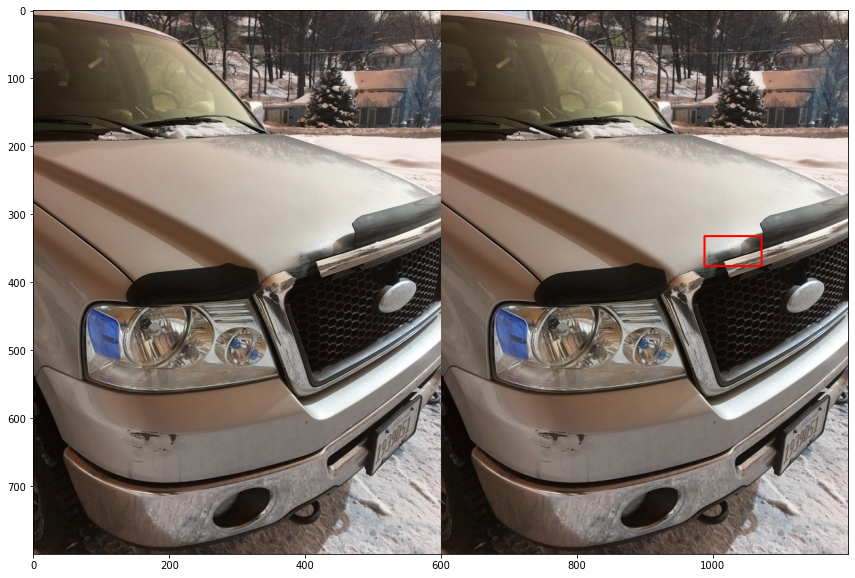

In [75]:
idx = 14999
plot(idx, es[str(idx)]['boxes'])

In [45]:
es = json.load(open('ensemble_dent.json'))
test_path = Path('./dent_tp_fp')
test_path.mkdir(parents=True, exist_ok=True)
for i in tqdm(test['images']):
    idx = i['id']
    cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_fp(idx,es[str(idx)]['boxes']))
    #cv2.imwrite('demo_crack.png',plot_fp(idx,es[str(idx)]['boxes']))
    #break

100%|██████████| 2252/2252 [07:48<00:00,  4.80it/s]


In [ ]:
## iou_thres = 0.5
# 1: 1 590 778 
# 2: 1 592 776

## iou_thres = 0.25
# 2: 1 581 695 

# iou = 0.36 weight 2 : 1 0.4
#581 646 573                      AP= 0.47 AR=0.5 crack
#567 596 587                      AP= 0.49 AR=0.49
#587 640 598 area < 800 (31 more) 
#588 639 606 area < 1000 (40 more)

In [ ]:
461 351 691
497 377 840

In [35]:
def es_objective_hypertune(params):
    print(params)
    pred_data = json.load(open('detector_pred_04.json'))
    pred_data_flip = json.load(open('yolo_pred.json'))
    
    es = OrderedDict()
    for i in test['images']:
        boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
        scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
        labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]

        if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = []
            i_data['labels'] = []
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[0]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[1]
            i_data['labels'] = labels_list[1]
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[1]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[0]
            i_data['labels'] = labels_list[0]
            es[str(i['id'])] = i_data
            continue
        # tuning here
        weights = [params['weight']+1,1]
        iou_thr = params['threshold']
        skip_box_thr = 0.0001
        sigma = 0.1

        boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes.tolist()
        i_data['labels'] = labels.tolist()
        es[str(i['id'])] = i_data

    total_tp = 0
    total_fn = 0
    total_fp = 0
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]

        pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
        for j in range(len(pred_boxes)):
            pred_boxes[j][0] = int(pred_boxes[j][0]*w)
            pred_boxes[j][1] = int(pred_boxes[j][1]*h)
            pred_boxes[j][2] = int(pred_boxes[j][2]*w)
            pred_boxes[j][3] = int(pred_boxes[j][3]*h)

            pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
        pred_labels = es[str(i['id'])]['labels']

        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
    print(total_tp,total_fp)
    return total_fp - 2*total_tp

def tuning():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'threshold' : hp.uniform('threshold',0.2,0.6),
            'weight' : hp.randint('weight',5),
            }
    result = fmin(fn=objective_hypertune, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result
    

In [ ]:
def score_oh(params):
    total_tp = 0
    total_fn = 0
    total_fp = 0
    
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
        
        result = inference_detector(model, image.copy())
        img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=params['confident_score'])
        
        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
    print("{} - TP : {} ,FP : {}, AP : {}".format(params['confident_score'],total_tp,total_fp,total_tp/(total_tp+total_fp)))
    
    return total_fp/(total_tp+total_fp)

def tuning_confident():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'confident_score' : hp.uniform('confident_score',0.2,0.5),
            }
    result = fmin(fn=score_oh, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result

print(tuning_confident())

0.4268592110572746 - TP : 443 ,FP : 355, AP : 0.5551378446115288
0.4789813947478013 - TP : 433 ,FP : 318, AP : 0.5765645805592543                   
 13%|█▎        | 2/15 [11:14<1:13:03, 337.22s/trial, best loss: 0.4234354194407457]

In [ ]:
#0.47680153265311676-423-332 
#0.46405537190928414 - TP : 425 ,FP : 339, AP : 0.556282722513089 

In [36]:
print(tuning())

{'threshold': 0.20186076643958806, 'weight': 1}       
569                                                   
602                                                   
{'threshold': 0.5889840584415416, 'weight': 0}                      
581                                                                 
725                                                                 
{'threshold': 0.34653284314044225, 'weight': 1}                     
579                                                                 
643                                                                 
{'threshold': 0.5142339445566273, 'weight': 2}                      
578                                                                 
695                                                                 
{'threshold': 0.5506285420334487, 'weight': 3}                      
579                                                                 
709                                                                 
{'thres

In [ ]:
# 0.3 {'threshold': 0.2003033575511911, 'weight': 0}
# 0.4 {'threshold': 0.36257411346807455, 'weight': 1}

In [13]:
581/(581+687)

0.4582018927444795

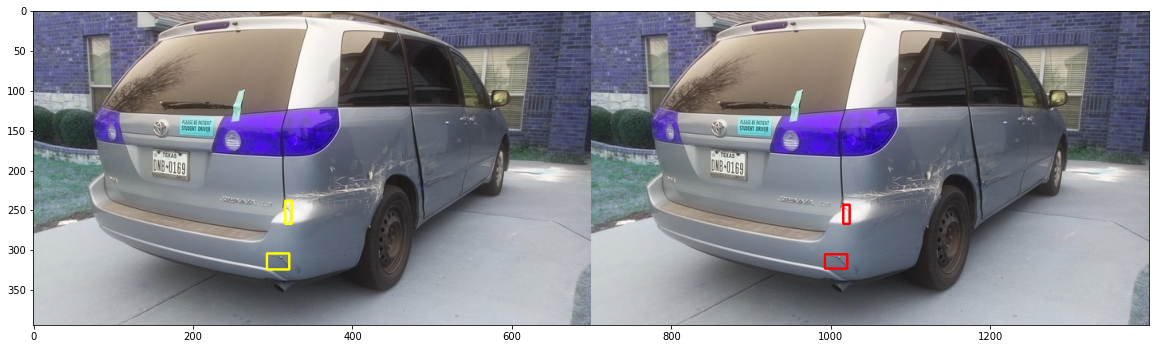

In [31]:
idx = 4950
plot(idx,es[str(idx)]['boxes'])
#for i in tqdm(test['images']):
#    idx = i['id']
#    cv2.imwrite('./test/'+str(i['id'])+'.png',plot(idx,es[str(idx)]['boxes']))